# Libraries

In [1]:
from keras.layers import Conv2D, Dense, LeakyReLU, Flatten,Input, BatchNormalization, Dropout, Conv2DTranspose, Reshape, Embedding, Concatenate, UpSampling2D
from keras.models   import Sequential, Model
from keras.optimizers import adam_v2
import numpy as np
from keras.datasets import fashion_mnist

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import keras

In [4]:
import matplotlib.pyplot as plt

In [5]:
from keras.layers import MaxPooling2D

# loading data

In [7]:
def fashionMNIST():
    """
        Loads fashion mnist datset
        returns: training and testing datasets
    """
    (Xtrain,Ytrain),(testX,testY) = fashion_mnist.load_data() # loading fashion mnist dataset
    print(Xtrain.shape)
    Xtrain = Xtrain.astype('float32') # assigning float data type
    Xtrain = np.expand_dims(Xtrain, axis = -1) 
    print(Xtrain.shape) #printing shape of training dataset
    testX = testX.astype('float32')
    testX = np.expand_dims(testX, axis = -1)
    return (Xtrain,Ytrain),(testX,testY)

(Xtrain,Ytrain),(testX,testY) = fashionMNIST()
Xtrain = (Xtrain - 127.5)/127.5 # Scaling dataset [-1,1 ] as we are going to use  tanh function

(60000, 28, 28)
(60000, 28, 28, 1)


# Model 

In [304]:
def fashionMnistGenerator(noise_dim = 100):
    """
        Generator model for fashion mnist dataset
        returns Model
        
        noise_dim: size of our initial noise
    """
    #Label embedding
    label_input = Input(shape = (1,))
    embedding_layer = Embedding(input_dim = 10 , output_dim = 50) (label_input)
    dense_layer1 = Dense(49)(embedding_layer) # dense layer for generating vector that is equal to dimension of image input
    label_shape = Reshape((7,7,1))(dense_layer1) # Converting above generated vector into desired for concatenating with image
    #reading the image
    noise_input = Input( shape = (100,))
    dense_layer2 = Dense(7*7*63, activation = "relu")(noise_input)
    batch_norm = BatchNormalization()(dense_layer2)
    noise_reshape = Reshape((7,7,63))(batch_norm) # Reshaping our noise into (3,3,128)
    #Adding label as extra channel to our image
    merge_image = Concatenate()([noise_reshape, label_shape]) 
    #second convolution transpose layer
    convtrans1 = Conv2DTranspose(32, kernel_size = (3,3), strides = (2,2),padding = "same",activation = "relu")(merge_image)
    #third convolution transpose layer
    convtrans2 = Conv2DTranspose(32, kernel_size = (3,3), strides = (2,2),padding = "same", activation = "relu")(convtrans1)
    #Convolution layer
    conv1 = Conv2D(1,kernel_size =(7,7),padding = "same",activation = 'tanh') (convtrans2)
    #Model 
    mnist_gen_model = Model([noise_input,label_input],conv1)
    
    return mnist_gen_model
    

In [307]:
def fashionMnistDiscriminator(image_shape = (28,28,1)):
    """
        discriminator model for fashion mnist dataset
        returns model
        image_shape: represents shape of image
    """
    #label embedding
    label_input = Input(shape = (1,))
    embedding_layer = Embedding(input_dim = 10 , output_dim = 50) (label_input)
    dense_layer1 = Dense(28*28)(embedding_layer) # dense layer for generating vector that is equal to dimension of image input
    label_shape = Reshape((28,28,1))(dense_layer1) # Converting above generated vector into desired for concatenating with image
    #reading actual image
    input_image = Input(shape = image_shape)
    #Merging label embedding as extra channel to image
    merge_image = Concatenate()([input_image, label_shape])
    #first convolution layer
    conv_1 = Conv2D(64,kernel_size = (5,5), strides = (2,2), padding = "same") (merge_image)
    leakyrelu_layer1 = LeakyReLU(alpha = 0.2) (conv_1)
    #second convolution layer
    conv_2 = Conv2D(128, kernel_size = (5,5),strides = (2,2), padding = "same" ) (leakyrelu_layer1)
    leakyrelu_layer2 = LeakyReLU(alpha = 0.2)(conv_2)
    #Flattening output from above inorder to pass to dense layer
    flatten = Flatten()(leakyrelu_layer2)
    #dense layer 
    dense_layer1 = Dense(128)(flatten)
    leakyrelu_layer3 = LeakyReLU(alpha = 0.2)(dense_layer1)
    #Dropping out few neurons inorder to reduce overfitting
    drop_1 = Dropout(0.5)(leakyrelu_layer3)
    #dense layer 
    dense_layer2 = Dense(1, activation = "sigmoid")(drop_1)
    #Model initialization
    mnist_dis_model = Model([input_image,label_input],dense_layer2)
    adam_opt = adam_v2.Adam(learning_rate=0.0002,beta_1 = 0.5) #setting optimizer
    #Compiling 
    mnist_dis_model.compile(loss = "binary_crossentropy", optimizer= adam_opt, metrics = ['accuracy'])
    return mnist_dis_model   

In [310]:
def conditionalGAN(generator, discriminator):

    #setting discriminator trainable to false
    discriminator.trainable = False
    
    # Generator
    generator_noise, generator_label = generator.input
    generator_output = generator.output
    
    #Discriminator
    discriminator_output = discriminator([generator_output,generator_label])
    

    #Model structuring
    model = Model([generator_noise,generator_label],discriminator_output)
    
    #Setting optimizer
    adam_opt = adam_v2.Adam(learning_rate=0.0002,beta_1 = 0.5)

    #Compiling cgan model
    model.compile(loss = "binary_crossentropy", optimizer= adam_opt, metrics = ['accuracy'])

    return model

In [318]:
generator = fashionMnistGenerator()
discriminator = fashionMnistDiscriminator()
cgan = conditionalGAN(generator,discriminator)

In [319]:
xtrain,_,ytrain,_ = train_test_split(Xtrain,Ytrain,test_size = 0.5,random_state = 42,stratify = Ytrain)

Epoch: 0 Batch 0 Loss fake: 0.693 Real: 0.797 GAN: 0.704 	 Accuracy fake: 0.531 Real: 0.016 GAN: 0.110
Epoch: 0 Batch 1 Loss fake: 0.688 Real: 0.553 GAN: 0.676 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.950
Epoch: 0 Batch 2 Loss fake: 0.695 Real: 0.389 GAN: 0.628 	 Accuracy fake: 0.172 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 3 Loss fake: 0.706 Real: 0.235 GAN: 0.552 	 Accuracy fake: 0.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 4 Loss fake: 0.725 Real: 0.111 GAN: 0.470 	 Accuracy fake: 0.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 5 Loss fake: 0.744 Real: 0.073 GAN: 0.397 	 Accuracy fake: 0.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 6 Loss fake: 0.757 Real: 0.057 GAN: 0.360 	 Accuracy fake: 0.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 7 Loss fake: 0.757 Real: 0.057 GAN: 0.352 	 Accuracy fake: 0.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 8 Loss fake: 0.740 Real: 0.052 GAN: 0.384 	 Accuracy fake: 0.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 9 Loss fake: 0.707 Real: 0.055 GAN: 0.436 	 Accuracy fake:

Epoch: 0 Batch 79 Loss fake: 0.002 Real: 0.001 GAN: 0.009 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 80 Loss fake: 0.002 Real: 0.000 GAN: 0.012 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 81 Loss fake: 0.002 Real: 0.000 GAN: 0.012 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 82 Loss fake: 0.002 Real: 0.000 GAN: 0.011 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 83 Loss fake: 0.002 Real: 0.000 GAN: 0.010 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 84 Loss fake: 0.002 Real: 0.001 GAN: 0.005 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 85 Loss fake: 0.002 Real: 0.000 GAN: 0.011 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 86 Loss fake: 0.002 Real: 0.000 GAN: 0.006 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 87 Loss fake: 0.002 Real: 0.000 GAN: 0.008 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 88 Loss fake: 0.002 Real: 0.000 GAN: 0.005 	 Accu

Epoch: 0 Batch 158 Loss fake: 0.001 Real: 0.000 GAN: 0.007 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 159 Loss fake: 0.001 Real: 0.000 GAN: 0.006 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 160 Loss fake: 0.001 Real: 0.000 GAN: 0.008 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 161 Loss fake: 0.001 Real: 0.001 GAN: 0.006 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 162 Loss fake: 0.001 Real: 0.000 GAN: 0.006 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 163 Loss fake: 0.001 Real: 0.000 GAN: 0.006 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 164 Loss fake: 0.001 Real: 0.000 GAN: 0.006 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 165 Loss fake: 0.001 Real: 0.000 GAN: 0.007 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 166 Loss fake: 0.001 Real: 0.000 GAN: 0.006 	 Accuracy fake: 1.000 Real: 1.000 GAN: 1.000
Epoch: 0 Batch 167 Loss fake: 0.001 Real: 0.000 GAN: 0.

Epoch: 0 Batch 237 Loss fake: 0.023 Real: 0.014 GAN: 4.026 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 238 Loss fake: 0.007 Real: 0.011 GAN: 4.264 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 239 Loss fake: 0.007 Real: 0.005 GAN: 4.407 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 240 Loss fake: 0.007 Real: 0.041 GAN: 2.784 	 Accuracy fake: 1.000 Real: 0.969 GAN: 0.000
Epoch: 0 Batch 241 Loss fake: 0.033 Real: 0.132 GAN: 2.037 	 Accuracy fake: 1.000 Real: 0.953 GAN: 0.010
Epoch: 0 Batch 242 Loss fake: 0.068 Real: 0.078 GAN: 5.231 	 Accuracy fake: 1.000 Real: 0.953 GAN: 0.000
Epoch: 0 Batch 243 Loss fake: 0.004 Real: 0.025 GAN: 3.737 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 0 Batch 244 Loss fake: 0.014 Real: 0.030 GAN: 2.512 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.010
Epoch: 0 Batch 245 Loss fake: 0.050 Real: 0.009 GAN: 6.683 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 246 Loss fake: 0.002 Real: 0.061 GAN: 4.

Epoch: 0 Batch 315 Loss fake: 0.005 Real: 0.023 GAN: 5.934 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 0 Batch 316 Loss fake: 0.004 Real: 0.006 GAN: 5.554 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 317 Loss fake: 0.007 Real: 0.002 GAN: 6.111 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 318 Loss fake: 0.005 Real: 0.006 GAN: 6.216 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 319 Loss fake: 0.005 Real: 0.042 GAN: 4.481 	 Accuracy fake: 1.000 Real: 0.969 GAN: 0.000
Epoch: 0 Batch 320 Loss fake: 0.019 Real: 0.004 GAN: 5.511 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 321 Loss fake: 0.008 Real: 0.001 GAN: 6.364 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 322 Loss fake: 0.003 Real: 0.007 GAN: 6.270 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 323 Loss fake: 0.003 Real: 0.014 GAN: 5.879 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 0 Batch 324 Loss fake: 0.005 Real: 0.000 GAN: 6.

Epoch: 0 Batch 394 Loss fake: 0.011 Real: 0.001 GAN: 6.898 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 395 Loss fake: 0.002 Real: 0.000 GAN: 7.613 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 396 Loss fake: 0.001 Real: 0.022 GAN: 6.650 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 0 Batch 397 Loss fake: 0.003 Real: 0.000 GAN: 5.927 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 398 Loss fake: 0.006 Real: 0.000 GAN: 6.817 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 399 Loss fake: 0.003 Real: 0.000 GAN: 7.280 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 400 Loss fake: 0.001 Real: 0.002 GAN: 7.181 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 401 Loss fake: 0.001 Real: 0.000 GAN: 7.384 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 402 Loss fake: 0.002 Real: 0.000 GAN: 7.604 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 0 Batch 403 Loss fake: 0.001 Real: 0.000 GAN: 7.

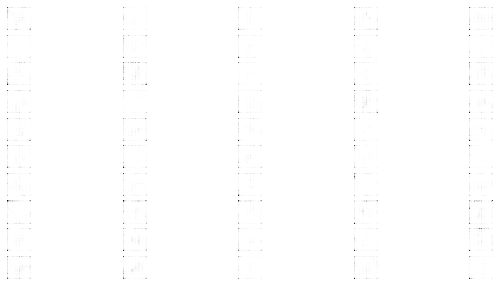

Epoch: 1 Batch 0 Loss fake: 0.001 Real: 0.024 GAN: 6.433 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 1 Loss fake: 0.003 Real: 0.021 GAN: 5.096 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 2 Loss fake: 0.011 Real: 0.032 GAN: 4.999 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 3 Loss fake: 0.016 Real: 0.001 GAN: 7.043 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 4 Loss fake: 0.002 Real: 0.000 GAN: 7.690 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 5 Loss fake: 0.001 Real: 0.001 GAN: 7.942 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 6 Loss fake: 0.001 Real: 0.002 GAN: 7.951 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 7 Loss fake: 0.001 Real: 0.001 GAN: 8.057 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 8 Loss fake: 0.001 Real: 0.000 GAN: 7.964 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 9 Loss fake: 0.001 Real: 0.003 GAN: 8.087 	 Accuracy fake:

Epoch: 1 Batch 79 Loss fake: 0.004 Real: 0.025 GAN: 5.650 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 80 Loss fake: 0.008 Real: 0.029 GAN: 4.194 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 81 Loss fake: 0.028 Real: 0.001 GAN: 7.440 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 82 Loss fake: 0.002 Real: 0.056 GAN: 6.204 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 83 Loss fake: 0.004 Real: 0.000 GAN: 5.164 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 84 Loss fake: 0.008 Real: 0.000 GAN: 6.269 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 85 Loss fake: 0.004 Real: 0.000 GAN: 6.910 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 86 Loss fake: 0.002 Real: 0.037 GAN: 5.612 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 87 Loss fake: 0.007 Real: 0.000 GAN: 5.324 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 88 Loss fake: 0.009 Real: 0.000 GAN: 6.817 	 Accu

Epoch: 1 Batch 158 Loss fake: 0.002 Real: 0.000 GAN: 7.397 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 159 Loss fake: 0.001 Real: 0.002 GAN: 7.699 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 160 Loss fake: 0.001 Real: 0.012 GAN: 6.413 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 161 Loss fake: 0.003 Real: 0.002 GAN: 6.068 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 162 Loss fake: 0.004 Real: 0.000 GAN: 6.943 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 163 Loss fake: 0.002 Real: 0.000 GAN: 7.417 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 164 Loss fake: 0.001 Real: 0.000 GAN: 7.924 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 165 Loss fake: 0.001 Real: 0.000 GAN: 8.004 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 166 Loss fake: 0.001 Real: 0.001 GAN: 8.076 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 167 Loss fake: 0.000 Real: 0.000 GAN: 8.

Epoch: 1 Batch 237 Loss fake: 0.000 Real: 0.005 GAN: 8.241 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 238 Loss fake: 0.001 Real: 0.000 GAN: 7.908 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 239 Loss fake: 0.001 Real: 0.000 GAN: 8.080 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 240 Loss fake: 0.001 Real: 0.000 GAN: 8.448 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 241 Loss fake: 0.001 Real: 0.009 GAN: 6.807 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 242 Loss fake: 0.003 Real: 0.001 GAN: 6.335 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 243 Loss fake: 0.003 Real: 0.000 GAN: 7.352 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 244 Loss fake: 0.001 Real: 0.002 GAN: 7.994 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 245 Loss fake: 0.001 Real: 0.000 GAN: 7.976 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 246 Loss fake: 0.001 Real: 0.000 GAN: 8.

Epoch: 1 Batch 316 Loss fake: 0.000 Real: 0.000 GAN: 9.010 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 317 Loss fake: 0.000 Real: 0.000 GAN: 9.156 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 318 Loss fake: 0.000 Real: 0.003 GAN: 8.894 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 319 Loss fake: 0.001 Real: 0.000 GAN: 8.554 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 320 Loss fake: 0.000 Real: 0.000 GAN: 8.529 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 321 Loss fake: 0.000 Real: 0.000 GAN: 8.601 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 322 Loss fake: 0.000 Real: 0.000 GAN: 8.578 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 323 Loss fake: 0.000 Real: 0.000 GAN: 8.607 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 324 Loss fake: 0.001 Real: 0.000 GAN: 8.983 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 325 Loss fake: 0.000 Real: 0.000 GAN: 9.

Epoch: 1 Batch 394 Loss fake: 0.005 Real: 0.068 GAN: 4.401 	 Accuracy fake: 1.000 Real: 0.969 GAN: 0.000
Epoch: 1 Batch 395 Loss fake: 0.014 Real: 0.045 GAN: 3.357 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 1 Batch 396 Loss fake: 0.051 Real: 0.008 GAN: 5.865 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 397 Loss fake: 0.006 Real: 0.114 GAN: 5.324 	 Accuracy fake: 1.000 Real: 0.938 GAN: 0.000
Epoch: 1 Batch 398 Loss fake: 0.008 Real: 0.009 GAN: 4.355 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 399 Loss fake: 0.015 Real: 0.007 GAN: 5.102 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 400 Loss fake: 0.009 Real: 0.004 GAN: 5.834 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 401 Loss fake: 0.005 Real: 0.004 GAN: 5.945 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 402 Loss fake: 0.003 Real: 0.006 GAN: 6.102 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 1 Batch 403 Loss fake: 0.003 Real: 0.021 GAN: 6.

Epoch: 2 Batch 5 Loss fake: 0.001 Real: 0.006 GAN: 6.650 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 6 Loss fake: 0.002 Real: 0.001 GAN: 6.698 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 7 Loss fake: 0.002 Real: 0.000 GAN: 6.917 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 8 Loss fake: 0.002 Real: 0.009 GAN: 6.764 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 9 Loss fake: 0.002 Real: 0.007 GAN: 6.720 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 10 Loss fake: 0.004 Real: 0.001 GAN: 6.894 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 11 Loss fake: 0.002 Real: 0.002 GAN: 6.791 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 12 Loss fake: 0.001 Real: 0.024 GAN: 6.392 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 2 Batch 13 Loss fake: 0.002 Real: 0.001 GAN: 6.211 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 14 Loss fake: 0.004 Real: 0.009 GAN: 6.028 	 Accuracy 

Epoch: 2 Batch 84 Loss fake: 0.005 Real: 0.004 GAN: 6.381 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 85 Loss fake: 0.004 Real: 0.000 GAN: 6.918 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 86 Loss fake: 0.002 Real: 0.003 GAN: 7.099 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 87 Loss fake: 0.002 Real: 0.000 GAN: 7.341 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 88 Loss fake: 0.002 Real: 0.002 GAN: 7.415 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 89 Loss fake: 0.001 Real: 0.002 GAN: 7.589 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 90 Loss fake: 0.001 Real: 0.022 GAN: 6.482 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 2 Batch 91 Loss fake: 0.003 Real: 0.042 GAN: 4.123 	 Accuracy fake: 1.000 Real: 0.984 GAN: 0.000
Epoch: 2 Batch 92 Loss fake: 0.025 Real: 0.002 GAN: 6.658 	 Accuracy fake: 1.000 Real: 1.000 GAN: 0.000
Epoch: 2 Batch 93 Loss fake: 0.002 Real: 0.032 GAN: 6.481 	 Accu

Epoch: 2 Batch 163 Loss fake: 0.345 Real: 0.342 GAN: 1.342 	 Accuracy fake: 0.984 Real: 0.781 GAN: 0.030
Epoch: 2 Batch 164 Loss fake: 0.387 Real: 0.429 GAN: 1.451 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.010
Epoch: 2 Batch 165 Loss fake: 0.317 Real: 0.468 GAN: 1.406 	 Accuracy fake: 0.984 Real: 0.703 GAN: 0.010
Epoch: 2 Batch 166 Loss fake: 0.343 Real: 0.418 GAN: 1.432 	 Accuracy fake: 0.953 Real: 0.719 GAN: 0.030
Epoch: 2 Batch 167 Loss fake: 0.346 Real: 0.366 GAN: 1.399 	 Accuracy fake: 0.984 Real: 0.766 GAN: 0.010
Epoch: 2 Batch 168 Loss fake: 0.401 Real: 0.384 GAN: 1.510 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.000
Epoch: 2 Batch 169 Loss fake: 0.325 Real: 0.549 GAN: 1.467 	 Accuracy fake: 0.938 Real: 0.641 GAN: 0.030
Epoch: 2 Batch 170 Loss fake: 0.285 Real: 0.383 GAN: 1.402 	 Accuracy fake: 0.984 Real: 0.734 GAN: 0.020
Epoch: 2 Batch 171 Loss fake: 0.348 Real: 0.470 GAN: 1.381 	 Accuracy fake: 0.969 Real: 0.672 GAN: 0.030
Epoch: 2 Batch 172 Loss fake: 0.311 Real: 0.390 GAN: 1.

Epoch: 2 Batch 242 Loss fake: 0.281 Real: 0.444 GAN: 2.143 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.020
Epoch: 2 Batch 243 Loss fake: 0.252 Real: 0.414 GAN: 1.782 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.060
Epoch: 2 Batch 244 Loss fake: 0.297 Real: 0.233 GAN: 1.784 	 Accuracy fake: 0.938 Real: 0.984 GAN: 0.040
Epoch: 2 Batch 245 Loss fake: 0.297 Real: 0.356 GAN: 1.965 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.020
Epoch: 2 Batch 246 Loss fake: 0.309 Real: 0.421 GAN: 1.824 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.030
Epoch: 2 Batch 247 Loss fake: 0.260 Real: 0.423 GAN: 1.791 	 Accuracy fake: 0.953 Real: 0.781 GAN: 0.050
Epoch: 2 Batch 248 Loss fake: 0.300 Real: 0.543 GAN: 1.473 	 Accuracy fake: 0.938 Real: 0.734 GAN: 0.050
Epoch: 2 Batch 249 Loss fake: 0.407 Real: 0.357 GAN: 1.743 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.050
Epoch: 2 Batch 250 Loss fake: 0.279 Real: 0.394 GAN: 1.744 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.050
Epoch: 2 Batch 251 Loss fake: 0.283 Real: 0.333 GAN: 1.

Epoch: 2 Batch 321 Loss fake: 0.385 Real: 0.497 GAN: 1.881 	 Accuracy fake: 0.797 Real: 0.781 GAN: 0.140
Epoch: 2 Batch 322 Loss fake: 0.425 Real: 0.511 GAN: 1.344 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.140
Epoch: 2 Batch 323 Loss fake: 0.596 Real: 0.374 GAN: 1.534 	 Accuracy fake: 0.750 Real: 0.859 GAN: 0.160
Epoch: 2 Batch 324 Loss fake: 0.476 Real: 0.591 GAN: 1.579 	 Accuracy fake: 0.797 Real: 0.688 GAN: 0.210
Epoch: 2 Batch 325 Loss fake: 0.626 Real: 0.507 GAN: 1.429 	 Accuracy fake: 0.672 Real: 0.750 GAN: 0.180
Epoch: 2 Batch 326 Loss fake: 0.586 Real: 0.625 GAN: 1.497 	 Accuracy fake: 0.703 Real: 0.719 GAN: 0.150
Epoch: 2 Batch 327 Loss fake: 0.429 Real: 0.480 GAN: 1.428 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.210
Epoch: 2 Batch 328 Loss fake: 0.509 Real: 0.484 GAN: 1.466 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.130
Epoch: 2 Batch 329 Loss fake: 0.454 Real: 0.489 GAN: 1.475 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.130
Epoch: 2 Batch 330 Loss fake: 0.415 Real: 0.416 GAN: 1.

Epoch: 2 Batch 400 Loss fake: 0.490 Real: 0.610 GAN: 1.742 	 Accuracy fake: 0.750 Real: 0.672 GAN: 0.130
Epoch: 2 Batch 401 Loss fake: 0.385 Real: 0.398 GAN: 1.699 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.120
Epoch: 2 Batch 402 Loss fake: 0.407 Real: 0.466 GAN: 1.841 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.100
Epoch: 2 Batch 403 Loss fake: 0.413 Real: 0.423 GAN: 1.684 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.170
Epoch: 2 Batch 404 Loss fake: 0.388 Real: 0.309 GAN: 2.070 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.110
Epoch: 2 Batch 405 Loss fake: 0.341 Real: 0.616 GAN: 1.713 	 Accuracy fake: 0.859 Real: 0.719 GAN: 0.200
Epoch: 2 Batch 406 Loss fake: 0.528 Real: 0.396 GAN: 1.715 	 Accuracy fake: 0.766 Real: 0.875 GAN: 0.170
Epoch: 2 Batch 407 Loss fake: 0.379 Real: 0.465 GAN: 1.800 	 Accuracy fake: 0.797 Real: 0.781 GAN: 0.150
Epoch: 2 Batch 408 Loss fake: 0.427 Real: 0.372 GAN: 1.864 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.080
Epoch: 2 Batch 409 Loss fake: 0.406 Real: 0.456 GAN: 1.

Epoch: 3 Batch 11 Loss fake: 0.261 Real: 0.414 GAN: 1.789 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.100
Epoch: 3 Batch 12 Loss fake: 0.372 Real: 0.318 GAN: 1.863 	 Accuracy fake: 0.812 Real: 0.891 GAN: 0.110
Epoch: 3 Batch 13 Loss fake: 0.370 Real: 0.367 GAN: 1.970 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.050
Epoch: 3 Batch 14 Loss fake: 0.306 Real: 0.309 GAN: 1.949 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.080
Epoch: 3 Batch 15 Loss fake: 0.271 Real: 0.336 GAN: 2.177 	 Accuracy fake: 0.953 Real: 0.891 GAN: 0.090
Epoch: 3 Batch 16 Loss fake: 0.267 Real: 0.396 GAN: 1.980 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.120
Epoch: 3 Batch 17 Loss fake: 0.465 Real: 0.482 GAN: 1.981 	 Accuracy fake: 0.766 Real: 0.781 GAN: 0.090
Epoch: 3 Batch 18 Loss fake: 0.305 Real: 0.420 GAN: 1.779 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.040
Epoch: 3 Batch 19 Loss fake: 0.284 Real: 0.285 GAN: 1.729 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.110
Epoch: 3 Batch 20 Loss fake: 0.375 Real: 0.258 GAN: 2.048 	 Accu

Epoch: 3 Batch 90 Loss fake: 0.280 Real: 0.409 GAN: 2.022 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.100
Epoch: 3 Batch 91 Loss fake: 0.352 Real: 0.411 GAN: 1.956 	 Accuracy fake: 0.797 Real: 0.859 GAN: 0.110
Epoch: 3 Batch 92 Loss fake: 0.364 Real: 0.331 GAN: 1.977 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.190
Epoch: 3 Batch 93 Loss fake: 0.327 Real: 0.525 GAN: 1.884 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.160
Epoch: 3 Batch 94 Loss fake: 0.196 Real: 0.260 GAN: 2.161 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.180
Epoch: 3 Batch 95 Loss fake: 0.456 Real: 0.399 GAN: 2.490 	 Accuracy fake: 0.750 Real: 0.828 GAN: 0.060
Epoch: 3 Batch 96 Loss fake: 0.255 Real: 0.289 GAN: 2.064 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.090
Epoch: 3 Batch 97 Loss fake: 0.330 Real: 0.432 GAN: 2.385 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.050
Epoch: 3 Batch 98 Loss fake: 0.298 Real: 0.386 GAN: 2.192 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.070
Epoch: 3 Batch 99 Loss fake: 0.335 Real: 0.300 GAN: 2.115 	 Accu

Epoch: 3 Batch 169 Loss fake: 0.396 Real: 0.332 GAN: 2.317 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.080
Epoch: 3 Batch 170 Loss fake: 0.221 Real: 0.365 GAN: 2.230 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.070
Epoch: 3 Batch 171 Loss fake: 0.327 Real: 0.325 GAN: 2.015 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.150
Epoch: 3 Batch 172 Loss fake: 0.248 Real: 0.271 GAN: 2.095 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.130
Epoch: 3 Batch 173 Loss fake: 0.302 Real: 0.375 GAN: 2.049 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.200
Epoch: 3 Batch 174 Loss fake: 0.255 Real: 0.260 GAN: 2.128 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.110
Epoch: 3 Batch 175 Loss fake: 0.388 Real: 0.403 GAN: 2.360 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.100
Epoch: 3 Batch 176 Loss fake: 0.241 Real: 0.387 GAN: 2.211 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.120
Epoch: 3 Batch 177 Loss fake: 0.350 Real: 0.349 GAN: 1.904 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.120
Epoch: 3 Batch 178 Loss fake: 0.346 Real: 0.270 GAN: 2.

Epoch: 3 Batch 248 Loss fake: 0.306 Real: 0.284 GAN: 1.950 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.050
Epoch: 3 Batch 249 Loss fake: 0.262 Real: 0.780 GAN: 1.580 	 Accuracy fake: 0.938 Real: 0.656 GAN: 0.080
Epoch: 3 Batch 250 Loss fake: 0.337 Real: 0.364 GAN: 1.654 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.130
Epoch: 3 Batch 251 Loss fake: 0.393 Real: 0.352 GAN: 1.667 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.130
Epoch: 3 Batch 252 Loss fake: 0.307 Real: 0.273 GAN: 1.831 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.080
Epoch: 3 Batch 253 Loss fake: 0.261 Real: 0.473 GAN: 1.794 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.110
Epoch: 3 Batch 254 Loss fake: 0.333 Real: 0.503 GAN: 1.688 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.180
Epoch: 3 Batch 255 Loss fake: 0.361 Real: 0.354 GAN: 1.677 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.060
Epoch: 3 Batch 256 Loss fake: 0.364 Real: 0.432 GAN: 2.036 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.100
Epoch: 3 Batch 257 Loss fake: 0.265 Real: 0.394 GAN: 1.

Epoch: 3 Batch 327 Loss fake: 0.318 Real: 0.336 GAN: 2.165 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.030
Epoch: 3 Batch 328 Loss fake: 0.283 Real: 0.422 GAN: 1.918 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.070
Epoch: 3 Batch 329 Loss fake: 0.301 Real: 0.335 GAN: 1.802 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.110
Epoch: 3 Batch 330 Loss fake: 0.282 Real: 0.259 GAN: 1.803 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.040
Epoch: 3 Batch 331 Loss fake: 0.308 Real: 0.371 GAN: 2.096 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.070
Epoch: 3 Batch 332 Loss fake: 0.225 Real: 0.372 GAN: 1.828 	 Accuracy fake: 0.969 Real: 0.844 GAN: 0.120
Epoch: 3 Batch 333 Loss fake: 0.293 Real: 0.262 GAN: 1.858 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.120
Epoch: 3 Batch 334 Loss fake: 0.302 Real: 0.342 GAN: 1.934 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.090
Epoch: 3 Batch 335 Loss fake: 0.381 Real: 0.410 GAN: 2.032 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.020
Epoch: 3 Batch 336 Loss fake: 0.339 Real: 0.447 GAN: 2.

Epoch: 3 Batch 406 Loss fake: 0.318 Real: 0.455 GAN: 2.080 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.100
Epoch: 3 Batch 407 Loss fake: 0.435 Real: 0.364 GAN: 1.985 	 Accuracy fake: 0.797 Real: 0.812 GAN: 0.090
Epoch: 3 Batch 408 Loss fake: 0.222 Real: 0.223 GAN: 2.109 	 Accuracy fake: 0.969 Real: 0.875 GAN: 0.080
Epoch: 3 Batch 409 Loss fake: 0.221 Real: 0.209 GAN: 2.039 	 Accuracy fake: 0.984 Real: 0.906 GAN: 0.130
Epoch: 3 Batch 410 Loss fake: 0.263 Real: 0.378 GAN: 1.898 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.070
Epoch: 3 Batch 411 Loss fake: 0.221 Real: 0.346 GAN: 1.858 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.140
Epoch: 3 Batch 412 Loss fake: 0.311 Real: 0.271 GAN: 1.930 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.090
Epoch: 3 Batch 413 Loss fake: 0.306 Real: 0.241 GAN: 2.133 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.080
Epoch: 3 Batch 414 Loss fake: 0.278 Real: 0.442 GAN: 2.152 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.070
Epoch: 3 Batch 415 Loss fake: 0.231 Real: 0.271 GAN: 2.

Epoch: 4 Batch 17 Loss fake: 0.191 Real: 0.364 GAN: 1.892 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.060
Epoch: 4 Batch 18 Loss fake: 0.265 Real: 0.358 GAN: 1.888 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.100
Epoch: 4 Batch 19 Loss fake: 0.277 Real: 0.259 GAN: 2.251 	 Accuracy fake: 0.938 Real: 0.891 GAN: 0.060
Epoch: 4 Batch 20 Loss fake: 0.176 Real: 0.260 GAN: 2.176 	 Accuracy fake: 0.969 Real: 0.891 GAN: 0.120
Epoch: 4 Batch 21 Loss fake: 0.300 Real: 0.300 GAN: 2.271 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.070
Epoch: 4 Batch 22 Loss fake: 0.185 Real: 0.269 GAN: 2.054 	 Accuracy fake: 0.922 Real: 0.922 GAN: 0.080
Epoch: 4 Batch 23 Loss fake: 0.318 Real: 0.293 GAN: 2.369 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.070
Epoch: 4 Batch 24 Loss fake: 0.298 Real: 0.285 GAN: 2.292 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.030
Epoch: 4 Batch 25 Loss fake: 0.307 Real: 0.427 GAN: 2.092 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.040
Epoch: 4 Batch 26 Loss fake: 0.231 Real: 0.348 GAN: 1.643 	 Accu

Epoch: 4 Batch 96 Loss fake: 0.247 Real: 0.406 GAN: 2.368 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.070
Epoch: 4 Batch 97 Loss fake: 0.190 Real: 0.169 GAN: 2.367 	 Accuracy fake: 0.969 Real: 0.953 GAN: 0.060
Epoch: 4 Batch 98 Loss fake: 0.329 Real: 0.557 GAN: 2.544 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.070
Epoch: 4 Batch 99 Loss fake: 0.321 Real: 0.346 GAN: 2.008 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.130
Epoch: 4 Batch 100 Loss fake: 0.347 Real: 0.342 GAN: 2.131 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.070
Epoch: 4 Batch 101 Loss fake: 0.240 Real: 0.320 GAN: 2.186 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.050
Epoch: 4 Batch 102 Loss fake: 0.180 Real: 0.213 GAN: 2.077 	 Accuracy fake: 0.969 Real: 0.875 GAN: 0.120
Epoch: 4 Batch 103 Loss fake: 0.243 Real: 0.289 GAN: 2.326 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.080
Epoch: 4 Batch 104 Loss fake: 0.193 Real: 0.399 GAN: 2.040 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.110
Epoch: 4 Batch 105 Loss fake: 0.261 Real: 0.235 GAN: 2.166 

Epoch: 4 Batch 175 Loss fake: 0.310 Real: 0.272 GAN: 2.441 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.030
Epoch: 4 Batch 176 Loss fake: 0.240 Real: 0.395 GAN: 2.180 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.090
Epoch: 4 Batch 177 Loss fake: 0.241 Real: 0.226 GAN: 1.971 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.150
Epoch: 4 Batch 178 Loss fake: 0.284 Real: 0.346 GAN: 2.829 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.050
Epoch: 4 Batch 179 Loss fake: 0.301 Real: 0.262 GAN: 2.414 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.050
Epoch: 4 Batch 180 Loss fake: 0.189 Real: 0.355 GAN: 2.353 	 Accuracy fake: 0.984 Real: 0.828 GAN: 0.090
Epoch: 4 Batch 181 Loss fake: 0.347 Real: 0.243 GAN: 2.701 	 Accuracy fake: 0.812 Real: 0.938 GAN: 0.050
Epoch: 4 Batch 182 Loss fake: 0.242 Real: 0.398 GAN: 2.339 	 Accuracy fake: 0.953 Real: 0.750 GAN: 0.090
Epoch: 4 Batch 183 Loss fake: 0.164 Real: 0.291 GAN: 2.075 	 Accuracy fake: 0.984 Real: 0.844 GAN: 0.120
Epoch: 4 Batch 184 Loss fake: 0.334 Real: 0.280 GAN: 2.

Epoch: 4 Batch 254 Loss fake: 0.210 Real: 0.199 GAN: 2.304 	 Accuracy fake: 0.938 Real: 0.906 GAN: 0.080
Epoch: 4 Batch 255 Loss fake: 0.240 Real: 0.303 GAN: 2.349 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.100
Epoch: 4 Batch 256 Loss fake: 0.215 Real: 0.280 GAN: 2.439 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.080
Epoch: 4 Batch 257 Loss fake: 0.199 Real: 0.382 GAN: 2.040 	 Accuracy fake: 0.969 Real: 0.828 GAN: 0.180
Epoch: 4 Batch 258 Loss fake: 0.307 Real: 0.271 GAN: 2.240 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.070
Epoch: 4 Batch 259 Loss fake: 0.230 Real: 0.244 GAN: 2.429 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.040
Epoch: 4 Batch 260 Loss fake: 0.227 Real: 0.226 GAN: 2.427 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.060
Epoch: 4 Batch 261 Loss fake: 0.255 Real: 0.471 GAN: 2.374 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.060
Epoch: 4 Batch 262 Loss fake: 0.202 Real: 0.466 GAN: 1.846 	 Accuracy fake: 0.953 Real: 0.766 GAN: 0.150
Epoch: 4 Batch 263 Loss fake: 0.287 Real: 0.211 GAN: 2.

Epoch: 4 Batch 333 Loss fake: 0.224 Real: 0.378 GAN: 2.321 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.120
Epoch: 4 Batch 334 Loss fake: 0.316 Real: 0.257 GAN: 2.463 	 Accuracy fake: 0.859 Real: 0.922 GAN: 0.070
Epoch: 4 Batch 335 Loss fake: 0.312 Real: 0.438 GAN: 2.183 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.110
Epoch: 4 Batch 336 Loss fake: 0.308 Real: 0.347 GAN: 2.250 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.100
Epoch: 4 Batch 337 Loss fake: 0.302 Real: 0.330 GAN: 2.159 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.140
Epoch: 4 Batch 338 Loss fake: 0.316 Real: 0.258 GAN: 2.220 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.100
Epoch: 4 Batch 339 Loss fake: 0.286 Real: 0.217 GAN: 2.645 	 Accuracy fake: 0.922 Real: 0.922 GAN: 0.030
Epoch: 4 Batch 340 Loss fake: 0.190 Real: 0.373 GAN: 2.684 	 Accuracy fake: 0.969 Real: 0.797 GAN: 0.060
Epoch: 4 Batch 341 Loss fake: 0.270 Real: 0.282 GAN: 2.532 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.030
Epoch: 4 Batch 342 Loss fake: 0.226 Real: 0.286 GAN: 2.

Epoch: 4 Batch 412 Loss fake: 0.264 Real: 0.336 GAN: 2.371 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.060
Epoch: 4 Batch 413 Loss fake: 0.328 Real: 0.265 GAN: 2.405 	 Accuracy fake: 0.844 Real: 0.906 GAN: 0.060
Epoch: 4 Batch 414 Loss fake: 0.286 Real: 0.346 GAN: 2.402 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.080
Epoch: 4 Batch 415 Loss fake: 0.301 Real: 0.268 GAN: 2.579 	 Accuracy fake: 0.875 Real: 0.922 GAN: 0.080
Epoch: 4 Batch 416 Loss fake: 0.226 Real: 0.385 GAN: 2.240 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.070
Epoch: 4 Batch 417 Loss fake: 0.239 Real: 0.431 GAN: 1.944 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.140
Epoch: 4 Batch 418 Loss fake: 0.331 Real: 0.296 GAN: 2.282 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.140
Epoch: 4 Batch 419 Loss fake: 0.393 Real: 0.370 GAN: 2.258 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 4 Batch 420 Loss fake: 0.231 Real: 0.276 GAN: 2.556 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.120
Epoch: 4 Batch 421 Loss fake: 0.182 Real: 0.269 GAN: 2.

Epoch: 5 Batch 23 Loss fake: 0.241 Real: 0.341 GAN: 2.117 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.050
Epoch: 5 Batch 24 Loss fake: 0.198 Real: 0.297 GAN: 1.928 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.110
Epoch: 5 Batch 25 Loss fake: 0.252 Real: 0.287 GAN: 2.221 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.140
Epoch: 5 Batch 26 Loss fake: 0.453 Real: 0.315 GAN: 2.551 	 Accuracy fake: 0.797 Real: 0.875 GAN: 0.040
Epoch: 5 Batch 27 Loss fake: 0.266 Real: 0.355 GAN: 2.684 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.020
Epoch: 5 Batch 28 Loss fake: 0.212 Real: 0.291 GAN: 2.379 	 Accuracy fake: 0.969 Real: 0.859 GAN: 0.050
Epoch: 5 Batch 29 Loss fake: 0.260 Real: 0.207 GAN: 2.107 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.100
Epoch: 5 Batch 30 Loss fake: 0.226 Real: 0.264 GAN: 2.232 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.060
Epoch: 5 Batch 31 Loss fake: 0.275 Real: 0.279 GAN: 2.568 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.060
Epoch: 5 Batch 32 Loss fake: 0.379 Real: 0.286 GAN: 2.594 	 Accu

Epoch: 5 Batch 102 Loss fake: 0.250 Real: 0.199 GAN: 1.907 	 Accuracy fake: 0.953 Real: 0.891 GAN: 0.150
Epoch: 5 Batch 103 Loss fake: 0.291 Real: 0.252 GAN: 2.355 	 Accuracy fake: 0.875 Real: 0.922 GAN: 0.060
Epoch: 5 Batch 104 Loss fake: 0.253 Real: 0.407 GAN: 2.259 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.110
Epoch: 5 Batch 105 Loss fake: 0.403 Real: 0.305 GAN: 2.233 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.100
Epoch: 5 Batch 106 Loss fake: 0.338 Real: 0.493 GAN: 1.961 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.150
Epoch: 5 Batch 107 Loss fake: 0.229 Real: 0.270 GAN: 1.857 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.180
Epoch: 5 Batch 108 Loss fake: 0.424 Real: 0.281 GAN: 2.148 	 Accuracy fake: 0.875 Real: 0.922 GAN: 0.090
Epoch: 5 Batch 109 Loss fake: 0.339 Real: 0.427 GAN: 2.329 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.040
Epoch: 5 Batch 110 Loss fake: 0.236 Real: 0.458 GAN: 2.124 	 Accuracy fake: 0.953 Real: 0.766 GAN: 0.080
Epoch: 5 Batch 111 Loss fake: 0.362 Real: 0.295 GAN: 2.

Epoch: 5 Batch 181 Loss fake: 0.249 Real: 0.434 GAN: 2.026 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.120
Epoch: 5 Batch 182 Loss fake: 0.317 Real: 0.416 GAN: 2.211 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.060
Epoch: 5 Batch 183 Loss fake: 0.292 Real: 0.418 GAN: 1.877 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.110
Epoch: 5 Batch 184 Loss fake: 0.393 Real: 0.417 GAN: 2.134 	 Accuracy fake: 0.797 Real: 0.812 GAN: 0.090
Epoch: 5 Batch 185 Loss fake: 0.268 Real: 0.404 GAN: 1.870 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.090
Epoch: 5 Batch 186 Loss fake: 0.258 Real: 0.260 GAN: 1.976 	 Accuracy fake: 0.938 Real: 0.891 GAN: 0.100
Epoch: 5 Batch 187 Loss fake: 0.373 Real: 0.248 GAN: 2.382 	 Accuracy fake: 0.891 Real: 0.922 GAN: 0.060
Epoch: 5 Batch 188 Loss fake: 0.269 Real: 0.263 GAN: 2.348 	 Accuracy fake: 0.953 Real: 0.891 GAN: 0.070
Epoch: 5 Batch 189 Loss fake: 0.226 Real: 0.519 GAN: 1.794 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.190
Epoch: 5 Batch 190 Loss fake: 0.386 Real: 0.253 GAN: 2.

Epoch: 5 Batch 260 Loss fake: 0.171 Real: 0.331 GAN: 1.790 	 Accuracy fake: 0.984 Real: 0.828 GAN: 0.120
Epoch: 5 Batch 261 Loss fake: 0.364 Real: 0.355 GAN: 1.823 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.160
Epoch: 5 Batch 262 Loss fake: 0.452 Real: 0.392 GAN: 2.130 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.100
Epoch: 5 Batch 263 Loss fake: 0.274 Real: 0.315 GAN: 2.252 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.070
Epoch: 5 Batch 264 Loss fake: 0.229 Real: 0.370 GAN: 2.197 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.080
Epoch: 5 Batch 265 Loss fake: 0.284 Real: 0.391 GAN: 1.764 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.140
Epoch: 5 Batch 266 Loss fake: 0.435 Real: 0.303 GAN: 2.444 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.040
Epoch: 5 Batch 267 Loss fake: 0.241 Real: 0.255 GAN: 2.291 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.070
Epoch: 5 Batch 268 Loss fake: 0.263 Real: 0.356 GAN: 2.236 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.080
Epoch: 5 Batch 269 Loss fake: 0.197 Real: 0.199 GAN: 1.

Epoch: 5 Batch 339 Loss fake: 0.356 Real: 0.541 GAN: 2.116 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.050
Epoch: 5 Batch 340 Loss fake: 0.271 Real: 0.316 GAN: 1.786 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.190
Epoch: 5 Batch 341 Loss fake: 0.276 Real: 0.262 GAN: 1.966 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.120
Epoch: 5 Batch 342 Loss fake: 0.317 Real: 0.262 GAN: 2.045 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.070
Epoch: 5 Batch 343 Loss fake: 0.262 Real: 0.314 GAN: 2.147 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.130
Epoch: 5 Batch 344 Loss fake: 0.276 Real: 0.551 GAN: 1.776 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.090
Epoch: 5 Batch 345 Loss fake: 0.417 Real: 0.348 GAN: 2.015 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.120
Epoch: 5 Batch 346 Loss fake: 0.344 Real: 0.274 GAN: 2.398 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.060
Epoch: 5 Batch 347 Loss fake: 0.307 Real: 0.492 GAN: 2.020 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.120
Epoch: 5 Batch 348 Loss fake: 0.296 Real: 0.264 GAN: 1.

Epoch: 5 Batch 418 Loss fake: 0.292 Real: 0.208 GAN: 2.276 	 Accuracy fake: 0.922 Real: 0.953 GAN: 0.090
Epoch: 5 Batch 419 Loss fake: 0.315 Real: 0.290 GAN: 2.079 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.050
Epoch: 5 Batch 420 Loss fake: 0.304 Real: 0.282 GAN: 2.403 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.040
Epoch: 5 Batch 421 Loss fake: 0.237 Real: 0.431 GAN: 2.255 	 Accuracy fake: 0.969 Real: 0.812 GAN: 0.060
Epoch: 5 Batch 422 Loss fake: 0.279 Real: 0.296 GAN: 2.205 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.080
Epoch: 5 Batch 423 Loss fake: 0.235 Real: 0.248 GAN: 2.342 	 Accuracy fake: 0.953 Real: 0.922 GAN: 0.050
Epoch: 5 Batch 424 Loss fake: 0.200 Real: 0.301 GAN: 2.211 	 Accuracy fake: 0.969 Real: 0.891 GAN: 0.090
Epoch: 5 Batch 425 Loss fake: 0.321 Real: 0.344 GAN: 2.422 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.030
Epoch: 5 Batch 426 Loss fake: 0.341 Real: 0.470 GAN: 2.186 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.100
Epoch: 5 Batch 427 Loss fake: 0.276 Real: 0.249 GAN: 2.

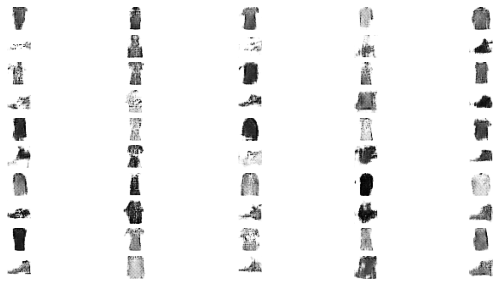

Epoch: 6 Batch 0 Loss fake: 0.240 Real: 0.304 GAN: 2.219 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.080
Epoch: 6 Batch 1 Loss fake: 0.323 Real: 0.375 GAN: 2.045 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.060
Epoch: 6 Batch 2 Loss fake: 0.333 Real: 0.208 GAN: 2.421 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.070
Epoch: 6 Batch 3 Loss fake: 0.200 Real: 0.372 GAN: 2.318 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.080
Epoch: 6 Batch 4 Loss fake: 0.221 Real: 0.466 GAN: 1.733 	 Accuracy fake: 0.953 Real: 0.766 GAN: 0.160
Epoch: 6 Batch 5 Loss fake: 0.316 Real: 0.166 GAN: 2.156 	 Accuracy fake: 0.875 Real: 0.953 GAN: 0.160
Epoch: 6 Batch 6 Loss fake: 0.305 Real: 0.410 GAN: 2.038 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.070
Epoch: 6 Batch 7 Loss fake: 0.354 Real: 0.452 GAN: 1.898 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.120
Epoch: 6 Batch 8 Loss fake: 0.353 Real: 0.265 GAN: 2.123 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.050
Epoch: 6 Batch 9 Loss fake: 0.276 Real: 0.355 GAN: 1.886 	 Accuracy fake:

Epoch: 6 Batch 79 Loss fake: 0.192 Real: 0.477 GAN: 2.110 	 Accuracy fake: 0.984 Real: 0.766 GAN: 0.050
Epoch: 6 Batch 80 Loss fake: 0.470 Real: 0.312 GAN: 2.401 	 Accuracy fake: 0.797 Real: 0.844 GAN: 0.050
Epoch: 6 Batch 81 Loss fake: 0.197 Real: 0.379 GAN: 2.500 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.100
Epoch: 6 Batch 82 Loss fake: 0.250 Real: 0.427 GAN: 1.659 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.180
Epoch: 6 Batch 83 Loss fake: 0.353 Real: 0.304 GAN: 1.784 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.100
Epoch: 6 Batch 84 Loss fake: 0.287 Real: 0.219 GAN: 2.044 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.120
Epoch: 6 Batch 85 Loss fake: 0.248 Real: 0.291 GAN: 1.963 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.080
Epoch: 6 Batch 86 Loss fake: 0.238 Real: 0.328 GAN: 2.191 	 Accuracy fake: 0.969 Real: 0.844 GAN: 0.110
Epoch: 6 Batch 87 Loss fake: 0.310 Real: 0.389 GAN: 2.022 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.120
Epoch: 6 Batch 88 Loss fake: 0.321 Real: 0.237 GAN: 2.339 	 Accu

Epoch: 6 Batch 158 Loss fake: 0.325 Real: 0.385 GAN: 1.831 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.120
Epoch: 6 Batch 159 Loss fake: 0.384 Real: 0.295 GAN: 2.025 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.090
Epoch: 6 Batch 160 Loss fake: 0.264 Real: 0.381 GAN: 1.988 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.120
Epoch: 6 Batch 161 Loss fake: 0.318 Real: 0.342 GAN: 2.283 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.100
Epoch: 6 Batch 162 Loss fake: 0.227 Real: 0.418 GAN: 1.908 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.130
Epoch: 6 Batch 163 Loss fake: 0.315 Real: 0.243 GAN: 1.902 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.050
Epoch: 6 Batch 164 Loss fake: 0.315 Real: 0.335 GAN: 2.277 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.080
Epoch: 6 Batch 165 Loss fake: 0.229 Real: 0.453 GAN: 1.895 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.120
Epoch: 6 Batch 166 Loss fake: 0.330 Real: 0.323 GAN: 1.892 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.140
Epoch: 6 Batch 167 Loss fake: 0.305 Real: 0.232 GAN: 1.

Epoch: 6 Batch 237 Loss fake: 0.302 Real: 0.371 GAN: 1.870 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.140
Epoch: 6 Batch 238 Loss fake: 0.350 Real: 0.356 GAN: 1.977 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.140
Epoch: 6 Batch 239 Loss fake: 0.299 Real: 0.399 GAN: 1.858 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.140
Epoch: 6 Batch 240 Loss fake: 0.315 Real: 0.371 GAN: 1.657 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.160
Epoch: 6 Batch 241 Loss fake: 0.384 Real: 0.347 GAN: 1.964 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.130
Epoch: 6 Batch 242 Loss fake: 0.276 Real: 0.291 GAN: 2.156 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.090
Epoch: 6 Batch 243 Loss fake: 0.324 Real: 0.386 GAN: 2.086 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.040
Epoch: 6 Batch 244 Loss fake: 0.302 Real: 0.422 GAN: 1.940 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.090
Epoch: 6 Batch 245 Loss fake: 0.248 Real: 0.250 GAN: 1.935 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.080
Epoch: 6 Batch 246 Loss fake: 0.322 Real: 0.362 GAN: 2.

Epoch: 6 Batch 316 Loss fake: 0.181 Real: 0.238 GAN: 1.970 	 Accuracy fake: 0.984 Real: 0.906 GAN: 0.150
Epoch: 6 Batch 317 Loss fake: 0.208 Real: 0.326 GAN: 2.045 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.130
Epoch: 6 Batch 318 Loss fake: 0.396 Real: 0.262 GAN: 2.102 	 Accuracy fake: 0.797 Real: 0.875 GAN: 0.060
Epoch: 6 Batch 319 Loss fake: 0.325 Real: 0.285 GAN: 2.099 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.060
Epoch: 6 Batch 320 Loss fake: 0.322 Real: 0.385 GAN: 2.524 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.060
Epoch: 6 Batch 321 Loss fake: 0.243 Real: 0.360 GAN: 2.003 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.090
Epoch: 6 Batch 322 Loss fake: 0.265 Real: 0.309 GAN: 1.875 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.150
Epoch: 6 Batch 323 Loss fake: 0.384 Real: 0.367 GAN: 2.196 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.100
Epoch: 6 Batch 324 Loss fake: 0.286 Real: 0.318 GAN: 2.195 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.090
Epoch: 6 Batch 325 Loss fake: 0.485 Real: 0.393 GAN: 2.

Epoch: 6 Batch 395 Loss fake: 0.408 Real: 0.270 GAN: 2.106 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.090
Epoch: 6 Batch 396 Loss fake: 0.320 Real: 0.504 GAN: 2.008 	 Accuracy fake: 0.891 Real: 0.703 GAN: 0.150
Epoch: 6 Batch 397 Loss fake: 0.304 Real: 0.284 GAN: 1.839 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.170
Epoch: 6 Batch 398 Loss fake: 0.399 Real: 0.309 GAN: 2.301 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.070
Epoch: 6 Batch 399 Loss fake: 0.326 Real: 0.584 GAN: 1.967 	 Accuracy fake: 0.922 Real: 0.688 GAN: 0.140
Epoch: 6 Batch 400 Loss fake: 0.264 Real: 0.256 GAN: 1.959 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.130
Epoch: 6 Batch 401 Loss fake: 0.243 Real: 0.256 GAN: 2.311 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.100
Epoch: 6 Batch 402 Loss fake: 0.294 Real: 0.284 GAN: 2.429 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.050
Epoch: 6 Batch 403 Loss fake: 0.161 Real: 0.337 GAN: 2.465 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.050
Epoch: 6 Batch 404 Loss fake: 0.268 Real: 0.336 GAN: 1.

Epoch: 7 Batch 6 Loss fake: 0.345 Real: 0.370 GAN: 2.151 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.130
Epoch: 7 Batch 7 Loss fake: 0.213 Real: 0.322 GAN: 2.382 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.090
Epoch: 7 Batch 8 Loss fake: 0.251 Real: 0.317 GAN: 2.175 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.090
Epoch: 7 Batch 9 Loss fake: 0.285 Real: 0.436 GAN: 2.018 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.130
Epoch: 7 Batch 10 Loss fake: 0.302 Real: 0.292 GAN: 2.089 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.080
Epoch: 7 Batch 11 Loss fake: 0.345 Real: 0.339 GAN: 2.306 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.070
Epoch: 7 Batch 12 Loss fake: 0.211 Real: 0.372 GAN: 2.035 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.090
Epoch: 7 Batch 13 Loss fake: 0.430 Real: 0.248 GAN: 2.249 	 Accuracy fake: 0.781 Real: 0.875 GAN: 0.090
Epoch: 7 Batch 14 Loss fake: 0.280 Real: 0.340 GAN: 2.225 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.060
Epoch: 7 Batch 15 Loss fake: 0.206 Real: 0.327 GAN: 2.250 	 Accuracy

Epoch: 7 Batch 85 Loss fake: 0.347 Real: 0.297 GAN: 1.929 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.100
Epoch: 7 Batch 86 Loss fake: 0.318 Real: 0.367 GAN: 2.074 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.110
Epoch: 7 Batch 87 Loss fake: 0.305 Real: 0.392 GAN: 1.995 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.140
Epoch: 7 Batch 88 Loss fake: 0.362 Real: 0.256 GAN: 2.256 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.090
Epoch: 7 Batch 89 Loss fake: 0.327 Real: 0.278 GAN: 2.373 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.070
Epoch: 7 Batch 90 Loss fake: 0.261 Real: 0.531 GAN: 1.762 	 Accuracy fake: 0.922 Real: 0.734 GAN: 0.170
Epoch: 7 Batch 91 Loss fake: 0.333 Real: 0.399 GAN: 2.049 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.170
Epoch: 7 Batch 92 Loss fake: 0.333 Real: 0.285 GAN: 1.977 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.120
Epoch: 7 Batch 93 Loss fake: 0.374 Real: 0.323 GAN: 2.144 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.060
Epoch: 7 Batch 94 Loss fake: 0.231 Real: 0.455 GAN: 2.004 	 Accu

Epoch: 7 Batch 164 Loss fake: 0.349 Real: 0.305 GAN: 1.727 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.170
Epoch: 7 Batch 165 Loss fake: 0.485 Real: 0.480 GAN: 2.056 	 Accuracy fake: 0.812 Real: 0.719 GAN: 0.110
Epoch: 7 Batch 166 Loss fake: 0.424 Real: 0.220 GAN: 2.173 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.080
Epoch: 7 Batch 167 Loss fake: 0.215 Real: 0.361 GAN: 2.321 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.060
Epoch: 7 Batch 168 Loss fake: 0.247 Real: 0.326 GAN: 1.993 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.060
Epoch: 7 Batch 169 Loss fake: 0.275 Real: 0.260 GAN: 2.288 	 Accuracy fake: 0.875 Real: 0.906 GAN: 0.110
Epoch: 7 Batch 170 Loss fake: 0.331 Real: 0.448 GAN: 2.085 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.050
Epoch: 7 Batch 171 Loss fake: 0.277 Real: 0.481 GAN: 1.587 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.170
Epoch: 7 Batch 172 Loss fake: 0.332 Real: 0.280 GAN: 1.833 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.180
Epoch: 7 Batch 173 Loss fake: 0.322 Real: 0.289 GAN: 1.

Epoch: 7 Batch 243 Loss fake: 0.283 Real: 0.322 GAN: 2.035 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.070
Epoch: 7 Batch 244 Loss fake: 0.242 Real: 0.403 GAN: 2.039 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.080
Epoch: 7 Batch 245 Loss fake: 0.373 Real: 0.345 GAN: 2.020 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.130
Epoch: 7 Batch 246 Loss fake: 0.455 Real: 0.422 GAN: 2.179 	 Accuracy fake: 0.797 Real: 0.734 GAN: 0.090
Epoch: 7 Batch 247 Loss fake: 0.330 Real: 0.587 GAN: 2.091 	 Accuracy fake: 0.875 Real: 0.672 GAN: 0.080
Epoch: 7 Batch 248 Loss fake: 0.353 Real: 0.367 GAN: 1.986 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.110
Epoch: 7 Batch 249 Loss fake: 0.261 Real: 0.440 GAN: 1.728 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.120
Epoch: 7 Batch 250 Loss fake: 0.410 Real: 0.396 GAN: 1.692 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.100
Epoch: 7 Batch 251 Loss fake: 0.325 Real: 0.526 GAN: 1.570 	 Accuracy fake: 0.828 Real: 0.719 GAN: 0.190
Epoch: 7 Batch 252 Loss fake: 0.448 Real: 0.273 GAN: 1.

Epoch: 7 Batch 322 Loss fake: 0.283 Real: 0.532 GAN: 1.958 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.130
Epoch: 7 Batch 323 Loss fake: 0.238 Real: 0.277 GAN: 1.845 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.110
Epoch: 7 Batch 324 Loss fake: 0.366 Real: 0.476 GAN: 2.146 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.080
Epoch: 7 Batch 325 Loss fake: 0.288 Real: 0.380 GAN: 1.912 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.120
Epoch: 7 Batch 326 Loss fake: 0.311 Real: 0.150 GAN: 2.329 	 Accuracy fake: 0.906 Real: 0.953 GAN: 0.090
Epoch: 7 Batch 327 Loss fake: 0.293 Real: 0.359 GAN: 2.145 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.060
Epoch: 7 Batch 328 Loss fake: 0.268 Real: 0.313 GAN: 2.344 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.120
Epoch: 7 Batch 329 Loss fake: 0.282 Real: 0.341 GAN: 2.314 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.010
Epoch: 7 Batch 330 Loss fake: 0.203 Real: 0.392 GAN: 2.277 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.110
Epoch: 7 Batch 331 Loss fake: 0.243 Real: 0.276 GAN: 2.

Epoch: 7 Batch 401 Loss fake: 0.256 Real: 0.364 GAN: 2.041 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.130
Epoch: 7 Batch 402 Loss fake: 0.237 Real: 0.264 GAN: 1.912 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.160
Epoch: 7 Batch 403 Loss fake: 0.417 Real: 0.314 GAN: 2.311 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.070
Epoch: 7 Batch 404 Loss fake: 0.253 Real: 0.382 GAN: 2.299 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.110
Epoch: 7 Batch 405 Loss fake: 0.207 Real: 0.363 GAN: 2.055 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.100
Epoch: 7 Batch 406 Loss fake: 0.335 Real: 0.301 GAN: 2.061 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.070
Epoch: 7 Batch 407 Loss fake: 0.255 Real: 0.404 GAN: 1.881 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.200
Epoch: 7 Batch 408 Loss fake: 0.376 Real: 0.359 GAN: 2.056 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.190
Epoch: 7 Batch 409 Loss fake: 0.287 Real: 0.373 GAN: 1.780 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.190
Epoch: 7 Batch 410 Loss fake: 0.460 Real: 0.493 GAN: 2.

Epoch: 8 Batch 12 Loss fake: 0.360 Real: 0.266 GAN: 1.902 	 Accuracy fake: 0.844 Real: 0.922 GAN: 0.120
Epoch: 8 Batch 13 Loss fake: 0.417 Real: 0.330 GAN: 1.967 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.060
Epoch: 8 Batch 14 Loss fake: 0.306 Real: 0.513 GAN: 2.010 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.150
Epoch: 8 Batch 15 Loss fake: 0.303 Real: 0.425 GAN: 1.748 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.110
Epoch: 8 Batch 16 Loss fake: 0.340 Real: 0.231 GAN: 1.979 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.150
Epoch: 8 Batch 17 Loss fake: 0.301 Real: 0.434 GAN: 2.066 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.120
Epoch: 8 Batch 18 Loss fake: 0.330 Real: 0.435 GAN: 2.027 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.140
Epoch: 8 Batch 19 Loss fake: 0.374 Real: 0.384 GAN: 1.971 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.130
Epoch: 8 Batch 20 Loss fake: 0.418 Real: 0.317 GAN: 2.210 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.040
Epoch: 8 Batch 21 Loss fake: 0.378 Real: 0.532 GAN: 2.118 	 Accu

Epoch: 8 Batch 91 Loss fake: 0.321 Real: 0.425 GAN: 1.935 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.140
Epoch: 8 Batch 92 Loss fake: 0.369 Real: 0.423 GAN: 1.962 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.150
Epoch: 8 Batch 93 Loss fake: 0.227 Real: 0.334 GAN: 1.917 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.110
Epoch: 8 Batch 94 Loss fake: 0.343 Real: 0.346 GAN: 2.215 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.080
Epoch: 8 Batch 95 Loss fake: 0.323 Real: 0.304 GAN: 2.014 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.110
Epoch: 8 Batch 96 Loss fake: 0.321 Real: 0.429 GAN: 2.070 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.050
Epoch: 8 Batch 97 Loss fake: 0.301 Real: 0.363 GAN: 2.301 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.120
Epoch: 8 Batch 98 Loss fake: 0.408 Real: 0.334 GAN: 2.304 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.050
Epoch: 8 Batch 99 Loss fake: 0.177 Real: 0.302 GAN: 2.465 	 Accuracy fake: 0.984 Real: 0.875 GAN: 0.050
Epoch: 8 Batch 100 Loss fake: 0.316 Real: 0.434 GAN: 2.118 	 Acc

Epoch: 8 Batch 170 Loss fake: 0.254 Real: 0.331 GAN: 2.034 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.130
Epoch: 8 Batch 171 Loss fake: 0.492 Real: 0.428 GAN: 2.235 	 Accuracy fake: 0.766 Real: 0.766 GAN: 0.120
Epoch: 8 Batch 172 Loss fake: 0.235 Real: 0.471 GAN: 1.962 	 Accuracy fake: 0.922 Real: 0.734 GAN: 0.100
Epoch: 8 Batch 173 Loss fake: 0.260 Real: 0.349 GAN: 1.492 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.180
Epoch: 8 Batch 174 Loss fake: 0.451 Real: 0.303 GAN: 1.910 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.100
Epoch: 8 Batch 175 Loss fake: 0.353 Real: 0.451 GAN: 2.206 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.110
Epoch: 8 Batch 176 Loss fake: 0.326 Real: 0.321 GAN: 2.278 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.040
Epoch: 8 Batch 177 Loss fake: 0.269 Real: 0.515 GAN: 1.914 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.140
Epoch: 8 Batch 178 Loss fake: 0.353 Real: 0.230 GAN: 2.086 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.150
Epoch: 8 Batch 179 Loss fake: 0.324 Real: 0.238 GAN: 2.

Epoch: 8 Batch 249 Loss fake: 0.341 Real: 0.370 GAN: 2.027 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.110
Epoch: 8 Batch 250 Loss fake: 0.280 Real: 0.338 GAN: 1.946 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.110
Epoch: 8 Batch 251 Loss fake: 0.324 Real: 0.411 GAN: 2.047 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.110
Epoch: 8 Batch 252 Loss fake: 0.475 Real: 0.589 GAN: 1.975 	 Accuracy fake: 0.797 Real: 0.719 GAN: 0.090
Epoch: 8 Batch 253 Loss fake: 0.375 Real: 0.441 GAN: 1.957 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.130
Epoch: 8 Batch 254 Loss fake: 0.327 Real: 0.561 GAN: 1.477 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.180
Epoch: 8 Batch 255 Loss fake: 0.403 Real: 0.348 GAN: 1.896 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.170
Epoch: 8 Batch 256 Loss fake: 0.601 Real: 0.413 GAN: 2.205 	 Accuracy fake: 0.734 Real: 0.750 GAN: 0.110
Epoch: 8 Batch 257 Loss fake: 0.331 Real: 0.474 GAN: 2.072 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.110
Epoch: 8 Batch 258 Loss fake: 0.276 Real: 0.301 GAN: 1.

Epoch: 8 Batch 328 Loss fake: 0.270 Real: 0.334 GAN: 2.004 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.110
Epoch: 8 Batch 329 Loss fake: 0.297 Real: 0.392 GAN: 1.894 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.130
Epoch: 8 Batch 330 Loss fake: 0.348 Real: 0.291 GAN: 2.235 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.090
Epoch: 8 Batch 331 Loss fake: 0.231 Real: 0.332 GAN: 2.071 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.120
Epoch: 8 Batch 332 Loss fake: 0.291 Real: 0.341 GAN: 2.003 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.110
Epoch: 8 Batch 333 Loss fake: 0.323 Real: 0.436 GAN: 1.994 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.140
Epoch: 8 Batch 334 Loss fake: 0.326 Real: 0.436 GAN: 2.065 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.060
Epoch: 8 Batch 335 Loss fake: 0.344 Real: 0.487 GAN: 1.958 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.130
Epoch: 8 Batch 336 Loss fake: 0.428 Real: 0.406 GAN: 1.916 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.070
Epoch: 8 Batch 337 Loss fake: 0.448 Real: 0.401 GAN: 1.

Epoch: 8 Batch 407 Loss fake: 0.478 Real: 0.481 GAN: 2.084 	 Accuracy fake: 0.812 Real: 0.750 GAN: 0.060
Epoch: 8 Batch 408 Loss fake: 0.303 Real: 0.444 GAN: 1.983 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.140
Epoch: 8 Batch 409 Loss fake: 0.254 Real: 0.408 GAN: 1.755 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.140
Epoch: 8 Batch 410 Loss fake: 0.376 Real: 0.243 GAN: 2.007 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.130
Epoch: 8 Batch 411 Loss fake: 0.444 Real: 0.443 GAN: 2.198 	 Accuracy fake: 0.797 Real: 0.766 GAN: 0.070
Epoch: 8 Batch 412 Loss fake: 0.273 Real: 0.424 GAN: 2.221 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.020
Epoch: 8 Batch 413 Loss fake: 0.279 Real: 0.262 GAN: 2.244 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.090
Epoch: 8 Batch 414 Loss fake: 0.285 Real: 0.541 GAN: 1.908 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.110
Epoch: 8 Batch 415 Loss fake: 0.534 Real: 0.380 GAN: 1.912 	 Accuracy fake: 0.766 Real: 0.766 GAN: 0.170
Epoch: 8 Batch 416 Loss fake: 0.315 Real: 0.439 GAN: 2.

Epoch: 9 Batch 18 Loss fake: 0.379 Real: 0.214 GAN: 1.961 	 Accuracy fake: 0.844 Real: 0.906 GAN: 0.110
Epoch: 9 Batch 19 Loss fake: 0.291 Real: 0.528 GAN: 2.068 	 Accuracy fake: 0.922 Real: 0.672 GAN: 0.100
Epoch: 9 Batch 20 Loss fake: 0.332 Real: 0.285 GAN: 1.914 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.210
Epoch: 9 Batch 21 Loss fake: 0.338 Real: 0.339 GAN: 2.069 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.160
Epoch: 9 Batch 22 Loss fake: 0.305 Real: 0.427 GAN: 1.913 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.090
Epoch: 9 Batch 23 Loss fake: 0.358 Real: 0.329 GAN: 1.973 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.130
Epoch: 9 Batch 24 Loss fake: 0.239 Real: 0.454 GAN: 1.910 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.190
Epoch: 9 Batch 25 Loss fake: 0.316 Real: 0.394 GAN: 1.992 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.110
Epoch: 9 Batch 26 Loss fake: 0.244 Real: 0.440 GAN: 1.988 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.130
Epoch: 9 Batch 27 Loss fake: 0.555 Real: 0.354 GAN: 2.127 	 Accu

Epoch: 9 Batch 97 Loss fake: 0.291 Real: 0.285 GAN: 1.982 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.120
Epoch: 9 Batch 98 Loss fake: 0.293 Real: 0.377 GAN: 1.706 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.170
Epoch: 9 Batch 99 Loss fake: 0.445 Real: 0.394 GAN: 2.046 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.090
Epoch: 9 Batch 100 Loss fake: 0.356 Real: 0.408 GAN: 2.263 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.090
Epoch: 9 Batch 101 Loss fake: 0.236 Real: 0.424 GAN: 2.051 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.140
Epoch: 9 Batch 102 Loss fake: 0.271 Real: 0.342 GAN: 1.829 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.150
Epoch: 9 Batch 103 Loss fake: 0.321 Real: 0.247 GAN: 1.810 	 Accuracy fake: 0.938 Real: 0.891 GAN: 0.150
Epoch: 9 Batch 104 Loss fake: 0.298 Real: 0.390 GAN: 1.759 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.150
Epoch: 9 Batch 105 Loss fake: 0.330 Real: 0.315 GAN: 2.090 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.070
Epoch: 9 Batch 106 Loss fake: 0.322 Real: 0.357 GAN: 1.909

Epoch: 9 Batch 176 Loss fake: 0.349 Real: 0.431 GAN: 1.918 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.140
Epoch: 9 Batch 177 Loss fake: 0.291 Real: 0.434 GAN: 1.926 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.120
Epoch: 9 Batch 178 Loss fake: 0.402 Real: 0.378 GAN: 1.803 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.140
Epoch: 9 Batch 179 Loss fake: 0.373 Real: 0.438 GAN: 2.017 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.120
Epoch: 9 Batch 180 Loss fake: 0.347 Real: 0.345 GAN: 2.084 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.110
Epoch: 9 Batch 181 Loss fake: 0.325 Real: 0.449 GAN: 1.922 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.120
Epoch: 9 Batch 182 Loss fake: 0.365 Real: 0.393 GAN: 2.150 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.120
Epoch: 9 Batch 183 Loss fake: 0.338 Real: 0.367 GAN: 1.847 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.100
Epoch: 9 Batch 184 Loss fake: 0.354 Real: 0.489 GAN: 2.019 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.120
Epoch: 9 Batch 185 Loss fake: 0.254 Real: 0.370 GAN: 1.

Epoch: 9 Batch 255 Loss fake: 0.266 Real: 0.353 GAN: 1.849 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.100
Epoch: 9 Batch 256 Loss fake: 0.356 Real: 0.435 GAN: 2.094 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.100
Epoch: 9 Batch 257 Loss fake: 0.354 Real: 0.459 GAN: 2.147 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.060
Epoch: 9 Batch 258 Loss fake: 0.270 Real: 0.354 GAN: 1.766 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.160
Epoch: 9 Batch 259 Loss fake: 0.438 Real: 0.312 GAN: 2.083 	 Accuracy fake: 0.797 Real: 0.875 GAN: 0.100
Epoch: 9 Batch 260 Loss fake: 0.264 Real: 0.558 GAN: 1.976 	 Accuracy fake: 0.922 Real: 0.734 GAN: 0.090
Epoch: 9 Batch 261 Loss fake: 0.394 Real: 0.267 GAN: 2.097 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.070
Epoch: 9 Batch 262 Loss fake: 0.235 Real: 0.393 GAN: 1.641 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.230
Epoch: 9 Batch 263 Loss fake: 0.336 Real: 0.277 GAN: 2.361 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.100
Epoch: 9 Batch 264 Loss fake: 0.314 Real: 0.460 GAN: 2.

Epoch: 9 Batch 334 Loss fake: 0.310 Real: 0.347 GAN: 2.160 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.120
Epoch: 9 Batch 335 Loss fake: 0.274 Real: 0.409 GAN: 1.915 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.200
Epoch: 9 Batch 336 Loss fake: 0.430 Real: 0.395 GAN: 1.865 	 Accuracy fake: 0.797 Real: 0.812 GAN: 0.160
Epoch: 9 Batch 337 Loss fake: 0.392 Real: 0.448 GAN: 2.305 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.110
Epoch: 9 Batch 338 Loss fake: 0.425 Real: 0.324 GAN: 1.785 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.160
Epoch: 9 Batch 339 Loss fake: 0.326 Real: 0.468 GAN: 1.750 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.120
Epoch: 9 Batch 340 Loss fake: 0.289 Real: 0.345 GAN: 1.865 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.070
Epoch: 9 Batch 341 Loss fake: 0.326 Real: 0.332 GAN: 1.949 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.160
Epoch: 9 Batch 342 Loss fake: 0.335 Real: 0.351 GAN: 2.070 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.100
Epoch: 9 Batch 343 Loss fake: 0.356 Real: 0.403 GAN: 2.

Epoch: 9 Batch 413 Loss fake: 0.333 Real: 0.358 GAN: 2.192 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.070
Epoch: 9 Batch 414 Loss fake: 0.231 Real: 0.521 GAN: 1.964 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.120
Epoch: 9 Batch 415 Loss fake: 0.284 Real: 0.367 GAN: 1.915 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.130
Epoch: 9 Batch 416 Loss fake: 0.311 Real: 0.273 GAN: 2.027 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.100
Epoch: 9 Batch 417 Loss fake: 0.353 Real: 0.355 GAN: 2.120 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.130
Epoch: 9 Batch 418 Loss fake: 0.313 Real: 0.436 GAN: 2.036 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.190
Epoch: 9 Batch 419 Loss fake: 0.589 Real: 0.533 GAN: 2.097 	 Accuracy fake: 0.719 Real: 0.750 GAN: 0.110
Epoch: 9 Batch 420 Loss fake: 0.320 Real: 0.351 GAN: 1.944 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.100
Epoch: 9 Batch 421 Loss fake: 0.307 Real: 0.435 GAN: 1.899 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.150
Epoch: 9 Batch 422 Loss fake: 0.400 Real: 0.372 GAN: 1.

Epoch: 10 Batch 24 Loss fake: 0.341 Real: 0.416 GAN: 2.133 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 10 Batch 25 Loss fake: 0.335 Real: 0.325 GAN: 2.081 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.120
Epoch: 10 Batch 26 Loss fake: 0.238 Real: 0.469 GAN: 1.981 	 Accuracy fake: 0.938 Real: 0.719 GAN: 0.110
Epoch: 10 Batch 27 Loss fake: 0.377 Real: 0.407 GAN: 1.790 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.150
Epoch: 10 Batch 28 Loss fake: 0.311 Real: 0.352 GAN: 2.086 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.120
Epoch: 10 Batch 29 Loss fake: 0.451 Real: 0.519 GAN: 1.710 	 Accuracy fake: 0.766 Real: 0.766 GAN: 0.200
Epoch: 10 Batch 30 Loss fake: 0.387 Real: 0.318 GAN: 1.859 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.150
Epoch: 10 Batch 31 Loss fake: 0.387 Real: 0.385 GAN: 1.930 	 Accuracy fake: 0.781 Real: 0.828 GAN: 0.080
Epoch: 10 Batch 32 Loss fake: 0.303 Real: 0.405 GAN: 1.971 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.080
Epoch: 10 Batch 33 Loss fake: 0.239 Real: 0.296 GAN: 2.

Epoch: 10 Batch 103 Loss fake: 0.411 Real: 0.278 GAN: 1.995 	 Accuracy fake: 0.781 Real: 0.859 GAN: 0.080
Epoch: 10 Batch 104 Loss fake: 0.364 Real: 0.297 GAN: 2.174 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.060
Epoch: 10 Batch 105 Loss fake: 0.224 Real: 0.422 GAN: 2.358 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.080
Epoch: 10 Batch 106 Loss fake: 0.225 Real: 0.277 GAN: 1.955 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.130
Epoch: 10 Batch 107 Loss fake: 0.320 Real: 0.424 GAN: 2.118 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.110
Epoch: 10 Batch 108 Loss fake: 0.347 Real: 0.346 GAN: 2.059 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.090
Epoch: 10 Batch 109 Loss fake: 0.352 Real: 0.413 GAN: 1.990 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.130
Epoch: 10 Batch 110 Loss fake: 0.277 Real: 0.293 GAN: 2.182 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.130
Epoch: 10 Batch 111 Loss fake: 0.401 Real: 0.501 GAN: 2.334 	 Accuracy fake: 0.828 Real: 0.734 GAN: 0.090
Epoch: 10 Batch 112 Loss fake: 0.267 Real: 0.5

Epoch: 10 Batch 181 Loss fake: 0.259 Real: 0.433 GAN: 1.985 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.140
Epoch: 10 Batch 182 Loss fake: 0.489 Real: 0.566 GAN: 2.020 	 Accuracy fake: 0.797 Real: 0.719 GAN: 0.150
Epoch: 10 Batch 183 Loss fake: 0.312 Real: 0.505 GAN: 1.918 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.150
Epoch: 10 Batch 184 Loss fake: 0.426 Real: 0.391 GAN: 1.899 	 Accuracy fake: 0.781 Real: 0.828 GAN: 0.140
Epoch: 10 Batch 185 Loss fake: 0.318 Real: 0.427 GAN: 2.171 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.110
Epoch: 10 Batch 186 Loss fake: 0.308 Real: 0.354 GAN: 2.070 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.150
Epoch: 10 Batch 187 Loss fake: 0.333 Real: 0.261 GAN: 2.229 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.120
Epoch: 10 Batch 188 Loss fake: 0.327 Real: 0.379 GAN: 2.078 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.100
Epoch: 10 Batch 189 Loss fake: 0.319 Real: 0.239 GAN: 2.342 	 Accuracy fake: 0.906 Real: 0.922 GAN: 0.130
Epoch: 10 Batch 190 Loss fake: 0.284 Real: 0.4

Epoch: 10 Batch 259 Loss fake: 0.351 Real: 0.265 GAN: 2.091 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.120
Epoch: 10 Batch 260 Loss fake: 0.257 Real: 0.363 GAN: 2.003 	 Accuracy fake: 0.969 Real: 0.859 GAN: 0.060
Epoch: 10 Batch 261 Loss fake: 0.221 Real: 0.491 GAN: 1.614 	 Accuracy fake: 0.938 Real: 0.703 GAN: 0.260
Epoch: 10 Batch 262 Loss fake: 0.337 Real: 0.352 GAN: 1.864 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.130
Epoch: 10 Batch 263 Loss fake: 0.411 Real: 0.451 GAN: 2.196 	 Accuracy fake: 0.781 Real: 0.766 GAN: 0.080
Epoch: 10 Batch 264 Loss fake: 0.304 Real: 0.440 GAN: 1.968 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.090
Epoch: 10 Batch 265 Loss fake: 0.450 Real: 0.391 GAN: 2.093 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.110
Epoch: 10 Batch 266 Loss fake: 0.388 Real: 0.453 GAN: 2.092 	 Accuracy fake: 0.797 Real: 0.766 GAN: 0.120
Epoch: 10 Batch 267 Loss fake: 0.367 Real: 0.332 GAN: 2.213 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.080
Epoch: 10 Batch 268 Loss fake: 0.322 Real: 0.4

Epoch: 10 Batch 337 Loss fake: 0.240 Real: 0.348 GAN: 1.655 	 Accuracy fake: 0.969 Real: 0.797 GAN: 0.140
Epoch: 10 Batch 338 Loss fake: 0.244 Real: 0.297 GAN: 1.845 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.130
Epoch: 10 Batch 339 Loss fake: 0.351 Real: 0.373 GAN: 1.904 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.110
Epoch: 10 Batch 340 Loss fake: 0.302 Real: 0.407 GAN: 1.973 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.110
Epoch: 10 Batch 341 Loss fake: 0.311 Real: 0.351 GAN: 1.944 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.120
Epoch: 10 Batch 342 Loss fake: 0.302 Real: 0.345 GAN: 1.984 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.120
Epoch: 10 Batch 343 Loss fake: 0.428 Real: 0.349 GAN: 2.150 	 Accuracy fake: 0.750 Real: 0.844 GAN: 0.070
Epoch: 10 Batch 344 Loss fake: 0.238 Real: 0.447 GAN: 1.927 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.110
Epoch: 10 Batch 345 Loss fake: 0.327 Real: 0.361 GAN: 1.941 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.110
Epoch: 10 Batch 346 Loss fake: 0.272 Real: 0.4

Epoch: 10 Batch 415 Loss fake: 0.331 Real: 0.284 GAN: 1.992 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.140
Epoch: 10 Batch 416 Loss fake: 0.315 Real: 0.321 GAN: 1.885 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.130
Epoch: 10 Batch 417 Loss fake: 0.378 Real: 0.496 GAN: 1.973 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.090
Epoch: 10 Batch 418 Loss fake: 0.268 Real: 0.618 GAN: 2.053 	 Accuracy fake: 0.938 Real: 0.672 GAN: 0.090
Epoch: 10 Batch 419 Loss fake: 0.312 Real: 0.346 GAN: 1.812 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.110
Epoch: 10 Batch 420 Loss fake: 0.725 Real: 0.483 GAN: 2.031 	 Accuracy fake: 0.641 Real: 0.750 GAN: 0.120
Epoch: 10 Batch 421 Loss fake: 0.300 Real: 0.444 GAN: 2.021 	 Accuracy fake: 0.922 Real: 0.719 GAN: 0.110
Epoch: 10 Batch 422 Loss fake: 0.435 Real: 0.409 GAN: 2.067 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.130
Epoch: 10 Batch 423 Loss fake: 0.386 Real: 0.483 GAN: 2.081 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.090
Epoch: 10 Batch 424 Loss fake: 0.315 Real: 0.4

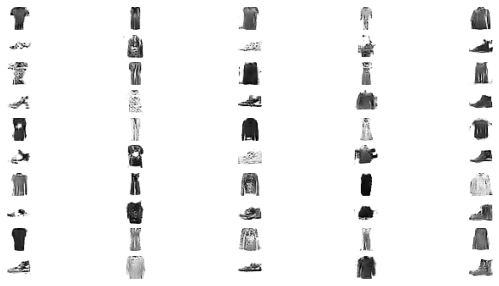

Epoch: 11 Batch 0 Loss fake: 0.388 Real: 0.427 GAN: 1.813 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.100
Epoch: 11 Batch 1 Loss fake: 0.354 Real: 0.400 GAN: 2.176 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.090
Epoch: 11 Batch 2 Loss fake: 0.235 Real: 0.335 GAN: 2.094 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.120
Epoch: 11 Batch 3 Loss fake: 0.294 Real: 0.328 GAN: 2.113 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.070
Epoch: 11 Batch 4 Loss fake: 0.363 Real: 0.568 GAN: 2.175 	 Accuracy fake: 0.875 Real: 0.672 GAN: 0.100
Epoch: 11 Batch 5 Loss fake: 0.229 Real: 0.384 GAN: 1.931 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.120
Epoch: 11 Batch 6 Loss fake: 0.423 Real: 0.374 GAN: 1.935 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.130
Epoch: 11 Batch 7 Loss fake: 0.427 Real: 0.346 GAN: 2.126 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.020
Epoch: 11 Batch 8 Loss fake: 0.310 Real: 0.463 GAN: 1.809 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.120
Epoch: 11 Batch 9 Loss fake: 0.337 Real: 0.282 GAN: 1.837 	 Accu

Epoch: 11 Batch 79 Loss fake: 0.375 Real: 0.556 GAN: 1.989 	 Accuracy fake: 0.859 Real: 0.719 GAN: 0.110
Epoch: 11 Batch 80 Loss fake: 0.291 Real: 0.419 GAN: 2.034 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.120
Epoch: 11 Batch 81 Loss fake: 0.346 Real: 0.319 GAN: 1.663 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.170
Epoch: 11 Batch 82 Loss fake: 0.418 Real: 0.351 GAN: 2.096 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.040
Epoch: 11 Batch 83 Loss fake: 0.318 Real: 0.378 GAN: 1.981 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.130
Epoch: 11 Batch 84 Loss fake: 0.321 Real: 0.438 GAN: 1.853 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.160
Epoch: 11 Batch 85 Loss fake: 0.377 Real: 0.344 GAN: 1.995 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.130
Epoch: 11 Batch 86 Loss fake: 0.261 Real: 0.405 GAN: 2.103 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.110
Epoch: 11 Batch 87 Loss fake: 0.352 Real: 0.323 GAN: 1.971 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.100
Epoch: 11 Batch 88 Loss fake: 0.376 Real: 0.347 GAN: 2.

Epoch: 11 Batch 157 Loss fake: 0.313 Real: 0.530 GAN: 1.785 	 Accuracy fake: 0.875 Real: 0.703 GAN: 0.110
Epoch: 11 Batch 158 Loss fake: 0.390 Real: 0.308 GAN: 1.957 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.140
Epoch: 11 Batch 159 Loss fake: 0.400 Real: 0.402 GAN: 1.934 	 Accuracy fake: 0.766 Real: 0.766 GAN: 0.090
Epoch: 11 Batch 160 Loss fake: 0.293 Real: 0.377 GAN: 2.125 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.110
Epoch: 11 Batch 161 Loss fake: 0.251 Real: 0.411 GAN: 1.753 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.140
Epoch: 11 Batch 162 Loss fake: 0.358 Real: 0.250 GAN: 1.884 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.090
Epoch: 11 Batch 163 Loss fake: 0.313 Real: 0.301 GAN: 1.784 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.100
Epoch: 11 Batch 164 Loss fake: 0.295 Real: 0.325 GAN: 2.055 	 Accuracy fake: 0.875 Real: 0.891 GAN: 0.050
Epoch: 11 Batch 165 Loss fake: 0.305 Real: 0.412 GAN: 1.884 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 11 Batch 166 Loss fake: 0.365 Real: 0.3

Epoch: 11 Batch 235 Loss fake: 0.358 Real: 0.281 GAN: 1.967 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.120
Epoch: 11 Batch 236 Loss fake: 0.337 Real: 0.377 GAN: 1.887 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.060
Epoch: 11 Batch 237 Loss fake: 0.333 Real: 0.488 GAN: 2.015 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.050
Epoch: 11 Batch 238 Loss fake: 0.359 Real: 0.396 GAN: 1.722 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.140
Epoch: 11 Batch 239 Loss fake: 0.348 Real: 0.441 GAN: 1.907 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.110
Epoch: 11 Batch 240 Loss fake: 0.297 Real: 0.353 GAN: 1.982 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.100
Epoch: 11 Batch 241 Loss fake: 0.272 Real: 0.380 GAN: 1.755 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.220
Epoch: 11 Batch 242 Loss fake: 0.317 Real: 0.371 GAN: 1.731 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.150
Epoch: 11 Batch 243 Loss fake: 0.513 Real: 0.446 GAN: 1.996 	 Accuracy fake: 0.781 Real: 0.766 GAN: 0.100
Epoch: 11 Batch 244 Loss fake: 0.357 Real: 0.5

Epoch: 11 Batch 313 Loss fake: 0.272 Real: 0.512 GAN: 1.952 	 Accuracy fake: 0.953 Real: 0.766 GAN: 0.070
Epoch: 11 Batch 314 Loss fake: 0.368 Real: 0.318 GAN: 1.451 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.170
Epoch: 11 Batch 315 Loss fake: 0.383 Real: 0.302 GAN: 1.857 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.110
Epoch: 11 Batch 316 Loss fake: 0.283 Real: 0.383 GAN: 1.849 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.110
Epoch: 11 Batch 317 Loss fake: 0.374 Real: 0.325 GAN: 1.762 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.160
Epoch: 11 Batch 318 Loss fake: 0.308 Real: 0.450 GAN: 1.885 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.150
Epoch: 11 Batch 319 Loss fake: 0.370 Real: 0.329 GAN: 1.817 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.120
Epoch: 11 Batch 320 Loss fake: 0.442 Real: 0.383 GAN: 1.956 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.100
Epoch: 11 Batch 321 Loss fake: 0.346 Real: 0.419 GAN: 2.053 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.130
Epoch: 11 Batch 322 Loss fake: 0.194 Real: 0.5

Epoch: 11 Batch 391 Loss fake: 0.464 Real: 0.369 GAN: 1.528 	 Accuracy fake: 0.781 Real: 0.828 GAN: 0.110
Epoch: 11 Batch 392 Loss fake: 0.368 Real: 0.354 GAN: 1.837 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.080
Epoch: 11 Batch 393 Loss fake: 0.348 Real: 0.363 GAN: 1.900 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.060
Epoch: 11 Batch 394 Loss fake: 0.298 Real: 0.408 GAN: 1.770 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.160
Epoch: 11 Batch 395 Loss fake: 0.378 Real: 0.348 GAN: 1.638 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.150
Epoch: 11 Batch 396 Loss fake: 0.430 Real: 0.365 GAN: 2.089 	 Accuracy fake: 0.766 Real: 0.812 GAN: 0.130
Epoch: 11 Batch 397 Loss fake: 0.297 Real: 0.516 GAN: 1.850 	 Accuracy fake: 0.922 Real: 0.719 GAN: 0.080
Epoch: 11 Batch 398 Loss fake: 0.339 Real: 0.313 GAN: 1.769 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.150
Epoch: 11 Batch 399 Loss fake: 0.329 Real: 0.397 GAN: 1.751 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.200
Epoch: 11 Batch 400 Loss fake: 0.421 Real: 0.4

Epoch: 12 Batch 1 Loss fake: 0.361 Real: 0.514 GAN: 1.929 	 Accuracy fake: 0.859 Real: 0.719 GAN: 0.150
Epoch: 12 Batch 2 Loss fake: 0.380 Real: 0.427 GAN: 1.879 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.090
Epoch: 12 Batch 3 Loss fake: 0.297 Real: 0.385 GAN: 1.905 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.110
Epoch: 12 Batch 4 Loss fake: 0.273 Real: 0.289 GAN: 1.839 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.070
Epoch: 12 Batch 5 Loss fake: 0.233 Real: 0.447 GAN: 1.869 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.050
Epoch: 12 Batch 6 Loss fake: 0.333 Real: 0.508 GAN: 1.739 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.190
Epoch: 12 Batch 7 Loss fake: 0.364 Real: 0.292 GAN: 1.686 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.150
Epoch: 12 Batch 8 Loss fake: 0.420 Real: 0.379 GAN: 1.881 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.100
Epoch: 12 Batch 9 Loss fake: 0.298 Real: 0.473 GAN: 1.790 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.200
Epoch: 12 Batch 10 Loss fake: 0.407 Real: 0.301 GAN: 1.843 	 Acc

Epoch: 12 Batch 80 Loss fake: 0.241 Real: 0.357 GAN: 1.756 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.190
Epoch: 12 Batch 81 Loss fake: 0.422 Real: 0.362 GAN: 1.905 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.100
Epoch: 12 Batch 82 Loss fake: 0.284 Real: 0.445 GAN: 1.858 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.140
Epoch: 12 Batch 83 Loss fake: 0.291 Real: 0.265 GAN: 1.781 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.140
Epoch: 12 Batch 84 Loss fake: 0.264 Real: 0.459 GAN: 1.569 	 Accuracy fake: 0.922 Real: 0.734 GAN: 0.210
Epoch: 12 Batch 85 Loss fake: 0.431 Real: 0.431 GAN: 1.802 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.160
Epoch: 12 Batch 86 Loss fake: 0.346 Real: 0.323 GAN: 1.817 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.120
Epoch: 12 Batch 87 Loss fake: 0.310 Real: 0.440 GAN: 1.749 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.150
Epoch: 12 Batch 88 Loss fake: 0.472 Real: 0.427 GAN: 1.858 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.100
Epoch: 12 Batch 89 Loss fake: 0.377 Real: 0.553 GAN: 1.

Epoch: 12 Batch 158 Loss fake: 0.284 Real: 0.494 GAN: 1.966 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.080
Epoch: 12 Batch 159 Loss fake: 0.234 Real: 0.307 GAN: 1.859 	 Accuracy fake: 0.969 Real: 0.844 GAN: 0.100
Epoch: 12 Batch 160 Loss fake: 0.379 Real: 0.452 GAN: 1.880 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.120
Epoch: 12 Batch 161 Loss fake: 0.323 Real: 0.381 GAN: 1.944 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.150
Epoch: 12 Batch 162 Loss fake: 0.499 Real: 0.450 GAN: 1.936 	 Accuracy fake: 0.750 Real: 0.781 GAN: 0.100
Epoch: 12 Batch 163 Loss fake: 0.326 Real: 0.411 GAN: 1.857 	 Accuracy fake: 0.828 Real: 0.734 GAN: 0.100
Epoch: 12 Batch 164 Loss fake: 0.266 Real: 0.449 GAN: 1.625 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.170
Epoch: 12 Batch 165 Loss fake: 0.542 Real: 0.403 GAN: 1.989 	 Accuracy fake: 0.750 Real: 0.781 GAN: 0.090
Epoch: 12 Batch 166 Loss fake: 0.430 Real: 0.489 GAN: 1.841 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.060
Epoch: 12 Batch 167 Loss fake: 0.371 Real: 0.4

Epoch: 12 Batch 236 Loss fake: 0.303 Real: 0.420 GAN: 1.813 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.100
Epoch: 12 Batch 237 Loss fake: 0.300 Real: 0.202 GAN: 1.938 	 Accuracy fake: 0.875 Real: 0.922 GAN: 0.160
Epoch: 12 Batch 238 Loss fake: 0.384 Real: 0.617 GAN: 2.116 	 Accuracy fake: 0.875 Real: 0.641 GAN: 0.080
Epoch: 12 Batch 239 Loss fake: 0.223 Real: 0.433 GAN: 1.757 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.120
Epoch: 12 Batch 240 Loss fake: 0.363 Real: 0.318 GAN: 1.388 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.210
Epoch: 12 Batch 241 Loss fake: 0.394 Real: 0.438 GAN: 1.821 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.090
Epoch: 12 Batch 242 Loss fake: 0.281 Real: 0.338 GAN: 1.736 	 Accuracy fake: 0.969 Real: 0.875 GAN: 0.090
Epoch: 12 Batch 243 Loss fake: 0.355 Real: 0.367 GAN: 1.743 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.120
Epoch: 12 Batch 244 Loss fake: 0.316 Real: 0.269 GAN: 1.654 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.190
Epoch: 12 Batch 245 Loss fake: 0.374 Real: 0.3

Epoch: 12 Batch 314 Loss fake: 0.310 Real: 0.362 GAN: 1.814 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.100
Epoch: 12 Batch 315 Loss fake: 0.370 Real: 0.579 GAN: 1.540 	 Accuracy fake: 0.859 Real: 0.688 GAN: 0.180
Epoch: 12 Batch 316 Loss fake: 0.321 Real: 0.284 GAN: 1.616 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.130
Epoch: 12 Batch 317 Loss fake: 0.426 Real: 0.348 GAN: 1.680 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.140
Epoch: 12 Batch 318 Loss fake: 0.332 Real: 0.405 GAN: 1.984 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.130
Epoch: 12 Batch 319 Loss fake: 0.475 Real: 0.336 GAN: 2.131 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.070
Epoch: 12 Batch 320 Loss fake: 0.318 Real: 0.465 GAN: 1.669 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.180
Epoch: 12 Batch 321 Loss fake: 0.367 Real: 0.462 GAN: 1.806 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.130
Epoch: 12 Batch 322 Loss fake: 0.433 Real: 0.371 GAN: 1.737 	 Accuracy fake: 0.797 Real: 0.812 GAN: 0.160
Epoch: 12 Batch 323 Loss fake: 0.348 Real: 0.5

Epoch: 12 Batch 392 Loss fake: 0.341 Real: 0.333 GAN: 1.786 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.130
Epoch: 12 Batch 393 Loss fake: 0.475 Real: 0.547 GAN: 1.902 	 Accuracy fake: 0.844 Real: 0.703 GAN: 0.120
Epoch: 12 Batch 394 Loss fake: 0.349 Real: 0.367 GAN: 1.859 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.110
Epoch: 12 Batch 395 Loss fake: 0.448 Real: 0.417 GAN: 2.017 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.100
Epoch: 12 Batch 396 Loss fake: 0.402 Real: 0.491 GAN: 1.851 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.150
Epoch: 12 Batch 397 Loss fake: 0.383 Real: 0.296 GAN: 1.787 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.100
Epoch: 12 Batch 398 Loss fake: 0.324 Real: 0.328 GAN: 1.803 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.090
Epoch: 12 Batch 399 Loss fake: 0.267 Real: 0.461 GAN: 1.953 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.080
Epoch: 12 Batch 400 Loss fake: 0.271 Real: 0.383 GAN: 1.737 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.140
Epoch: 12 Batch 401 Loss fake: 0.292 Real: 0.3

Epoch: 13 Batch 2 Loss fake: 0.478 Real: 0.501 GAN: 1.724 	 Accuracy fake: 0.781 Real: 0.781 GAN: 0.110
Epoch: 13 Batch 3 Loss fake: 0.420 Real: 0.392 GAN: 1.800 	 Accuracy fake: 0.797 Real: 0.781 GAN: 0.090
Epoch: 13 Batch 4 Loss fake: 0.316 Real: 0.471 GAN: 1.744 	 Accuracy fake: 0.891 Real: 0.703 GAN: 0.120
Epoch: 13 Batch 5 Loss fake: 0.405 Real: 0.496 GAN: 1.853 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.110
Epoch: 13 Batch 6 Loss fake: 0.277 Real: 0.435 GAN: 1.629 	 Accuracy fake: 0.969 Real: 0.812 GAN: 0.180
Epoch: 13 Batch 7 Loss fake: 0.365 Real: 0.431 GAN: 1.516 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.230
Epoch: 13 Batch 8 Loss fake: 0.441 Real: 0.338 GAN: 1.625 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.180
Epoch: 13 Batch 9 Loss fake: 0.446 Real: 0.444 GAN: 1.880 	 Accuracy fake: 0.766 Real: 0.766 GAN: 0.080
Epoch: 13 Batch 10 Loss fake: 0.267 Real: 0.458 GAN: 1.619 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.140
Epoch: 13 Batch 11 Loss fake: 0.381 Real: 0.368 GAN: 1.852 	 Ac

Epoch: 13 Batch 81 Loss fake: 0.440 Real: 0.355 GAN: 1.846 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.130
Epoch: 13 Batch 82 Loss fake: 0.321 Real: 0.475 GAN: 1.663 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.170
Epoch: 13 Batch 83 Loss fake: 0.377 Real: 0.326 GAN: 1.750 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.150
Epoch: 13 Batch 84 Loss fake: 0.416 Real: 0.431 GAN: 2.016 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.150
Epoch: 13 Batch 85 Loss fake: 0.370 Real: 0.403 GAN: 2.028 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.080
Epoch: 13 Batch 86 Loss fake: 0.306 Real: 0.441 GAN: 1.802 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.110
Epoch: 13 Batch 87 Loss fake: 0.281 Real: 0.354 GAN: 1.771 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.230
Epoch: 13 Batch 88 Loss fake: 0.357 Real: 0.310 GAN: 1.671 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.190
Epoch: 13 Batch 89 Loss fake: 0.382 Real: 0.391 GAN: 1.875 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.090
Epoch: 13 Batch 90 Loss fake: 0.335 Real: 0.317 GAN: 2.

Epoch: 13 Batch 159 Loss fake: 0.351 Real: 0.511 GAN: 1.680 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.170
Epoch: 13 Batch 160 Loss fake: 0.372 Real: 0.497 GAN: 1.802 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.100
Epoch: 13 Batch 161 Loss fake: 0.328 Real: 0.333 GAN: 1.823 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.120
Epoch: 13 Batch 162 Loss fake: 0.374 Real: 0.383 GAN: 1.807 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.170
Epoch: 13 Batch 163 Loss fake: 0.399 Real: 0.425 GAN: 2.050 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.130
Epoch: 13 Batch 164 Loss fake: 0.285 Real: 0.402 GAN: 1.780 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.150
Epoch: 13 Batch 165 Loss fake: 0.334 Real: 0.483 GAN: 1.621 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.190
Epoch: 13 Batch 166 Loss fake: 0.383 Real: 0.373 GAN: 1.837 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.090
Epoch: 13 Batch 167 Loss fake: 0.449 Real: 0.278 GAN: 2.032 	 Accuracy fake: 0.781 Real: 0.891 GAN: 0.090
Epoch: 13 Batch 168 Loss fake: 0.362 Real: 0.5

Epoch: 13 Batch 237 Loss fake: 0.306 Real: 0.286 GAN: 1.826 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.110
Epoch: 13 Batch 238 Loss fake: 0.328 Real: 0.386 GAN: 2.032 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.130
Epoch: 13 Batch 239 Loss fake: 0.390 Real: 0.316 GAN: 1.750 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.140
Epoch: 13 Batch 240 Loss fake: 0.264 Real: 0.424 GAN: 1.903 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.120
Epoch: 13 Batch 241 Loss fake: 0.283 Real: 0.536 GAN: 1.813 	 Accuracy fake: 0.891 Real: 0.703 GAN: 0.140
Epoch: 13 Batch 242 Loss fake: 0.401 Real: 0.266 GAN: 1.938 	 Accuracy fake: 0.797 Real: 0.875 GAN: 0.160
Epoch: 13 Batch 243 Loss fake: 0.325 Real: 0.345 GAN: 2.061 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.080
Epoch: 13 Batch 244 Loss fake: 0.322 Real: 0.451 GAN: 1.970 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.100
Epoch: 13 Batch 245 Loss fake: 0.323 Real: 0.445 GAN: 1.904 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.120
Epoch: 13 Batch 246 Loss fake: 0.487 Real: 0.4

Epoch: 13 Batch 315 Loss fake: 0.415 Real: 0.349 GAN: 1.948 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.150
Epoch: 13 Batch 316 Loss fake: 0.349 Real: 0.479 GAN: 2.030 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.100
Epoch: 13 Batch 317 Loss fake: 0.345 Real: 0.477 GAN: 1.952 	 Accuracy fake: 0.906 Real: 0.703 GAN: 0.110
Epoch: 13 Batch 318 Loss fake: 0.377 Real: 0.272 GAN: 1.897 	 Accuracy fake: 0.875 Real: 0.922 GAN: 0.120
Epoch: 13 Batch 319 Loss fake: 0.308 Real: 0.335 GAN: 1.631 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.160
Epoch: 13 Batch 320 Loss fake: 0.358 Real: 0.583 GAN: 1.721 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.110
Epoch: 13 Batch 321 Loss fake: 0.332 Real: 0.234 GAN: 1.719 	 Accuracy fake: 0.859 Real: 0.922 GAN: 0.170
Epoch: 13 Batch 322 Loss fake: 0.397 Real: 0.423 GAN: 2.213 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.050
Epoch: 13 Batch 323 Loss fake: 0.313 Real: 0.403 GAN: 2.096 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.130
Epoch: 13 Batch 324 Loss fake: 0.333 Real: 0.3

Epoch: 13 Batch 393 Loss fake: 0.539 Real: 0.310 GAN: 1.769 	 Accuracy fake: 0.734 Real: 0.828 GAN: 0.180
Epoch: 13 Batch 394 Loss fake: 0.442 Real: 0.413 GAN: 1.905 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.080
Epoch: 13 Batch 395 Loss fake: 0.295 Real: 0.427 GAN: 1.753 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 13 Batch 396 Loss fake: 0.230 Real: 0.358 GAN: 1.776 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.120
Epoch: 13 Batch 397 Loss fake: 0.468 Real: 0.326 GAN: 1.829 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.130
Epoch: 13 Batch 398 Loss fake: 0.226 Real: 0.521 GAN: 1.654 	 Accuracy fake: 0.953 Real: 0.734 GAN: 0.170
Epoch: 13 Batch 399 Loss fake: 0.438 Real: 0.241 GAN: 1.996 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.080
Epoch: 13 Batch 400 Loss fake: 0.384 Real: 0.385 GAN: 2.073 	 Accuracy fake: 0.781 Real: 0.828 GAN: 0.070
Epoch: 13 Batch 401 Loss fake: 0.368 Real: 0.275 GAN: 2.122 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.080
Epoch: 13 Batch 402 Loss fake: 0.266 Real: 0.5

Epoch: 14 Batch 3 Loss fake: 0.335 Real: 0.419 GAN: 2.011 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.090
Epoch: 14 Batch 4 Loss fake: 0.341 Real: 0.519 GAN: 1.752 	 Accuracy fake: 0.859 Real: 0.719 GAN: 0.170
Epoch: 14 Batch 5 Loss fake: 0.330 Real: 0.433 GAN: 1.871 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.080
Epoch: 14 Batch 6 Loss fake: 0.314 Real: 0.363 GAN: 1.575 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.160
Epoch: 14 Batch 7 Loss fake: 0.470 Real: 0.358 GAN: 1.680 	 Accuracy fake: 0.750 Real: 0.797 GAN: 0.140
Epoch: 14 Batch 8 Loss fake: 0.449 Real: 0.614 GAN: 1.691 	 Accuracy fake: 0.828 Real: 0.672 GAN: 0.160
Epoch: 14 Batch 9 Loss fake: 0.421 Real: 0.378 GAN: 1.728 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.120
Epoch: 14 Batch 10 Loss fake: 0.340 Real: 0.392 GAN: 1.937 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.140
Epoch: 14 Batch 11 Loss fake: 0.344 Real: 0.258 GAN: 2.179 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.080
Epoch: 14 Batch 12 Loss fake: 0.451 Real: 0.390 GAN: 1.939 	 A

Epoch: 14 Batch 82 Loss fake: 0.296 Real: 0.346 GAN: 1.709 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.140
Epoch: 14 Batch 83 Loss fake: 0.452 Real: 0.324 GAN: 1.854 	 Accuracy fake: 0.734 Real: 0.844 GAN: 0.160
Epoch: 14 Batch 84 Loss fake: 0.342 Real: 0.575 GAN: 1.946 	 Accuracy fake: 0.844 Real: 0.656 GAN: 0.120
Epoch: 14 Batch 85 Loss fake: 0.372 Real: 0.312 GAN: 1.999 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.100
Epoch: 14 Batch 86 Loss fake: 0.337 Real: 0.521 GAN: 1.890 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.100
Epoch: 14 Batch 87 Loss fake: 0.483 Real: 0.214 GAN: 1.939 	 Accuracy fake: 0.766 Real: 0.922 GAN: 0.100
Epoch: 14 Batch 88 Loss fake: 0.354 Real: 0.506 GAN: 2.014 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.130
Epoch: 14 Batch 89 Loss fake: 0.327 Real: 0.507 GAN: 1.923 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.120
Epoch: 14 Batch 90 Loss fake: 0.394 Real: 0.455 GAN: 1.610 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.180
Epoch: 14 Batch 91 Loss fake: 0.260 Real: 0.207 GAN: 1.

Epoch: 14 Batch 160 Loss fake: 0.394 Real: 0.401 GAN: 1.985 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.120
Epoch: 14 Batch 161 Loss fake: 0.411 Real: 0.428 GAN: 2.192 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.100
Epoch: 14 Batch 162 Loss fake: 0.310 Real: 0.442 GAN: 1.835 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.090
Epoch: 14 Batch 163 Loss fake: 0.344 Real: 0.356 GAN: 1.803 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.150
Epoch: 14 Batch 164 Loss fake: 0.339 Real: 0.383 GAN: 1.764 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.130
Epoch: 14 Batch 165 Loss fake: 0.443 Real: 0.395 GAN: 1.742 	 Accuracy fake: 0.797 Real: 0.812 GAN: 0.100
Epoch: 14 Batch 166 Loss fake: 0.341 Real: 0.393 GAN: 1.795 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.140
Epoch: 14 Batch 167 Loss fake: 0.305 Real: 0.397 GAN: 1.781 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.170
Epoch: 14 Batch 168 Loss fake: 0.407 Real: 0.353 GAN: 1.756 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.150
Epoch: 14 Batch 169 Loss fake: 0.342 Real: 0.5

Epoch: 14 Batch 238 Loss fake: 0.271 Real: 0.360 GAN: 1.717 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.140
Epoch: 14 Batch 239 Loss fake: 0.415 Real: 0.333 GAN: 2.052 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.080
Epoch: 14 Batch 240 Loss fake: 0.326 Real: 0.443 GAN: 1.765 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.130
Epoch: 14 Batch 241 Loss fake: 0.435 Real: 0.485 GAN: 1.942 	 Accuracy fake: 0.812 Real: 0.750 GAN: 0.090
Epoch: 14 Batch 242 Loss fake: 0.198 Real: 0.376 GAN: 1.851 	 Accuracy fake: 0.984 Real: 0.812 GAN: 0.130
Epoch: 14 Batch 243 Loss fake: 0.403 Real: 0.354 GAN: 1.927 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.090
Epoch: 14 Batch 244 Loss fake: 0.445 Real: 0.368 GAN: 1.826 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.190
Epoch: 14 Batch 245 Loss fake: 0.343 Real: 0.550 GAN: 1.701 	 Accuracy fake: 0.859 Real: 0.703 GAN: 0.190
Epoch: 14 Batch 246 Loss fake: 0.383 Real: 0.257 GAN: 1.781 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.140
Epoch: 14 Batch 247 Loss fake: 0.316 Real: 0.2

Epoch: 14 Batch 316 Loss fake: 0.384 Real: 0.377 GAN: 1.857 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.160
Epoch: 14 Batch 317 Loss fake: 0.300 Real: 0.418 GAN: 1.826 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.110
Epoch: 14 Batch 318 Loss fake: 0.327 Real: 0.342 GAN: 1.687 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.170
Epoch: 14 Batch 319 Loss fake: 0.444 Real: 0.201 GAN: 2.172 	 Accuracy fake: 0.797 Real: 0.938 GAN: 0.100
Epoch: 14 Batch 320 Loss fake: 0.229 Real: 0.471 GAN: 2.086 	 Accuracy fake: 0.938 Real: 0.703 GAN: 0.090
Epoch: 14 Batch 321 Loss fake: 0.380 Real: 0.319 GAN: 1.885 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.120
Epoch: 14 Batch 322 Loss fake: 0.407 Real: 0.635 GAN: 2.035 	 Accuracy fake: 0.812 Real: 0.703 GAN: 0.070
Epoch: 14 Batch 323 Loss fake: 0.292 Real: 0.499 GAN: 1.697 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.130
Epoch: 14 Batch 324 Loss fake: 0.331 Real: 0.400 GAN: 1.589 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.200
Epoch: 14 Batch 325 Loss fake: 0.469 Real: 0.4

Epoch: 14 Batch 394 Loss fake: 0.454 Real: 0.369 GAN: 1.880 	 Accuracy fake: 0.781 Real: 0.766 GAN: 0.090
Epoch: 14 Batch 395 Loss fake: 0.429 Real: 0.616 GAN: 1.967 	 Accuracy fake: 0.797 Real: 0.734 GAN: 0.100
Epoch: 14 Batch 396 Loss fake: 0.284 Real: 0.261 GAN: 1.895 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.120
Epoch: 14 Batch 397 Loss fake: 0.301 Real: 0.421 GAN: 1.855 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.140
Epoch: 14 Batch 398 Loss fake: 0.429 Real: 0.352 GAN: 1.999 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.140
Epoch: 14 Batch 399 Loss fake: 0.307 Real: 0.388 GAN: 2.069 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.140
Epoch: 14 Batch 400 Loss fake: 0.355 Real: 0.398 GAN: 2.027 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.120
Epoch: 14 Batch 401 Loss fake: 0.326 Real: 0.553 GAN: 1.775 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.150
Epoch: 14 Batch 402 Loss fake: 0.368 Real: 0.366 GAN: 1.868 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.160
Epoch: 14 Batch 403 Loss fake: 0.316 Real: 0.3

Epoch: 15 Batch 4 Loss fake: 0.372 Real: 0.368 GAN: 1.679 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.160
Epoch: 15 Batch 5 Loss fake: 0.464 Real: 0.421 GAN: 1.905 	 Accuracy fake: 0.781 Real: 0.781 GAN: 0.070
Epoch: 15 Batch 6 Loss fake: 0.331 Real: 0.344 GAN: 1.988 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.120
Epoch: 15 Batch 7 Loss fake: 0.441 Real: 0.405 GAN: 1.733 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.160
Epoch: 15 Batch 8 Loss fake: 0.305 Real: 0.384 GAN: 1.928 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.120
Epoch: 15 Batch 9 Loss fake: 0.354 Real: 0.367 GAN: 1.532 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.220
Epoch: 15 Batch 10 Loss fake: 0.415 Real: 0.446 GAN: 1.954 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.110
Epoch: 15 Batch 11 Loss fake: 0.268 Real: 0.409 GAN: 1.722 	 Accuracy fake: 0.953 Real: 0.781 GAN: 0.090
Epoch: 15 Batch 12 Loss fake: 0.483 Real: 0.370 GAN: 1.954 	 Accuracy fake: 0.781 Real: 0.828 GAN: 0.120
Epoch: 15 Batch 13 Loss fake: 0.374 Real: 0.568 GAN: 1.895 	 

Epoch: 15 Batch 83 Loss fake: 0.428 Real: 0.417 GAN: 1.647 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.180
Epoch: 15 Batch 84 Loss fake: 0.440 Real: 0.452 GAN: 2.029 	 Accuracy fake: 0.750 Real: 0.734 GAN: 0.150
Epoch: 15 Batch 85 Loss fake: 0.360 Real: 0.443 GAN: 1.929 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.120
Epoch: 15 Batch 86 Loss fake: 0.386 Real: 0.501 GAN: 1.722 	 Accuracy fake: 0.797 Real: 0.719 GAN: 0.170
Epoch: 15 Batch 87 Loss fake: 0.339 Real: 0.537 GAN: 1.474 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.220
Epoch: 15 Batch 88 Loss fake: 0.354 Real: 0.235 GAN: 1.531 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.240
Epoch: 15 Batch 89 Loss fake: 0.425 Real: 0.292 GAN: 1.795 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.190
Epoch: 15 Batch 90 Loss fake: 0.470 Real: 0.433 GAN: 1.875 	 Accuracy fake: 0.750 Real: 0.766 GAN: 0.140
Epoch: 15 Batch 91 Loss fake: 0.302 Real: 0.487 GAN: 1.930 	 Accuracy fake: 0.922 Real: 0.688 GAN: 0.090
Epoch: 15 Batch 92 Loss fake: 0.278 Real: 0.273 GAN: 1.

Epoch: 15 Batch 161 Loss fake: 0.303 Real: 0.265 GAN: 1.708 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.160
Epoch: 15 Batch 162 Loss fake: 0.387 Real: 0.298 GAN: 2.012 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.080
Epoch: 15 Batch 163 Loss fake: 0.343 Real: 0.429 GAN: 1.959 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.090
Epoch: 15 Batch 164 Loss fake: 0.287 Real: 0.530 GAN: 1.709 	 Accuracy fake: 0.891 Real: 0.625 GAN: 0.130
Epoch: 15 Batch 165 Loss fake: 0.265 Real: 0.306 GAN: 1.726 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.180
Epoch: 15 Batch 166 Loss fake: 0.452 Real: 0.363 GAN: 2.007 	 Accuracy fake: 0.781 Real: 0.859 GAN: 0.140
Epoch: 15 Batch 167 Loss fake: 0.278 Real: 0.398 GAN: 1.856 	 Accuracy fake: 0.969 Real: 0.750 GAN: 0.150
Epoch: 15 Batch 168 Loss fake: 0.310 Real: 0.418 GAN: 1.756 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.110
Epoch: 15 Batch 169 Loss fake: 0.351 Real: 0.295 GAN: 1.637 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.160
Epoch: 15 Batch 170 Loss fake: 0.384 Real: 0.4

Epoch: 15 Batch 239 Loss fake: 0.401 Real: 0.316 GAN: 1.726 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.130
Epoch: 15 Batch 240 Loss fake: 0.393 Real: 0.409 GAN: 1.722 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.100
Epoch: 15 Batch 241 Loss fake: 0.421 Real: 0.362 GAN: 1.921 	 Accuracy fake: 0.781 Real: 0.797 GAN: 0.140
Epoch: 15 Batch 242 Loss fake: 0.406 Real: 0.391 GAN: 2.070 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.090
Epoch: 15 Batch 243 Loss fake: 0.352 Real: 0.559 GAN: 1.899 	 Accuracy fake: 0.891 Real: 0.641 GAN: 0.150
Epoch: 15 Batch 244 Loss fake: 0.441 Real: 0.408 GAN: 1.953 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.140
Epoch: 15 Batch 245 Loss fake: 0.351 Real: 0.396 GAN: 1.999 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.110
Epoch: 15 Batch 246 Loss fake: 0.337 Real: 0.466 GAN: 1.753 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.210
Epoch: 15 Batch 247 Loss fake: 0.379 Real: 0.234 GAN: 1.548 	 Accuracy fake: 0.906 Real: 0.938 GAN: 0.150
Epoch: 15 Batch 248 Loss fake: 0.371 Real: 0.4

Epoch: 15 Batch 317 Loss fake: 0.326 Real: 0.420 GAN: 1.764 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.160
Epoch: 15 Batch 318 Loss fake: 0.390 Real: 0.586 GAN: 2.022 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.080
Epoch: 15 Batch 319 Loss fake: 0.458 Real: 0.552 GAN: 1.732 	 Accuracy fake: 0.812 Real: 0.688 GAN: 0.190
Epoch: 15 Batch 320 Loss fake: 0.331 Real: 0.314 GAN: 1.753 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.140
Epoch: 15 Batch 321 Loss fake: 0.526 Real: 0.474 GAN: 1.857 	 Accuracy fake: 0.750 Real: 0.766 GAN: 0.100
Epoch: 15 Batch 322 Loss fake: 0.277 Real: 0.375 GAN: 2.137 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.090
Epoch: 15 Batch 323 Loss fake: 0.316 Real: 0.460 GAN: 1.769 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.090
Epoch: 15 Batch 324 Loss fake: 0.334 Real: 0.336 GAN: 1.542 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.190
Epoch: 15 Batch 325 Loss fake: 0.509 Real: 0.280 GAN: 1.769 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.140
Epoch: 15 Batch 326 Loss fake: 0.344 Real: 0.5

Epoch: 15 Batch 395 Loss fake: 0.354 Real: 0.624 GAN: 1.927 	 Accuracy fake: 0.844 Real: 0.672 GAN: 0.060
Epoch: 15 Batch 396 Loss fake: 0.237 Real: 0.309 GAN: 1.610 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.200
Epoch: 15 Batch 397 Loss fake: 0.369 Real: 0.422 GAN: 1.827 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.100
Epoch: 15 Batch 398 Loss fake: 0.364 Real: 0.359 GAN: 1.778 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.200
Epoch: 15 Batch 399 Loss fake: 0.363 Real: 0.324 GAN: 1.811 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.070
Epoch: 15 Batch 400 Loss fake: 0.429 Real: 0.449 GAN: 1.733 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.160
Epoch: 15 Batch 401 Loss fake: 0.304 Real: 0.447 GAN: 1.735 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.150
Epoch: 15 Batch 402 Loss fake: 0.492 Real: 0.549 GAN: 1.740 	 Accuracy fake: 0.797 Real: 0.688 GAN: 0.160
Epoch: 15 Batch 403 Loss fake: 0.303 Real: 0.486 GAN: 1.664 	 Accuracy fake: 0.891 Real: 0.688 GAN: 0.150
Epoch: 15 Batch 404 Loss fake: 0.412 Real: 0.3

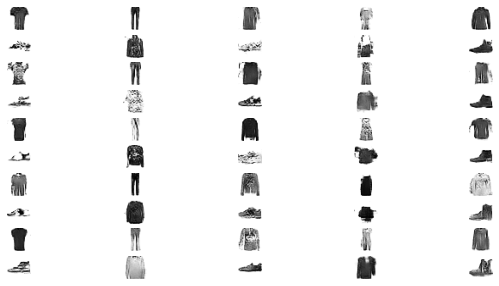

Epoch: 16 Batch 0 Loss fake: 0.462 Real: 0.359 GAN: 1.957 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.120
Epoch: 16 Batch 1 Loss fake: 0.334 Real: 0.454 GAN: 2.077 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.120
Epoch: 16 Batch 2 Loss fake: 0.358 Real: 0.331 GAN: 1.873 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 16 Batch 3 Loss fake: 0.315 Real: 0.517 GAN: 1.886 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.140
Epoch: 16 Batch 4 Loss fake: 0.300 Real: 0.536 GAN: 1.577 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.160
Epoch: 16 Batch 5 Loss fake: 0.453 Real: 0.329 GAN: 1.514 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.210
Epoch: 16 Batch 6 Loss fake: 0.466 Real: 0.351 GAN: 1.990 	 Accuracy fake: 0.766 Real: 0.781 GAN: 0.150
Epoch: 16 Batch 7 Loss fake: 0.384 Real: 0.401 GAN: 2.242 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.070
Epoch: 16 Batch 8 Loss fake: 0.348 Real: 0.633 GAN: 1.988 	 Accuracy fake: 0.906 Real: 0.656 GAN: 0.070
Epoch: 16 Batch 9 Loss fake: 0.317 Real: 0.337 GAN: 1.648 	 Accu

Epoch: 16 Batch 79 Loss fake: 0.276 Real: 0.270 GAN: 1.986 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.090
Epoch: 16 Batch 80 Loss fake: 0.450 Real: 0.538 GAN: 1.952 	 Accuracy fake: 0.766 Real: 0.703 GAN: 0.160
Epoch: 16 Batch 81 Loss fake: 0.310 Real: 0.510 GAN: 1.798 	 Accuracy fake: 0.875 Real: 0.688 GAN: 0.100
Epoch: 16 Batch 82 Loss fake: 0.357 Real: 0.344 GAN: 1.695 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.160
Epoch: 16 Batch 83 Loss fake: 0.327 Real: 0.274 GAN: 1.849 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.190
Epoch: 16 Batch 84 Loss fake: 0.400 Real: 0.369 GAN: 1.925 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.170
Epoch: 16 Batch 85 Loss fake: 0.371 Real: 0.426 GAN: 1.995 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.050
Epoch: 16 Batch 86 Loss fake: 0.285 Real: 0.529 GAN: 1.900 	 Accuracy fake: 0.938 Real: 0.688 GAN: 0.090
Epoch: 16 Batch 87 Loss fake: 0.320 Real: 0.299 GAN: 1.771 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.080
Epoch: 16 Batch 88 Loss fake: 0.364 Real: 0.440 GAN: 1.

Epoch: 16 Batch 157 Loss fake: 0.263 Real: 0.355 GAN: 2.001 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.130
Epoch: 16 Batch 158 Loss fake: 0.382 Real: 0.310 GAN: 1.888 	 Accuracy fake: 0.781 Real: 0.859 GAN: 0.160
Epoch: 16 Batch 159 Loss fake: 0.267 Real: 0.363 GAN: 2.028 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.130
Epoch: 16 Batch 160 Loss fake: 0.294 Real: 0.442 GAN: 1.789 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.140
Epoch: 16 Batch 161 Loss fake: 0.394 Real: 0.325 GAN: 1.826 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.150
Epoch: 16 Batch 162 Loss fake: 0.331 Real: 0.427 GAN: 2.236 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.100
Epoch: 16 Batch 163 Loss fake: 0.299 Real: 0.269 GAN: 1.898 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.110
Epoch: 16 Batch 164 Loss fake: 0.253 Real: 0.383 GAN: 1.902 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.100
Epoch: 16 Batch 165 Loss fake: 0.368 Real: 0.379 GAN: 1.920 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.130
Epoch: 16 Batch 166 Loss fake: 0.334 Real: 0.4

Epoch: 16 Batch 235 Loss fake: 0.264 Real: 0.356 GAN: 2.029 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.140
Epoch: 16 Batch 236 Loss fake: 0.381 Real: 0.353 GAN: 1.818 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.140
Epoch: 16 Batch 237 Loss fake: 0.374 Real: 0.428 GAN: 1.737 	 Accuracy fake: 0.828 Real: 0.750 GAN: 0.160
Epoch: 16 Batch 238 Loss fake: 0.579 Real: 0.509 GAN: 2.071 	 Accuracy fake: 0.719 Real: 0.750 GAN: 0.130
Epoch: 16 Batch 239 Loss fake: 0.373 Real: 0.303 GAN: 2.059 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.050
Epoch: 16 Batch 240 Loss fake: 0.220 Real: 0.442 GAN: 1.931 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.140
Epoch: 16 Batch 241 Loss fake: 0.344 Real: 0.389 GAN: 1.795 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.090
Epoch: 16 Batch 242 Loss fake: 0.250 Real: 0.282 GAN: 1.795 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.140
Epoch: 16 Batch 243 Loss fake: 0.341 Real: 0.258 GAN: 2.018 	 Accuracy fake: 0.875 Real: 0.891 GAN: 0.090
Epoch: 16 Batch 244 Loss fake: 0.284 Real: 0.3

Epoch: 16 Batch 313 Loss fake: 0.383 Real: 0.322 GAN: 1.884 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.070
Epoch: 16 Batch 314 Loss fake: 0.346 Real: 0.297 GAN: 2.032 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.120
Epoch: 16 Batch 315 Loss fake: 0.340 Real: 0.471 GAN: 1.924 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.080
Epoch: 16 Batch 316 Loss fake: 0.243 Real: 0.422 GAN: 1.935 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.100
Epoch: 16 Batch 317 Loss fake: 0.343 Real: 0.373 GAN: 2.001 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.090
Epoch: 16 Batch 318 Loss fake: 0.349 Real: 0.310 GAN: 2.105 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.110
Epoch: 16 Batch 319 Loss fake: 0.377 Real: 0.328 GAN: 2.134 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.050
Epoch: 16 Batch 320 Loss fake: 0.313 Real: 0.513 GAN: 1.843 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.130
Epoch: 16 Batch 321 Loss fake: 0.255 Real: 0.458 GAN: 1.679 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.130
Epoch: 16 Batch 322 Loss fake: 0.400 Real: 0.2

Epoch: 16 Batch 391 Loss fake: 0.387 Real: 0.262 GAN: 2.225 	 Accuracy fake: 0.766 Real: 0.906 GAN: 0.090
Epoch: 16 Batch 392 Loss fake: 0.280 Real: 0.436 GAN: 1.932 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.050
Epoch: 16 Batch 393 Loss fake: 0.326 Real: 0.409 GAN: 1.895 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.050
Epoch: 16 Batch 394 Loss fake: 0.352 Real: 0.391 GAN: 2.010 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.090
Epoch: 16 Batch 395 Loss fake: 0.311 Real: 0.418 GAN: 1.896 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.110
Epoch: 16 Batch 396 Loss fake: 0.379 Real: 0.343 GAN: 1.747 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.130
Epoch: 16 Batch 397 Loss fake: 0.368 Real: 0.407 GAN: 1.663 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.170
Epoch: 16 Batch 398 Loss fake: 0.338 Real: 0.407 GAN: 1.790 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.140
Epoch: 16 Batch 399 Loss fake: 0.316 Real: 0.295 GAN: 1.819 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.150
Epoch: 16 Batch 400 Loss fake: 0.457 Real: 0.3

Epoch: 17 Batch 1 Loss fake: 0.341 Real: 0.466 GAN: 2.086 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.090
Epoch: 17 Batch 2 Loss fake: 0.285 Real: 0.370 GAN: 1.780 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.190
Epoch: 17 Batch 3 Loss fake: 0.365 Real: 0.604 GAN: 1.646 	 Accuracy fake: 0.828 Real: 0.688 GAN: 0.220
Epoch: 17 Batch 4 Loss fake: 0.329 Real: 0.325 GAN: 1.795 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.160
Epoch: 17 Batch 5 Loss fake: 0.378 Real: 0.373 GAN: 1.954 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.110
Epoch: 17 Batch 6 Loss fake: 0.267 Real: 0.411 GAN: 1.879 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.050
Epoch: 17 Batch 7 Loss fake: 0.332 Real: 0.315 GAN: 1.871 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.120
Epoch: 17 Batch 8 Loss fake: 0.328 Real: 0.427 GAN: 1.777 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.130
Epoch: 17 Batch 9 Loss fake: 0.362 Real: 0.351 GAN: 1.575 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.210
Epoch: 17 Batch 10 Loss fake: 0.439 Real: 0.300 GAN: 1.979 	 Acc

Epoch: 17 Batch 80 Loss fake: 0.328 Real: 0.302 GAN: 1.692 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.160
Epoch: 17 Batch 81 Loss fake: 0.290 Real: 0.230 GAN: 1.993 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.120
Epoch: 17 Batch 82 Loss fake: 0.213 Real: 0.420 GAN: 1.753 	 Accuracy fake: 0.938 Real: 0.734 GAN: 0.160
Epoch: 17 Batch 83 Loss fake: 0.342 Real: 0.470 GAN: 1.873 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.210
Epoch: 17 Batch 84 Loss fake: 0.414 Real: 0.339 GAN: 1.992 	 Accuracy fake: 0.781 Real: 0.797 GAN: 0.120
Epoch: 17 Batch 85 Loss fake: 0.291 Real: 0.559 GAN: 2.074 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.140
Epoch: 17 Batch 86 Loss fake: 0.418 Real: 0.299 GAN: 1.978 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.130
Epoch: 17 Batch 87 Loss fake: 0.372 Real: 0.485 GAN: 1.879 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.110
Epoch: 17 Batch 88 Loss fake: 0.310 Real: 0.377 GAN: 1.714 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.200
Epoch: 17 Batch 89 Loss fake: 0.352 Real: 0.373 GAN: 1.

Epoch: 17 Batch 158 Loss fake: 0.378 Real: 0.397 GAN: 1.831 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.120
Epoch: 17 Batch 159 Loss fake: 0.243 Real: 0.240 GAN: 1.949 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.060
Epoch: 17 Batch 160 Loss fake: 0.236 Real: 0.550 GAN: 1.664 	 Accuracy fake: 0.969 Real: 0.703 GAN: 0.140
Epoch: 17 Batch 161 Loss fake: 0.629 Real: 0.396 GAN: 2.098 	 Accuracy fake: 0.672 Real: 0.781 GAN: 0.110
Epoch: 17 Batch 162 Loss fake: 0.262 Real: 0.530 GAN: 1.823 	 Accuracy fake: 0.875 Real: 0.703 GAN: 0.110
Epoch: 17 Batch 163 Loss fake: 0.295 Real: 0.290 GAN: 1.717 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.180
Epoch: 17 Batch 164 Loss fake: 0.321 Real: 0.283 GAN: 1.810 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.120
Epoch: 17 Batch 165 Loss fake: 0.289 Real: 0.327 GAN: 1.738 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.170
Epoch: 17 Batch 166 Loss fake: 0.373 Real: 0.210 GAN: 2.419 	 Accuracy fake: 0.844 Real: 0.906 GAN: 0.050
Epoch: 17 Batch 167 Loss fake: 0.289 Real: 0.4

Epoch: 17 Batch 236 Loss fake: 0.312 Real: 0.587 GAN: 2.019 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.130
Epoch: 17 Batch 237 Loss fake: 0.388 Real: 0.411 GAN: 2.177 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.140
Epoch: 17 Batch 238 Loss fake: 0.411 Real: 0.413 GAN: 1.638 	 Accuracy fake: 0.797 Real: 0.781 GAN: 0.170
Epoch: 17 Batch 239 Loss fake: 0.372 Real: 0.267 GAN: 2.247 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.070
Epoch: 17 Batch 240 Loss fake: 0.439 Real: 0.303 GAN: 2.360 	 Accuracy fake: 0.750 Real: 0.875 GAN: 0.070
Epoch: 17 Batch 241 Loss fake: 0.240 Real: 0.532 GAN: 2.281 	 Accuracy fake: 0.953 Real: 0.672 GAN: 0.120
Epoch: 17 Batch 242 Loss fake: 0.322 Real: 0.446 GAN: 1.972 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.060
Epoch: 17 Batch 243 Loss fake: 0.328 Real: 0.516 GAN: 1.667 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.180
Epoch: 17 Batch 244 Loss fake: 0.443 Real: 0.476 GAN: 2.050 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.080
Epoch: 17 Batch 245 Loss fake: 0.308 Real: 0.3

Epoch: 17 Batch 314 Loss fake: 0.279 Real: 0.315 GAN: 2.122 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.110
Epoch: 17 Batch 315 Loss fake: 0.466 Real: 0.528 GAN: 1.980 	 Accuracy fake: 0.766 Real: 0.688 GAN: 0.120
Epoch: 17 Batch 316 Loss fake: 0.327 Real: 0.423 GAN: 2.150 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.120
Epoch: 17 Batch 317 Loss fake: 0.301 Real: 0.444 GAN: 2.200 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.070
Epoch: 17 Batch 318 Loss fake: 0.212 Real: 0.298 GAN: 1.743 	 Accuracy fake: 1.000 Real: 0.844 GAN: 0.190
Epoch: 17 Batch 319 Loss fake: 0.470 Real: 0.442 GAN: 2.141 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.120
Epoch: 17 Batch 320 Loss fake: 0.371 Real: 0.428 GAN: 2.009 	 Accuracy fake: 0.844 Real: 0.719 GAN: 0.070
Epoch: 17 Batch 321 Loss fake: 0.293 Real: 0.369 GAN: 1.949 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.130
Epoch: 17 Batch 322 Loss fake: 0.338 Real: 0.369 GAN: 1.782 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.130
Epoch: 17 Batch 323 Loss fake: 0.279 Real: 0.2

Epoch: 17 Batch 392 Loss fake: 0.384 Real: 0.365 GAN: 1.551 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.200
Epoch: 17 Batch 393 Loss fake: 0.420 Real: 0.324 GAN: 1.875 	 Accuracy fake: 0.781 Real: 0.875 GAN: 0.160
Epoch: 17 Batch 394 Loss fake: 0.290 Real: 0.423 GAN: 1.710 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.150
Epoch: 17 Batch 395 Loss fake: 0.282 Real: 0.321 GAN: 1.800 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.110
Epoch: 17 Batch 396 Loss fake: 0.404 Real: 0.525 GAN: 1.900 	 Accuracy fake: 0.766 Real: 0.719 GAN: 0.090
Epoch: 17 Batch 397 Loss fake: 0.442 Real: 0.391 GAN: 1.801 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.150
Epoch: 17 Batch 398 Loss fake: 0.552 Real: 0.438 GAN: 1.745 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.180
Epoch: 17 Batch 399 Loss fake: 0.432 Real: 0.547 GAN: 2.007 	 Accuracy fake: 0.828 Real: 0.734 GAN: 0.100
Epoch: 17 Batch 400 Loss fake: 0.304 Real: 0.425 GAN: 1.807 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.120
Epoch: 17 Batch 401 Loss fake: 0.435 Real: 0.2

Epoch: 18 Batch 2 Loss fake: 0.334 Real: 0.627 GAN: 1.941 	 Accuracy fake: 0.891 Real: 0.672 GAN: 0.130
Epoch: 18 Batch 3 Loss fake: 0.326 Real: 0.359 GAN: 1.776 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.200
Epoch: 18 Batch 4 Loss fake: 0.423 Real: 0.309 GAN: 2.083 	 Accuracy fake: 0.797 Real: 0.812 GAN: 0.070
Epoch: 18 Batch 5 Loss fake: 0.298 Real: 0.445 GAN: 1.990 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.070
Epoch: 18 Batch 6 Loss fake: 0.254 Real: 0.342 GAN: 1.812 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.200
Epoch: 18 Batch 7 Loss fake: 0.392 Real: 0.317 GAN: 1.913 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.110
Epoch: 18 Batch 8 Loss fake: 0.236 Real: 0.305 GAN: 1.737 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.190
Epoch: 18 Batch 9 Loss fake: 0.417 Real: 0.313 GAN: 2.095 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.110
Epoch: 18 Batch 10 Loss fake: 0.248 Real: 0.395 GAN: 1.928 	 Accuracy fake: 0.953 Real: 0.781 GAN: 0.130
Epoch: 18 Batch 11 Loss fake: 0.291 Real: 0.451 GAN: 1.733 	 Ac

Epoch: 18 Batch 81 Loss fake: 0.352 Real: 0.489 GAN: 1.809 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.210
Epoch: 18 Batch 82 Loss fake: 0.394 Real: 0.334 GAN: 1.948 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.180
Epoch: 18 Batch 83 Loss fake: 0.460 Real: 0.465 GAN: 1.951 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.120
Epoch: 18 Batch 84 Loss fake: 0.318 Real: 0.448 GAN: 1.982 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.140
Epoch: 18 Batch 85 Loss fake: 0.318 Real: 0.329 GAN: 2.076 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.070
Epoch: 18 Batch 86 Loss fake: 0.478 Real: 0.413 GAN: 2.111 	 Accuracy fake: 0.781 Real: 0.719 GAN: 0.110
Epoch: 18 Batch 87 Loss fake: 0.245 Real: 0.294 GAN: 2.153 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.100
Epoch: 18 Batch 88 Loss fake: 0.248 Real: 0.280 GAN: 2.070 	 Accuracy fake: 0.984 Real: 0.875 GAN: 0.100
Epoch: 18 Batch 89 Loss fake: 0.318 Real: 0.401 GAN: 2.097 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.100
Epoch: 18 Batch 90 Loss fake: 0.240 Real: 0.330 GAN: 2.

Epoch: 18 Batch 159 Loss fake: 0.365 Real: 0.422 GAN: 2.110 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.090
Epoch: 18 Batch 160 Loss fake: 0.302 Real: 0.436 GAN: 1.753 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.250
Epoch: 18 Batch 161 Loss fake: 0.297 Real: 0.190 GAN: 1.946 	 Accuracy fake: 0.922 Real: 0.953 GAN: 0.100
Epoch: 18 Batch 162 Loss fake: 0.371 Real: 0.378 GAN: 2.115 	 Accuracy fake: 0.828 Real: 0.750 GAN: 0.070
Epoch: 18 Batch 163 Loss fake: 0.312 Real: 0.422 GAN: 1.995 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.120
Epoch: 18 Batch 164 Loss fake: 0.461 Real: 0.404 GAN: 1.998 	 Accuracy fake: 0.781 Real: 0.812 GAN: 0.070
Epoch: 18 Batch 165 Loss fake: 0.271 Real: 0.555 GAN: 2.053 	 Accuracy fake: 0.953 Real: 0.688 GAN: 0.110
Epoch: 18 Batch 166 Loss fake: 0.403 Real: 0.441 GAN: 1.712 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.210
Epoch: 18 Batch 167 Loss fake: 0.473 Real: 0.377 GAN: 1.694 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.150
Epoch: 18 Batch 168 Loss fake: 0.334 Real: 0.4

Epoch: 18 Batch 237 Loss fake: 0.372 Real: 0.346 GAN: 1.815 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.220
Epoch: 18 Batch 238 Loss fake: 0.246 Real: 0.250 GAN: 1.707 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.140
Epoch: 18 Batch 239 Loss fake: 0.329 Real: 0.297 GAN: 1.906 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.110
Epoch: 18 Batch 240 Loss fake: 0.297 Real: 0.384 GAN: 2.033 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.120
Epoch: 18 Batch 241 Loss fake: 0.265 Real: 0.365 GAN: 1.717 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.120
Epoch: 18 Batch 242 Loss fake: 0.500 Real: 0.323 GAN: 2.136 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.090
Epoch: 18 Batch 243 Loss fake: 0.248 Real: 0.559 GAN: 2.256 	 Accuracy fake: 0.969 Real: 0.750 GAN: 0.080
Epoch: 18 Batch 244 Loss fake: 0.273 Real: 0.301 GAN: 1.967 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.130
Epoch: 18 Batch 245 Loss fake: 0.315 Real: 0.267 GAN: 1.827 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.140
Epoch: 18 Batch 246 Loss fake: 0.386 Real: 0.2

Epoch: 18 Batch 315 Loss fake: 0.391 Real: 0.316 GAN: 1.997 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.140
Epoch: 18 Batch 316 Loss fake: 0.291 Real: 0.392 GAN: 1.880 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.150
Epoch: 18 Batch 317 Loss fake: 0.323 Real: 0.250 GAN: 1.934 	 Accuracy fake: 0.875 Real: 0.906 GAN: 0.120
Epoch: 18 Batch 318 Loss fake: 0.404 Real: 0.398 GAN: 2.326 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.080
Epoch: 18 Batch 319 Loss fake: 0.323 Real: 0.459 GAN: 2.090 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.050
Epoch: 18 Batch 320 Loss fake: 0.244 Real: 0.242 GAN: 1.893 	 Accuracy fake: 0.938 Real: 0.906 GAN: 0.110
Epoch: 18 Batch 321 Loss fake: 0.360 Real: 0.384 GAN: 1.830 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.140
Epoch: 18 Batch 322 Loss fake: 0.342 Real: 0.566 GAN: 2.024 	 Accuracy fake: 0.875 Real: 0.672 GAN: 0.120
Epoch: 18 Batch 323 Loss fake: 0.435 Real: 0.308 GAN: 1.886 	 Accuracy fake: 0.797 Real: 0.844 GAN: 0.150
Epoch: 18 Batch 324 Loss fake: 0.420 Real: 0.3

Epoch: 18 Batch 393 Loss fake: 0.334 Real: 0.465 GAN: 1.828 	 Accuracy fake: 0.922 Real: 0.734 GAN: 0.130
Epoch: 18 Batch 394 Loss fake: 0.228 Real: 0.320 GAN: 1.742 	 Accuracy fake: 0.984 Real: 0.859 GAN: 0.230
Epoch: 18 Batch 395 Loss fake: 0.336 Real: 0.286 GAN: 1.954 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.140
Epoch: 18 Batch 396 Loss fake: 0.437 Real: 0.316 GAN: 2.380 	 Accuracy fake: 0.750 Real: 0.875 GAN: 0.080
Epoch: 18 Batch 397 Loss fake: 0.263 Real: 0.468 GAN: 2.238 	 Accuracy fake: 0.938 Real: 0.734 GAN: 0.110
Epoch: 18 Batch 398 Loss fake: 0.308 Real: 0.541 GAN: 1.826 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.150
Epoch: 18 Batch 399 Loss fake: 0.311 Real: 0.211 GAN: 1.782 	 Accuracy fake: 0.906 Real: 0.922 GAN: 0.170
Epoch: 18 Batch 400 Loss fake: 0.425 Real: 0.337 GAN: 2.276 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.130
Epoch: 18 Batch 401 Loss fake: 0.373 Real: 0.427 GAN: 2.116 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.100
Epoch: 18 Batch 402 Loss fake: 0.328 Real: 0.4

Epoch: 19 Batch 3 Loss fake: 0.374 Real: 0.290 GAN: 2.005 	 Accuracy fake: 0.797 Real: 0.875 GAN: 0.070
Epoch: 19 Batch 4 Loss fake: 0.453 Real: 0.510 GAN: 2.022 	 Accuracy fake: 0.859 Real: 0.688 GAN: 0.120
Epoch: 19 Batch 5 Loss fake: 0.381 Real: 0.426 GAN: 2.252 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.100
Epoch: 19 Batch 6 Loss fake: 0.264 Real: 0.347 GAN: 2.093 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.080
Epoch: 19 Batch 7 Loss fake: 0.281 Real: 0.393 GAN: 2.086 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.130
Epoch: 19 Batch 8 Loss fake: 0.433 Real: 0.539 GAN: 2.373 	 Accuracy fake: 0.781 Real: 0.672 GAN: 0.090
Epoch: 19 Batch 9 Loss fake: 0.373 Real: 0.301 GAN: 1.700 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.170
Epoch: 19 Batch 10 Loss fake: 0.299 Real: 0.360 GAN: 1.825 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.130
Epoch: 19 Batch 11 Loss fake: 0.365 Real: 0.391 GAN: 1.662 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.120
Epoch: 19 Batch 12 Loss fake: 0.329 Real: 0.454 GAN: 1.718 	 A

Epoch: 19 Batch 82 Loss fake: 0.268 Real: 0.342 GAN: 1.923 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.150
Epoch: 19 Batch 83 Loss fake: 0.326 Real: 0.499 GAN: 1.828 	 Accuracy fake: 0.875 Real: 0.703 GAN: 0.140
Epoch: 19 Batch 84 Loss fake: 0.399 Real: 0.278 GAN: 1.863 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.140
Epoch: 19 Batch 85 Loss fake: 0.434 Real: 0.336 GAN: 1.980 	 Accuracy fake: 0.797 Real: 0.844 GAN: 0.110
Epoch: 19 Batch 86 Loss fake: 0.325 Real: 0.470 GAN: 1.987 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.060
Epoch: 19 Batch 87 Loss fake: 0.282 Real: 0.270 GAN: 2.042 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.080
Epoch: 19 Batch 88 Loss fake: 0.431 Real: 0.384 GAN: 2.120 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.080
Epoch: 19 Batch 89 Loss fake: 0.392 Real: 0.334 GAN: 2.230 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.100
Epoch: 19 Batch 90 Loss fake: 0.332 Real: 0.336 GAN: 2.186 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.120
Epoch: 19 Batch 91 Loss fake: 0.346 Real: 0.547 GAN: 2.

Epoch: 19 Batch 160 Loss fake: 0.272 Real: 0.328 GAN: 1.710 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.160
Epoch: 19 Batch 161 Loss fake: 0.305 Real: 0.370 GAN: 1.934 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.160
Epoch: 19 Batch 162 Loss fake: 0.326 Real: 0.306 GAN: 2.203 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.130
Epoch: 19 Batch 163 Loss fake: 0.308 Real: 0.300 GAN: 1.977 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.160
Epoch: 19 Batch 164 Loss fake: 0.216 Real: 0.327 GAN: 2.069 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.130
Epoch: 19 Batch 165 Loss fake: 0.257 Real: 0.369 GAN: 1.879 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.120
Epoch: 19 Batch 166 Loss fake: 0.336 Real: 0.241 GAN: 1.959 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.180
Epoch: 19 Batch 167 Loss fake: 0.371 Real: 0.557 GAN: 1.815 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.090
Epoch: 19 Batch 168 Loss fake: 0.372 Real: 0.346 GAN: 2.125 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.140
Epoch: 19 Batch 169 Loss fake: 0.308 Real: 0.4

Epoch: 19 Batch 238 Loss fake: 0.339 Real: 0.315 GAN: 1.811 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.200
Epoch: 19 Batch 239 Loss fake: 0.328 Real: 0.374 GAN: 2.071 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.100
Epoch: 19 Batch 240 Loss fake: 0.326 Real: 0.398 GAN: 1.918 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.180
Epoch: 19 Batch 241 Loss fake: 0.316 Real: 0.469 GAN: 1.882 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.130
Epoch: 19 Batch 242 Loss fake: 0.361 Real: 0.529 GAN: 1.637 	 Accuracy fake: 0.844 Real: 0.719 GAN: 0.180
Epoch: 19 Batch 243 Loss fake: 0.494 Real: 0.377 GAN: 1.915 	 Accuracy fake: 0.812 Real: 0.750 GAN: 0.130
Epoch: 19 Batch 244 Loss fake: 0.280 Real: 0.365 GAN: 1.952 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.110
Epoch: 19 Batch 245 Loss fake: 0.351 Real: 0.488 GAN: 1.957 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.080
Epoch: 19 Batch 246 Loss fake: 0.353 Real: 0.203 GAN: 2.311 	 Accuracy fake: 0.828 Real: 0.906 GAN: 0.120
Epoch: 19 Batch 247 Loss fake: 0.407 Real: 0.4

Epoch: 19 Batch 316 Loss fake: 0.499 Real: 0.508 GAN: 1.643 	 Accuracy fake: 0.812 Real: 0.734 GAN: 0.150
Epoch: 19 Batch 317 Loss fake: 0.620 Real: 0.430 GAN: 2.020 	 Accuracy fake: 0.688 Real: 0.781 GAN: 0.150
Epoch: 19 Batch 318 Loss fake: 0.242 Real: 0.343 GAN: 1.925 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.050
Epoch: 19 Batch 319 Loss fake: 0.346 Real: 0.441 GAN: 1.946 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.150
Epoch: 19 Batch 320 Loss fake: 0.428 Real: 0.525 GAN: 1.870 	 Accuracy fake: 0.844 Real: 0.656 GAN: 0.100
Epoch: 19 Batch 321 Loss fake: 0.406 Real: 0.256 GAN: 2.217 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.110
Epoch: 19 Batch 322 Loss fake: 0.366 Real: 0.484 GAN: 2.101 	 Accuracy fake: 0.812 Real: 0.734 GAN: 0.100
Epoch: 19 Batch 323 Loss fake: 0.297 Real: 0.425 GAN: 2.172 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.090
Epoch: 19 Batch 324 Loss fake: 0.389 Real: 0.433 GAN: 1.779 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.170
Epoch: 19 Batch 325 Loss fake: 0.366 Real: 0.3

Epoch: 19 Batch 394 Loss fake: 0.452 Real: 0.234 GAN: 1.995 	 Accuracy fake: 0.797 Real: 0.891 GAN: 0.140
Epoch: 19 Batch 395 Loss fake: 0.249 Real: 0.383 GAN: 2.070 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.130
Epoch: 19 Batch 396 Loss fake: 0.284 Real: 0.331 GAN: 1.918 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.100
Epoch: 19 Batch 397 Loss fake: 0.277 Real: 0.337 GAN: 1.901 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.090
Epoch: 19 Batch 398 Loss fake: 0.344 Real: 0.281 GAN: 2.116 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.100
Epoch: 19 Batch 399 Loss fake: 0.322 Real: 0.460 GAN: 1.762 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.210
Epoch: 19 Batch 400 Loss fake: 0.365 Real: 0.322 GAN: 2.317 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.090
Epoch: 19 Batch 401 Loss fake: 0.233 Real: 0.489 GAN: 1.821 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.140
Epoch: 19 Batch 402 Loss fake: 0.395 Real: 0.372 GAN: 2.132 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.100
Epoch: 19 Batch 403 Loss fake: 0.235 Real: 0.2

Epoch: 20 Batch 4 Loss fake: 0.373 Real: 0.496 GAN: 2.070 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.130
Epoch: 20 Batch 5 Loss fake: 0.252 Real: 0.334 GAN: 1.991 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.150
Epoch: 20 Batch 6 Loss fake: 0.310 Real: 0.351 GAN: 1.913 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.170
Epoch: 20 Batch 7 Loss fake: 0.411 Real: 0.361 GAN: 2.218 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.090
Epoch: 20 Batch 8 Loss fake: 0.277 Real: 0.502 GAN: 1.866 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.150
Epoch: 20 Batch 9 Loss fake: 0.299 Real: 0.377 GAN: 1.589 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.180
Epoch: 20 Batch 10 Loss fake: 0.437 Real: 0.246 GAN: 1.830 	 Accuracy fake: 0.797 Real: 0.875 GAN: 0.130
Epoch: 20 Batch 11 Loss fake: 0.314 Real: 0.387 GAN: 1.806 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.150
Epoch: 20 Batch 12 Loss fake: 0.305 Real: 0.297 GAN: 2.101 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.080
Epoch: 20 Batch 13 Loss fake: 0.318 Real: 0.380 GAN: 2.076 	 

Epoch: 20 Batch 83 Loss fake: 0.343 Real: 0.386 GAN: 1.691 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.180
Epoch: 20 Batch 84 Loss fake: 0.367 Real: 0.608 GAN: 1.845 	 Accuracy fake: 0.859 Real: 0.672 GAN: 0.190
Epoch: 20 Batch 85 Loss fake: 0.353 Real: 0.344 GAN: 1.933 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.100
Epoch: 20 Batch 86 Loss fake: 0.352 Real: 0.315 GAN: 2.028 	 Accuracy fake: 0.797 Real: 0.781 GAN: 0.110
Epoch: 20 Batch 87 Loss fake: 0.266 Real: 0.304 GAN: 2.124 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.090
Epoch: 20 Batch 88 Loss fake: 0.258 Real: 0.338 GAN: 1.790 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.150
Epoch: 20 Batch 89 Loss fake: 0.258 Real: 0.291 GAN: 2.013 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.130
Epoch: 20 Batch 90 Loss fake: 0.276 Real: 0.393 GAN: 1.781 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.100
Epoch: 20 Batch 91 Loss fake: 0.341 Real: 0.341 GAN: 2.021 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.130
Epoch: 20 Batch 92 Loss fake: 0.327 Real: 0.388 GAN: 2.

Epoch: 20 Batch 161 Loss fake: 0.294 Real: 0.361 GAN: 1.721 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.180
Epoch: 20 Batch 162 Loss fake: 0.467 Real: 0.353 GAN: 1.782 	 Accuracy fake: 0.766 Real: 0.797 GAN: 0.180
Epoch: 20 Batch 163 Loss fake: 0.375 Real: 0.398 GAN: 2.207 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.130
Epoch: 20 Batch 164 Loss fake: 0.377 Real: 0.467 GAN: 2.349 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.090
Epoch: 20 Batch 165 Loss fake: 0.318 Real: 0.425 GAN: 2.082 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.160
Epoch: 20 Batch 166 Loss fake: 0.403 Real: 0.282 GAN: 2.053 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.100
Epoch: 20 Batch 167 Loss fake: 0.352 Real: 0.511 GAN: 2.081 	 Accuracy fake: 0.859 Real: 0.719 GAN: 0.160
Epoch: 20 Batch 168 Loss fake: 0.352 Real: 0.571 GAN: 2.045 	 Accuracy fake: 0.844 Real: 0.719 GAN: 0.120
Epoch: 20 Batch 169 Loss fake: 0.377 Real: 0.347 GAN: 1.853 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.130
Epoch: 20 Batch 170 Loss fake: 0.309 Real: 0.2

Epoch: 20 Batch 239 Loss fake: 0.248 Real: 0.375 GAN: 1.990 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.170
Epoch: 20 Batch 240 Loss fake: 0.353 Real: 0.287 GAN: 1.875 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.120
Epoch: 20 Batch 241 Loss fake: 0.292 Real: 0.353 GAN: 2.231 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.110
Epoch: 20 Batch 242 Loss fake: 0.252 Real: 0.530 GAN: 1.728 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.160
Epoch: 20 Batch 243 Loss fake: 0.498 Real: 0.328 GAN: 1.993 	 Accuracy fake: 0.766 Real: 0.797 GAN: 0.160
Epoch: 20 Batch 244 Loss fake: 0.317 Real: 0.428 GAN: 2.117 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.120
Epoch: 20 Batch 245 Loss fake: 0.362 Real: 0.564 GAN: 2.005 	 Accuracy fake: 0.844 Real: 0.703 GAN: 0.150
Epoch: 20 Batch 246 Loss fake: 0.320 Real: 0.362 GAN: 1.633 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.230
Epoch: 20 Batch 247 Loss fake: 0.421 Real: 0.259 GAN: 1.859 	 Accuracy fake: 0.719 Real: 0.875 GAN: 0.180
Epoch: 20 Batch 248 Loss fake: 0.200 Real: 0.3

Epoch: 20 Batch 317 Loss fake: 0.435 Real: 0.218 GAN: 1.971 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.120
Epoch: 20 Batch 318 Loss fake: 0.362 Real: 0.307 GAN: 2.284 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.080
Epoch: 20 Batch 319 Loss fake: 0.290 Real: 0.529 GAN: 2.093 	 Accuracy fake: 0.859 Real: 0.672 GAN: 0.100
Epoch: 20 Batch 320 Loss fake: 0.250 Real: 0.298 GAN: 1.687 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.180
Epoch: 20 Batch 321 Loss fake: 0.249 Real: 0.387 GAN: 1.784 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.150
Epoch: 20 Batch 322 Loss fake: 0.330 Real: 0.364 GAN: 1.878 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.150
Epoch: 20 Batch 323 Loss fake: 0.441 Real: 0.285 GAN: 2.150 	 Accuracy fake: 0.797 Real: 0.906 GAN: 0.110
Epoch: 20 Batch 324 Loss fake: 0.365 Real: 0.452 GAN: 2.281 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.130
Epoch: 20 Batch 325 Loss fake: 0.283 Real: 0.525 GAN: 2.017 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.140
Epoch: 20 Batch 326 Loss fake: 0.430 Real: 0.5

Epoch: 20 Batch 395 Loss fake: 0.349 Real: 0.290 GAN: 1.970 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.170
Epoch: 20 Batch 396 Loss fake: 0.477 Real: 0.376 GAN: 2.018 	 Accuracy fake: 0.781 Real: 0.859 GAN: 0.080
Epoch: 20 Batch 397 Loss fake: 0.267 Real: 0.448 GAN: 1.961 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.140
Epoch: 20 Batch 398 Loss fake: 0.317 Real: 0.296 GAN: 1.936 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.100
Epoch: 20 Batch 399 Loss fake: 0.308 Real: 0.448 GAN: 1.781 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.140
Epoch: 20 Batch 400 Loss fake: 0.364 Real: 0.387 GAN: 1.726 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.130
Epoch: 20 Batch 401 Loss fake: 0.344 Real: 0.357 GAN: 1.926 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.110
Epoch: 20 Batch 402 Loss fake: 0.347 Real: 0.364 GAN: 1.874 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.110
Epoch: 20 Batch 403 Loss fake: 0.365 Real: 0.309 GAN: 2.084 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.180
Epoch: 20 Batch 404 Loss fake: 0.468 Real: 0.3

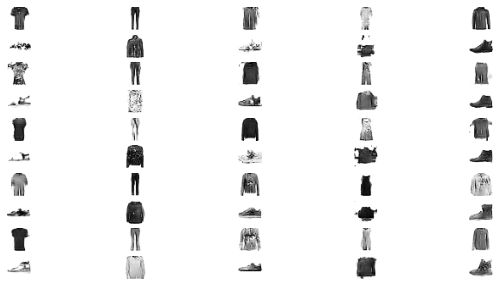

Epoch: 21 Batch 0 Loss fake: 0.324 Real: 0.331 GAN: 1.891 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.100
Epoch: 21 Batch 1 Loss fake: 0.303 Real: 0.367 GAN: 1.822 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.210
Epoch: 21 Batch 2 Loss fake: 0.336 Real: 0.342 GAN: 1.894 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.150
Epoch: 21 Batch 3 Loss fake: 0.473 Real: 0.439 GAN: 1.927 	 Accuracy fake: 0.781 Real: 0.734 GAN: 0.090
Epoch: 21 Batch 4 Loss fake: 0.259 Real: 0.383 GAN: 1.969 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.180
Epoch: 21 Batch 5 Loss fake: 0.393 Real: 0.299 GAN: 2.300 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.100
Epoch: 21 Batch 6 Loss fake: 0.443 Real: 0.391 GAN: 2.216 	 Accuracy fake: 0.781 Real: 0.812 GAN: 0.070
Epoch: 21 Batch 7 Loss fake: 0.261 Real: 0.375 GAN: 2.008 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.090
Epoch: 21 Batch 8 Loss fake: 0.268 Real: 0.428 GAN: 2.008 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.110
Epoch: 21 Batch 9 Loss fake: 0.341 Real: 0.406 GAN: 1.768 	 Accu

Epoch: 21 Batch 79 Loss fake: 0.272 Real: 0.593 GAN: 2.069 	 Accuracy fake: 0.906 Real: 0.672 GAN: 0.110
Epoch: 21 Batch 80 Loss fake: 0.305 Real: 0.401 GAN: 1.919 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.170
Epoch: 21 Batch 81 Loss fake: 0.397 Real: 0.295 GAN: 1.912 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.100
Epoch: 21 Batch 82 Loss fake: 0.265 Real: 0.306 GAN: 2.302 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.070
Epoch: 21 Batch 83 Loss fake: 0.262 Real: 0.370 GAN: 2.074 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.100
Epoch: 21 Batch 84 Loss fake: 0.372 Real: 0.453 GAN: 2.059 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.120
Epoch: 21 Batch 85 Loss fake: 0.442 Real: 0.531 GAN: 1.773 	 Accuracy fake: 0.797 Real: 0.750 GAN: 0.190
Epoch: 21 Batch 86 Loss fake: 0.396 Real: 0.255 GAN: 2.214 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.120
Epoch: 21 Batch 87 Loss fake: 0.325 Real: 0.419 GAN: 1.866 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.140
Epoch: 21 Batch 88 Loss fake: 0.295 Real: 0.291 GAN: 2.

Epoch: 21 Batch 157 Loss fake: 0.224 Real: 0.432 GAN: 1.953 	 Accuracy fake: 0.969 Real: 0.828 GAN: 0.140
Epoch: 21 Batch 158 Loss fake: 0.301 Real: 0.296 GAN: 1.729 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.180
Epoch: 21 Batch 159 Loss fake: 0.368 Real: 0.422 GAN: 2.070 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.130
Epoch: 21 Batch 160 Loss fake: 0.328 Real: 0.399 GAN: 2.239 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.080
Epoch: 21 Batch 161 Loss fake: 0.374 Real: 0.308 GAN: 2.262 	 Accuracy fake: 0.797 Real: 0.859 GAN: 0.080
Epoch: 21 Batch 162 Loss fake: 0.295 Real: 0.248 GAN: 2.163 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.110
Epoch: 21 Batch 163 Loss fake: 0.268 Real: 0.483 GAN: 2.042 	 Accuracy fake: 0.922 Real: 0.734 GAN: 0.110
Epoch: 21 Batch 164 Loss fake: 0.330 Real: 0.371 GAN: 1.770 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.200
Epoch: 21 Batch 165 Loss fake: 0.436 Real: 0.354 GAN: 1.803 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.160
Epoch: 21 Batch 166 Loss fake: 0.504 Real: 0.3

Epoch: 21 Batch 235 Loss fake: 0.221 Real: 0.429 GAN: 2.121 	 Accuracy fake: 0.953 Real: 0.703 GAN: 0.110
Epoch: 21 Batch 236 Loss fake: 0.286 Real: 0.256 GAN: 2.044 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.130
Epoch: 21 Batch 237 Loss fake: 0.342 Real: 0.483 GAN: 2.156 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.060
Epoch: 21 Batch 238 Loss fake: 0.440 Real: 0.407 GAN: 1.866 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.160
Epoch: 21 Batch 239 Loss fake: 0.295 Real: 0.317 GAN: 1.989 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.150
Epoch: 21 Batch 240 Loss fake: 0.357 Real: 0.420 GAN: 2.025 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.180
Epoch: 21 Batch 241 Loss fake: 0.347 Real: 0.346 GAN: 2.163 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.080
Epoch: 21 Batch 242 Loss fake: 0.366 Real: 0.366 GAN: 2.020 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.120
Epoch: 21 Batch 243 Loss fake: 0.331 Real: 0.408 GAN: 2.079 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.110
Epoch: 21 Batch 244 Loss fake: 0.330 Real: 0.4

Epoch: 21 Batch 313 Loss fake: 0.378 Real: 0.345 GAN: 2.093 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.160
Epoch: 21 Batch 314 Loss fake: 0.444 Real: 0.445 GAN: 2.163 	 Accuracy fake: 0.797 Real: 0.734 GAN: 0.120
Epoch: 21 Batch 315 Loss fake: 0.357 Real: 0.296 GAN: 2.037 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.080
Epoch: 21 Batch 316 Loss fake: 0.213 Real: 0.408 GAN: 1.968 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.140
Epoch: 21 Batch 317 Loss fake: 0.419 Real: 0.429 GAN: 1.883 	 Accuracy fake: 0.812 Real: 0.734 GAN: 0.130
Epoch: 21 Batch 318 Loss fake: 0.305 Real: 0.425 GAN: 1.707 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.150
Epoch: 21 Batch 319 Loss fake: 0.365 Real: 0.454 GAN: 1.673 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.180
Epoch: 21 Batch 320 Loss fake: 0.357 Real: 0.229 GAN: 1.917 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.090
Epoch: 21 Batch 321 Loss fake: 0.407 Real: 0.354 GAN: 2.342 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.110
Epoch: 21 Batch 322 Loss fake: 0.214 Real: 0.4

Epoch: 21 Batch 391 Loss fake: 0.348 Real: 0.300 GAN: 1.790 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.200
Epoch: 21 Batch 392 Loss fake: 0.497 Real: 0.362 GAN: 1.997 	 Accuracy fake: 0.766 Real: 0.812 GAN: 0.060
Epoch: 21 Batch 393 Loss fake: 0.297 Real: 0.308 GAN: 2.292 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.070
Epoch: 21 Batch 394 Loss fake: 0.247 Real: 0.397 GAN: 2.028 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.120
Epoch: 21 Batch 395 Loss fake: 0.204 Real: 0.333 GAN: 2.115 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.130
Epoch: 21 Batch 396 Loss fake: 0.288 Real: 0.390 GAN: 2.134 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.140
Epoch: 21 Batch 397 Loss fake: 0.337 Real: 0.252 GAN: 2.061 	 Accuracy fake: 0.797 Real: 0.891 GAN: 0.110
Epoch: 21 Batch 398 Loss fake: 0.350 Real: 0.442 GAN: 2.030 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.120
Epoch: 21 Batch 399 Loss fake: 0.232 Real: 0.428 GAN: 1.864 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.220
Epoch: 21 Batch 400 Loss fake: 0.419 Real: 0.2

Epoch: 22 Batch 1 Loss fake: 0.247 Real: 0.512 GAN: 2.131 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.100
Epoch: 22 Batch 2 Loss fake: 0.366 Real: 0.319 GAN: 1.838 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.160
Epoch: 22 Batch 3 Loss fake: 0.271 Real: 0.265 GAN: 2.093 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.110
Epoch: 22 Batch 4 Loss fake: 0.270 Real: 0.420 GAN: 2.118 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.110
Epoch: 22 Batch 5 Loss fake: 0.227 Real: 0.307 GAN: 2.046 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.150
Epoch: 22 Batch 6 Loss fake: 0.439 Real: 0.300 GAN: 2.332 	 Accuracy fake: 0.781 Real: 0.875 GAN: 0.090
Epoch: 22 Batch 7 Loss fake: 0.415 Real: 0.399 GAN: 2.271 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.080
Epoch: 22 Batch 8 Loss fake: 0.282 Real: 0.389 GAN: 2.139 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.080
Epoch: 22 Batch 9 Loss fake: 0.246 Real: 0.455 GAN: 1.987 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.150
Epoch: 22 Batch 10 Loss fake: 0.417 Real: 0.499 GAN: 1.952 	 Acc

Epoch: 22 Batch 80 Loss fake: 0.342 Real: 0.409 GAN: 2.111 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.130
Epoch: 22 Batch 81 Loss fake: 0.262 Real: 0.342 GAN: 2.192 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.050
Epoch: 22 Batch 82 Loss fake: 0.394 Real: 0.469 GAN: 1.837 	 Accuracy fake: 0.812 Real: 0.703 GAN: 0.140
Epoch: 22 Batch 83 Loss fake: 0.308 Real: 0.363 GAN: 1.723 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.150
Epoch: 22 Batch 84 Loss fake: 0.389 Real: 0.268 GAN: 2.064 	 Accuracy fake: 0.797 Real: 0.906 GAN: 0.080
Epoch: 22 Batch 85 Loss fake: 0.398 Real: 0.468 GAN: 2.127 	 Accuracy fake: 0.828 Real: 0.750 GAN: 0.120
Epoch: 22 Batch 86 Loss fake: 0.379 Real: 0.303 GAN: 2.054 	 Accuracy fake: 0.812 Real: 0.875 GAN: 0.100
Epoch: 22 Batch 87 Loss fake: 0.350 Real: 0.369 GAN: 2.317 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.080
Epoch: 22 Batch 88 Loss fake: 0.286 Real: 0.376 GAN: 1.928 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.110
Epoch: 22 Batch 89 Loss fake: 0.291 Real: 0.351 GAN: 1.

Epoch: 22 Batch 158 Loss fake: 0.291 Real: 0.536 GAN: 2.023 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.090
Epoch: 22 Batch 159 Loss fake: 0.360 Real: 0.287 GAN: 1.953 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.160
Epoch: 22 Batch 160 Loss fake: 0.344 Real: 0.483 GAN: 1.924 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.140
Epoch: 22 Batch 161 Loss fake: 0.293 Real: 0.280 GAN: 1.938 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.130
Epoch: 22 Batch 162 Loss fake: 0.387 Real: 0.293 GAN: 2.285 	 Accuracy fake: 0.797 Real: 0.859 GAN: 0.090
Epoch: 22 Batch 163 Loss fake: 0.308 Real: 0.325 GAN: 2.474 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.060
Epoch: 22 Batch 164 Loss fake: 0.225 Real: 0.391 GAN: 1.940 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.080
Epoch: 22 Batch 165 Loss fake: 0.263 Real: 0.488 GAN: 1.675 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.220
Epoch: 22 Batch 166 Loss fake: 0.403 Real: 0.305 GAN: 2.085 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.110
Epoch: 22 Batch 167 Loss fake: 0.417 Real: 0.2

Epoch: 22 Batch 236 Loss fake: 0.372 Real: 0.375 GAN: 2.181 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.070
Epoch: 22 Batch 237 Loss fake: 0.364 Real: 0.375 GAN: 2.259 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.140
Epoch: 22 Batch 238 Loss fake: 0.342 Real: 0.348 GAN: 2.100 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.050
Epoch: 22 Batch 239 Loss fake: 0.300 Real: 0.503 GAN: 2.150 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.130
Epoch: 22 Batch 240 Loss fake: 0.289 Real: 0.362 GAN: 1.682 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.170
Epoch: 22 Batch 241 Loss fake: 0.295 Real: 0.293 GAN: 1.803 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.160
Epoch: 22 Batch 242 Loss fake: 0.361 Real: 0.394 GAN: 1.754 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.160
Epoch: 22 Batch 243 Loss fake: 0.290 Real: 0.241 GAN: 2.041 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.080
Epoch: 22 Batch 244 Loss fake: 0.296 Real: 0.504 GAN: 2.072 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.080
Epoch: 22 Batch 245 Loss fake: 0.297 Real: 0.2

Epoch: 22 Batch 314 Loss fake: 0.333 Real: 0.533 GAN: 2.520 	 Accuracy fake: 0.859 Real: 0.703 GAN: 0.080
Epoch: 22 Batch 315 Loss fake: 0.263 Real: 0.339 GAN: 2.023 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.120
Epoch: 22 Batch 316 Loss fake: 0.293 Real: 0.311 GAN: 1.877 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.090
Epoch: 22 Batch 317 Loss fake: 0.437 Real: 0.336 GAN: 2.327 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.040
Epoch: 22 Batch 318 Loss fake: 0.300 Real: 0.410 GAN: 2.219 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.050
Epoch: 22 Batch 319 Loss fake: 0.244 Real: 0.305 GAN: 2.010 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.140
Epoch: 22 Batch 320 Loss fake: 0.295 Real: 0.269 GAN: 2.016 	 Accuracy fake: 0.875 Real: 0.891 GAN: 0.160
Epoch: 22 Batch 321 Loss fake: 0.307 Real: 0.470 GAN: 2.498 	 Accuracy fake: 0.922 Real: 0.734 GAN: 0.070
Epoch: 22 Batch 322 Loss fake: 0.336 Real: 0.515 GAN: 1.976 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.140
Epoch: 22 Batch 323 Loss fake: 0.345 Real: 0.4

Epoch: 22 Batch 392 Loss fake: 0.225 Real: 0.333 GAN: 2.088 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.120
Epoch: 22 Batch 393 Loss fake: 0.318 Real: 0.432 GAN: 1.621 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.240
Epoch: 22 Batch 394 Loss fake: 0.414 Real: 0.277 GAN: 2.217 	 Accuracy fake: 0.797 Real: 0.891 GAN: 0.130
Epoch: 22 Batch 395 Loss fake: 0.262 Real: 0.290 GAN: 2.221 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.100
Epoch: 22 Batch 396 Loss fake: 0.353 Real: 0.317 GAN: 2.309 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.100
Epoch: 22 Batch 397 Loss fake: 0.280 Real: 0.466 GAN: 2.402 	 Accuracy fake: 0.938 Real: 0.734 GAN: 0.090
Epoch: 22 Batch 398 Loss fake: 0.210 Real: 0.311 GAN: 1.909 	 Accuracy fake: 0.969 Real: 0.828 GAN: 0.140
Epoch: 22 Batch 399 Loss fake: 0.318 Real: 0.463 GAN: 1.813 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.150
Epoch: 22 Batch 400 Loss fake: 0.397 Real: 0.381 GAN: 2.129 	 Accuracy fake: 0.797 Real: 0.781 GAN: 0.180
Epoch: 22 Batch 401 Loss fake: 0.459 Real: 0.4

Epoch: 23 Batch 2 Loss fake: 0.286 Real: 0.409 GAN: 2.043 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.100
Epoch: 23 Batch 3 Loss fake: 0.345 Real: 0.288 GAN: 2.307 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.060
Epoch: 23 Batch 4 Loss fake: 0.204 Real: 0.414 GAN: 2.072 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.100
Epoch: 23 Batch 5 Loss fake: 0.249 Real: 0.208 GAN: 1.804 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.170
Epoch: 23 Batch 6 Loss fake: 0.325 Real: 0.494 GAN: 2.012 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.120
Epoch: 23 Batch 7 Loss fake: 0.380 Real: 0.444 GAN: 1.802 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.170
Epoch: 23 Batch 8 Loss fake: 0.425 Real: 0.613 GAN: 1.952 	 Accuracy fake: 0.828 Real: 0.719 GAN: 0.120
Epoch: 23 Batch 9 Loss fake: 0.330 Real: 0.448 GAN: 1.733 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.190
Epoch: 23 Batch 10 Loss fake: 0.406 Real: 0.459 GAN: 1.836 	 Accuracy fake: 0.781 Real: 0.750 GAN: 0.100
Epoch: 23 Batch 11 Loss fake: 0.348 Real: 0.330 GAN: 1.954 	 Ac

Epoch: 23 Batch 81 Loss fake: 0.285 Real: 0.427 GAN: 1.794 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.200
Epoch: 23 Batch 82 Loss fake: 0.421 Real: 0.292 GAN: 1.970 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.180
Epoch: 23 Batch 83 Loss fake: 0.449 Real: 0.470 GAN: 2.247 	 Accuracy fake: 0.766 Real: 0.766 GAN: 0.090
Epoch: 23 Batch 84 Loss fake: 0.289 Real: 0.434 GAN: 2.157 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.120
Epoch: 23 Batch 85 Loss fake: 0.290 Real: 0.407 GAN: 1.782 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.200
Epoch: 23 Batch 86 Loss fake: 0.343 Real: 0.372 GAN: 2.015 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.140
Epoch: 23 Batch 87 Loss fake: 0.405 Real: 0.340 GAN: 2.010 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.120
Epoch: 23 Batch 88 Loss fake: 0.352 Real: 0.297 GAN: 2.212 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.050
Epoch: 23 Batch 89 Loss fake: 0.281 Real: 0.333 GAN: 2.300 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.090
Epoch: 23 Batch 90 Loss fake: 0.224 Real: 0.444 GAN: 1.

Epoch: 23 Batch 159 Loss fake: 0.299 Real: 0.376 GAN: 1.912 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.110
Epoch: 23 Batch 160 Loss fake: 0.387 Real: 0.297 GAN: 2.182 	 Accuracy fake: 0.812 Real: 0.906 GAN: 0.070
Epoch: 23 Batch 161 Loss fake: 0.286 Real: 0.528 GAN: 2.179 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.100
Epoch: 23 Batch 162 Loss fake: 0.227 Real: 0.237 GAN: 2.069 	 Accuracy fake: 0.953 Real: 0.906 GAN: 0.100
Epoch: 23 Batch 163 Loss fake: 0.347 Real: 0.458 GAN: 2.171 	 Accuracy fake: 0.844 Real: 0.703 GAN: 0.120
Epoch: 23 Batch 164 Loss fake: 0.386 Real: 0.409 GAN: 2.059 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.110
Epoch: 23 Batch 165 Loss fake: 0.405 Real: 0.266 GAN: 2.166 	 Accuracy fake: 0.797 Real: 0.875 GAN: 0.050
Epoch: 23 Batch 166 Loss fake: 0.308 Real: 0.244 GAN: 2.412 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.060
Epoch: 23 Batch 167 Loss fake: 0.236 Real: 0.441 GAN: 2.431 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.100
Epoch: 23 Batch 168 Loss fake: 0.222 Real: 0.3

Epoch: 23 Batch 237 Loss fake: 0.233 Real: 0.431 GAN: 2.084 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.080
Epoch: 23 Batch 238 Loss fake: 0.289 Real: 0.431 GAN: 1.971 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.090
Epoch: 23 Batch 239 Loss fake: 0.508 Real: 0.266 GAN: 2.067 	 Accuracy fake: 0.766 Real: 0.922 GAN: 0.160
Epoch: 23 Batch 240 Loss fake: 0.307 Real: 0.256 GAN: 2.089 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.090
Epoch: 23 Batch 241 Loss fake: 0.370 Real: 0.477 GAN: 2.356 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.080
Epoch: 23 Batch 242 Loss fake: 0.351 Real: 0.418 GAN: 2.119 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.130
Epoch: 23 Batch 243 Loss fake: 0.397 Real: 0.462 GAN: 2.014 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.100
Epoch: 23 Batch 244 Loss fake: 0.364 Real: 0.331 GAN: 2.193 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.110
Epoch: 23 Batch 245 Loss fake: 0.314 Real: 0.468 GAN: 2.073 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.110
Epoch: 23 Batch 246 Loss fake: 0.417 Real: 0.4

Epoch: 23 Batch 315 Loss fake: 0.293 Real: 0.329 GAN: 2.040 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.090
Epoch: 23 Batch 316 Loss fake: 0.433 Real: 0.406 GAN: 2.253 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.050
Epoch: 23 Batch 317 Loss fake: 0.215 Real: 0.540 GAN: 1.758 	 Accuracy fake: 0.953 Real: 0.750 GAN: 0.130
Epoch: 23 Batch 318 Loss fake: 0.466 Real: 0.299 GAN: 2.077 	 Accuracy fake: 0.750 Real: 0.891 GAN: 0.100
Epoch: 23 Batch 319 Loss fake: 0.287 Real: 0.398 GAN: 2.153 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.130
Epoch: 23 Batch 320 Loss fake: 0.249 Real: 0.279 GAN: 2.193 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.060
Epoch: 23 Batch 321 Loss fake: 0.341 Real: 0.379 GAN: 2.237 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.120
Epoch: 23 Batch 322 Loss fake: 0.347 Real: 0.413 GAN: 2.165 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.080
Epoch: 23 Batch 323 Loss fake: 0.222 Real: 0.388 GAN: 1.878 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.110
Epoch: 23 Batch 324 Loss fake: 0.373 Real: 0.4

Epoch: 23 Batch 393 Loss fake: 0.345 Real: 0.242 GAN: 2.208 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.130
Epoch: 23 Batch 394 Loss fake: 0.242 Real: 0.419 GAN: 1.904 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.160
Epoch: 23 Batch 395 Loss fake: 0.215 Real: 0.236 GAN: 1.998 	 Accuracy fake: 0.969 Real: 0.859 GAN: 0.120
Epoch: 23 Batch 396 Loss fake: 0.313 Real: 0.338 GAN: 2.281 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.100
Epoch: 23 Batch 397 Loss fake: 0.259 Real: 0.322 GAN: 2.069 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.070
Epoch: 23 Batch 398 Loss fake: 0.316 Real: 0.431 GAN: 2.037 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.200
Epoch: 23 Batch 399 Loss fake: 0.326 Real: 0.279 GAN: 2.314 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.100
Epoch: 23 Batch 400 Loss fake: 0.320 Real: 0.288 GAN: 2.246 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.090
Epoch: 23 Batch 401 Loss fake: 0.373 Real: 0.471 GAN: 2.162 	 Accuracy fake: 0.828 Real: 0.734 GAN: 0.100
Epoch: 23 Batch 402 Loss fake: 0.260 Real: 0.2

Epoch: 24 Batch 3 Loss fake: 0.342 Real: 0.394 GAN: 2.071 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.170
Epoch: 24 Batch 4 Loss fake: 0.460 Real: 0.423 GAN: 1.816 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.160
Epoch: 24 Batch 5 Loss fake: 0.304 Real: 0.337 GAN: 2.113 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.120
Epoch: 24 Batch 6 Loss fake: 0.294 Real: 0.471 GAN: 1.771 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.160
Epoch: 24 Batch 7 Loss fake: 0.356 Real: 0.464 GAN: 1.815 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.130
Epoch: 24 Batch 8 Loss fake: 0.346 Real: 0.301 GAN: 1.771 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.230
Epoch: 24 Batch 9 Loss fake: 0.262 Real: 0.391 GAN: 1.786 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.180
Epoch: 24 Batch 10 Loss fake: 0.428 Real: 0.276 GAN: 2.035 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.130
Epoch: 24 Batch 11 Loss fake: 0.266 Real: 0.321 GAN: 2.173 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.110
Epoch: 24 Batch 12 Loss fake: 0.399 Real: 0.311 GAN: 2.087 	 A

Epoch: 24 Batch 82 Loss fake: 0.336 Real: 0.298 GAN: 2.226 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.100
Epoch: 24 Batch 83 Loss fake: 0.312 Real: 0.361 GAN: 1.935 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.150
Epoch: 24 Batch 84 Loss fake: 0.399 Real: 0.357 GAN: 2.286 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.120
Epoch: 24 Batch 85 Loss fake: 0.256 Real: 0.342 GAN: 2.338 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.110
Epoch: 24 Batch 86 Loss fake: 0.274 Real: 0.501 GAN: 1.976 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.200
Epoch: 24 Batch 87 Loss fake: 0.371 Real: 0.414 GAN: 2.227 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.140
Epoch: 24 Batch 88 Loss fake: 0.297 Real: 0.456 GAN: 1.856 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.140
Epoch: 24 Batch 89 Loss fake: 0.279 Real: 0.306 GAN: 2.192 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.110
Epoch: 24 Batch 90 Loss fake: 0.277 Real: 0.370 GAN: 1.968 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.170
Epoch: 24 Batch 91 Loss fake: 0.276 Real: 0.344 GAN: 1.

Epoch: 24 Batch 160 Loss fake: 0.330 Real: 0.427 GAN: 2.257 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.110
Epoch: 24 Batch 161 Loss fake: 0.244 Real: 0.517 GAN: 2.133 	 Accuracy fake: 0.969 Real: 0.781 GAN: 0.100
Epoch: 24 Batch 162 Loss fake: 0.258 Real: 0.404 GAN: 2.094 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.150
Epoch: 24 Batch 163 Loss fake: 0.396 Real: 0.370 GAN: 1.802 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.140
Epoch: 24 Batch 164 Loss fake: 0.465 Real: 0.413 GAN: 2.076 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.140
Epoch: 24 Batch 165 Loss fake: 0.345 Real: 0.365 GAN: 2.132 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.100
Epoch: 24 Batch 166 Loss fake: 0.387 Real: 0.351 GAN: 2.015 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.120
Epoch: 24 Batch 167 Loss fake: 0.379 Real: 0.324 GAN: 2.391 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.110
Epoch: 24 Batch 168 Loss fake: 0.218 Real: 0.554 GAN: 2.141 	 Accuracy fake: 0.938 Real: 0.734 GAN: 0.090
Epoch: 24 Batch 169 Loss fake: 0.270 Real: 0.2

Epoch: 24 Batch 238 Loss fake: 0.358 Real: 0.321 GAN: 1.930 	 Accuracy fake: 0.812 Real: 0.875 GAN: 0.130
Epoch: 24 Batch 239 Loss fake: 0.331 Real: 0.366 GAN: 2.175 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.080
Epoch: 24 Batch 240 Loss fake: 0.325 Real: 0.315 GAN: 2.133 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.150
Epoch: 24 Batch 241 Loss fake: 0.346 Real: 0.358 GAN: 2.121 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.140
Epoch: 24 Batch 242 Loss fake: 0.259 Real: 0.339 GAN: 2.361 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.090
Epoch: 24 Batch 243 Loss fake: 0.443 Real: 0.253 GAN: 2.354 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.070
Epoch: 24 Batch 244 Loss fake: 0.230 Real: 0.382 GAN: 2.060 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.110
Epoch: 24 Batch 245 Loss fake: 0.303 Real: 0.261 GAN: 1.890 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.130
Epoch: 24 Batch 246 Loss fake: 0.348 Real: 0.427 GAN: 2.514 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.080
Epoch: 24 Batch 247 Loss fake: 0.368 Real: 0.3

Epoch: 24 Batch 316 Loss fake: 0.252 Real: 0.279 GAN: 2.165 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.110
Epoch: 24 Batch 317 Loss fake: 0.280 Real: 0.389 GAN: 2.265 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.050
Epoch: 24 Batch 318 Loss fake: 0.241 Real: 0.377 GAN: 2.002 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.140
Epoch: 24 Batch 319 Loss fake: 0.292 Real: 0.357 GAN: 1.964 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.120
Epoch: 24 Batch 320 Loss fake: 0.428 Real: 0.285 GAN: 2.482 	 Accuracy fake: 0.766 Real: 0.828 GAN: 0.030
Epoch: 24 Batch 321 Loss fake: 0.284 Real: 0.378 GAN: 2.243 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.080
Epoch: 24 Batch 322 Loss fake: 0.238 Real: 0.549 GAN: 2.031 	 Accuracy fake: 0.891 Real: 0.688 GAN: 0.090
Epoch: 24 Batch 323 Loss fake: 0.466 Real: 0.384 GAN: 2.389 	 Accuracy fake: 0.734 Real: 0.828 GAN: 0.120
Epoch: 24 Batch 324 Loss fake: 0.295 Real: 0.326 GAN: 1.997 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.110
Epoch: 24 Batch 325 Loss fake: 0.283 Real: 0.3

Epoch: 24 Batch 394 Loss fake: 0.295 Real: 0.322 GAN: 2.411 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.100
Epoch: 24 Batch 395 Loss fake: 0.297 Real: 0.448 GAN: 2.088 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.110
Epoch: 24 Batch 396 Loss fake: 0.341 Real: 0.278 GAN: 2.162 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.150
Epoch: 24 Batch 397 Loss fake: 0.284 Real: 0.257 GAN: 2.149 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.100
Epoch: 24 Batch 398 Loss fake: 0.215 Real: 0.348 GAN: 2.094 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.110
Epoch: 24 Batch 399 Loss fake: 0.352 Real: 0.308 GAN: 2.271 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.120
Epoch: 24 Batch 400 Loss fake: 0.308 Real: 0.311 GAN: 2.179 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.100
Epoch: 24 Batch 401 Loss fake: 0.316 Real: 0.451 GAN: 2.451 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.080
Epoch: 24 Batch 402 Loss fake: 0.297 Real: 0.388 GAN: 2.113 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.110
Epoch: 24 Batch 403 Loss fake: 0.297 Real: 0.2

Epoch: 25 Batch 4 Loss fake: 0.314 Real: 0.491 GAN: 1.928 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.120
Epoch: 25 Batch 5 Loss fake: 0.346 Real: 0.350 GAN: 1.786 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.200
Epoch: 25 Batch 6 Loss fake: 0.269 Real: 0.293 GAN: 2.000 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.090
Epoch: 25 Batch 7 Loss fake: 0.412 Real: 0.357 GAN: 2.088 	 Accuracy fake: 0.781 Real: 0.844 GAN: 0.100
Epoch: 25 Batch 8 Loss fake: 0.260 Real: 0.215 GAN: 2.131 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.130
Epoch: 25 Batch 9 Loss fake: 0.298 Real: 0.469 GAN: 1.958 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.100
Epoch: 25 Batch 10 Loss fake: 0.317 Real: 0.301 GAN: 2.157 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.050
Epoch: 25 Batch 11 Loss fake: 0.328 Real: 0.335 GAN: 2.022 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.140
Epoch: 25 Batch 12 Loss fake: 0.272 Real: 0.409 GAN: 2.101 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.110
Epoch: 25 Batch 13 Loss fake: 0.387 Real: 0.254 GAN: 2.024 	 

Epoch: 25 Batch 83 Loss fake: 0.446 Real: 0.332 GAN: 2.586 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.090
Epoch: 25 Batch 84 Loss fake: 0.325 Real: 0.402 GAN: 2.306 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.080
Epoch: 25 Batch 85 Loss fake: 0.245 Real: 0.464 GAN: 2.445 	 Accuracy fake: 0.953 Real: 0.766 GAN: 0.050
Epoch: 25 Batch 86 Loss fake: 0.239 Real: 0.248 GAN: 2.031 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.110
Epoch: 25 Batch 87 Loss fake: 0.338 Real: 0.215 GAN: 2.042 	 Accuracy fake: 0.859 Real: 0.922 GAN: 0.100
Epoch: 25 Batch 88 Loss fake: 0.226 Real: 0.346 GAN: 1.996 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.170
Epoch: 25 Batch 89 Loss fake: 0.297 Real: 0.324 GAN: 2.114 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.060
Epoch: 25 Batch 90 Loss fake: 0.332 Real: 0.365 GAN: 2.144 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.050
Epoch: 25 Batch 91 Loss fake: 0.401 Real: 0.443 GAN: 2.318 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.080
Epoch: 25 Batch 92 Loss fake: 0.288 Real: 0.478 GAN: 1.

Epoch: 25 Batch 161 Loss fake: 0.261 Real: 0.407 GAN: 2.325 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.060
Epoch: 25 Batch 162 Loss fake: 0.252 Real: 0.375 GAN: 1.928 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.080
Epoch: 25 Batch 163 Loss fake: 0.309 Real: 0.255 GAN: 2.030 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.160
Epoch: 25 Batch 164 Loss fake: 0.333 Real: 0.247 GAN: 2.575 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.110
Epoch: 25 Batch 165 Loss fake: 0.253 Real: 0.339 GAN: 2.407 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.050
Epoch: 25 Batch 166 Loss fake: 0.196 Real: 0.368 GAN: 2.156 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.100
Epoch: 25 Batch 167 Loss fake: 0.324 Real: 0.253 GAN: 2.134 	 Accuracy fake: 0.875 Real: 0.906 GAN: 0.140
Epoch: 25 Batch 168 Loss fake: 0.376 Real: 0.376 GAN: 2.327 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.100
Epoch: 25 Batch 169 Loss fake: 0.329 Real: 0.401 GAN: 2.165 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.110
Epoch: 25 Batch 170 Loss fake: 0.269 Real: 0.4

Epoch: 25 Batch 239 Loss fake: 0.299 Real: 0.418 GAN: 2.000 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.140
Epoch: 25 Batch 240 Loss fake: 0.305 Real: 0.335 GAN: 2.058 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.180
Epoch: 25 Batch 241 Loss fake: 0.226 Real: 0.297 GAN: 2.172 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.060
Epoch: 25 Batch 242 Loss fake: 0.300 Real: 0.411 GAN: 1.883 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.170
Epoch: 25 Batch 243 Loss fake: 0.370 Real: 0.312 GAN: 1.941 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.160
Epoch: 25 Batch 244 Loss fake: 0.268 Real: 0.449 GAN: 2.104 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.090
Epoch: 25 Batch 245 Loss fake: 0.410 Real: 0.359 GAN: 1.972 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.100
Epoch: 25 Batch 246 Loss fake: 0.402 Real: 0.279 GAN: 2.406 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.120
Epoch: 25 Batch 247 Loss fake: 0.197 Real: 0.420 GAN: 1.816 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.100
Epoch: 25 Batch 248 Loss fake: 0.355 Real: 0.4

Epoch: 25 Batch 317 Loss fake: 0.389 Real: 0.361 GAN: 1.966 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.150
Epoch: 25 Batch 318 Loss fake: 0.295 Real: 0.404 GAN: 1.972 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.090
Epoch: 25 Batch 319 Loss fake: 0.328 Real: 0.326 GAN: 1.971 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.100
Epoch: 25 Batch 320 Loss fake: 0.356 Real: 0.296 GAN: 2.148 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.090
Epoch: 25 Batch 321 Loss fake: 0.266 Real: 0.484 GAN: 2.210 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.120
Epoch: 25 Batch 322 Loss fake: 0.288 Real: 0.362 GAN: 1.984 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.140
Epoch: 25 Batch 323 Loss fake: 0.286 Real: 0.354 GAN: 1.928 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.140
Epoch: 25 Batch 324 Loss fake: 0.407 Real: 0.416 GAN: 2.181 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.070
Epoch: 25 Batch 325 Loss fake: 0.245 Real: 0.333 GAN: 2.061 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.120
Epoch: 25 Batch 326 Loss fake: 0.307 Real: 0.3

Epoch: 25 Batch 395 Loss fake: 0.329 Real: 0.460 GAN: 2.150 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.140
Epoch: 25 Batch 396 Loss fake: 0.266 Real: 0.511 GAN: 2.037 	 Accuracy fake: 0.891 Real: 0.703 GAN: 0.150
Epoch: 25 Batch 397 Loss fake: 0.363 Real: 0.350 GAN: 2.104 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.110
Epoch: 25 Batch 398 Loss fake: 0.446 Real: 0.360 GAN: 2.098 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.140
Epoch: 25 Batch 399 Loss fake: 0.219 Real: 0.453 GAN: 2.292 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.080
Epoch: 25 Batch 400 Loss fake: 0.333 Real: 0.561 GAN: 1.902 	 Accuracy fake: 0.906 Real: 0.672 GAN: 0.190
Epoch: 25 Batch 401 Loss fake: 0.422 Real: 0.265 GAN: 2.081 	 Accuracy fake: 0.781 Real: 0.891 GAN: 0.100
Epoch: 25 Batch 402 Loss fake: 0.370 Real: 0.306 GAN: 2.127 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.060
Epoch: 25 Batch 403 Loss fake: 0.330 Real: 0.378 GAN: 2.380 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.070
Epoch: 25 Batch 404 Loss fake: 0.229 Real: 0.3

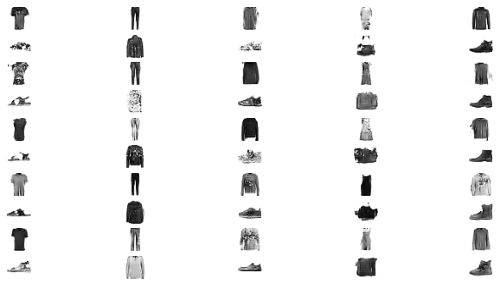

Epoch: 26 Batch 0 Loss fake: 0.330 Real: 0.412 GAN: 1.920 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.190
Epoch: 26 Batch 1 Loss fake: 0.349 Real: 0.295 GAN: 2.193 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.130
Epoch: 26 Batch 2 Loss fake: 0.297 Real: 0.239 GAN: 2.157 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.170
Epoch: 26 Batch 3 Loss fake: 0.391 Real: 0.312 GAN: 2.352 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.110
Epoch: 26 Batch 4 Loss fake: 0.279 Real: 0.620 GAN: 2.286 	 Accuracy fake: 0.891 Real: 0.703 GAN: 0.090
Epoch: 26 Batch 5 Loss fake: 0.339 Real: 0.298 GAN: 2.176 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.110
Epoch: 26 Batch 6 Loss fake: 0.326 Real: 0.421 GAN: 2.097 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.150
Epoch: 26 Batch 7 Loss fake: 0.337 Real: 0.235 GAN: 2.132 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.140
Epoch: 26 Batch 8 Loss fake: 0.273 Real: 0.298 GAN: 2.161 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.110
Epoch: 26 Batch 9 Loss fake: 0.393 Real: 0.340 GAN: 2.400 	 Accu

Epoch: 26 Batch 79 Loss fake: 0.254 Real: 0.506 GAN: 2.204 	 Accuracy fake: 0.922 Real: 0.719 GAN: 0.130
Epoch: 26 Batch 80 Loss fake: 0.282 Real: 0.332 GAN: 2.068 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.170
Epoch: 26 Batch 81 Loss fake: 0.354 Real: 0.266 GAN: 1.995 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.150
Epoch: 26 Batch 82 Loss fake: 0.337 Real: 0.460 GAN: 2.036 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.100
Epoch: 26 Batch 83 Loss fake: 0.243 Real: 0.361 GAN: 2.033 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.130
Epoch: 26 Batch 84 Loss fake: 0.315 Real: 0.313 GAN: 2.060 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.200
Epoch: 26 Batch 85 Loss fake: 0.397 Real: 0.247 GAN: 2.255 	 Accuracy fake: 0.828 Real: 0.906 GAN: 0.140
Epoch: 26 Batch 86 Loss fake: 0.330 Real: 0.302 GAN: 2.619 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.030
Epoch: 26 Batch 87 Loss fake: 0.152 Real: 0.581 GAN: 2.215 	 Accuracy fake: 0.969 Real: 0.750 GAN: 0.130
Epoch: 26 Batch 88 Loss fake: 0.415 Real: 0.359 GAN: 2.

Epoch: 26 Batch 157 Loss fake: 0.259 Real: 0.309 GAN: 2.370 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.040
Epoch: 26 Batch 158 Loss fake: 0.289 Real: 0.365 GAN: 2.179 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.080
Epoch: 26 Batch 159 Loss fake: 0.316 Real: 0.463 GAN: 2.200 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.110
Epoch: 26 Batch 160 Loss fake: 0.342 Real: 0.264 GAN: 2.266 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.080
Epoch: 26 Batch 161 Loss fake: 0.296 Real: 0.440 GAN: 2.034 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.100
Epoch: 26 Batch 162 Loss fake: 0.345 Real: 0.396 GAN: 2.198 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.060
Epoch: 26 Batch 163 Loss fake: 0.266 Real: 0.362 GAN: 1.923 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.170
Epoch: 26 Batch 164 Loss fake: 0.344 Real: 0.410 GAN: 2.145 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.170
Epoch: 26 Batch 165 Loss fake: 0.409 Real: 0.348 GAN: 2.097 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.120
Epoch: 26 Batch 166 Loss fake: 0.294 Real: 0.4

Epoch: 26 Batch 235 Loss fake: 0.364 Real: 0.386 GAN: 2.297 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.100
Epoch: 26 Batch 236 Loss fake: 0.285 Real: 0.465 GAN: 2.133 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.140
Epoch: 26 Batch 237 Loss fake: 0.267 Real: 0.426 GAN: 1.771 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.170
Epoch: 26 Batch 238 Loss fake: 0.303 Real: 0.368 GAN: 2.098 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.100
Epoch: 26 Batch 239 Loss fake: 0.425 Real: 0.506 GAN: 2.145 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.100
Epoch: 26 Batch 240 Loss fake: 0.265 Real: 0.339 GAN: 1.943 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.140
Epoch: 26 Batch 241 Loss fake: 0.209 Real: 0.361 GAN: 1.755 	 Accuracy fake: 0.953 Real: 0.781 GAN: 0.210
Epoch: 26 Batch 242 Loss fake: 0.494 Real: 0.273 GAN: 2.100 	 Accuracy fake: 0.750 Real: 0.906 GAN: 0.090
Epoch: 26 Batch 243 Loss fake: 0.353 Real: 0.367 GAN: 2.257 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.070
Epoch: 26 Batch 244 Loss fake: 0.234 Real: 0.3

Epoch: 26 Batch 313 Loss fake: 0.314 Real: 0.476 GAN: 1.896 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.090
Epoch: 26 Batch 314 Loss fake: 0.375 Real: 0.350 GAN: 1.953 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.140
Epoch: 26 Batch 315 Loss fake: 0.310 Real: 0.266 GAN: 2.048 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.110
Epoch: 26 Batch 316 Loss fake: 0.379 Real: 0.495 GAN: 2.341 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.120
Epoch: 26 Batch 317 Loss fake: 0.312 Real: 0.349 GAN: 1.974 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.110
Epoch: 26 Batch 318 Loss fake: 0.314 Real: 0.278 GAN: 2.180 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.120
Epoch: 26 Batch 319 Loss fake: 0.317 Real: 0.292 GAN: 2.180 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.100
Epoch: 26 Batch 320 Loss fake: 0.355 Real: 0.435 GAN: 2.019 	 Accuracy fake: 0.859 Real: 0.719 GAN: 0.160
Epoch: 26 Batch 321 Loss fake: 0.289 Real: 0.494 GAN: 2.120 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.110
Epoch: 26 Batch 322 Loss fake: 0.345 Real: 0.3

Epoch: 26 Batch 391 Loss fake: 0.326 Real: 0.342 GAN: 1.950 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.150
Epoch: 26 Batch 392 Loss fake: 0.399 Real: 0.251 GAN: 1.875 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.190
Epoch: 26 Batch 393 Loss fake: 0.452 Real: 0.372 GAN: 2.162 	 Accuracy fake: 0.766 Real: 0.828 GAN: 0.050
Epoch: 26 Batch 394 Loss fake: 0.290 Real: 0.374 GAN: 2.151 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.120
Epoch: 26 Batch 395 Loss fake: 0.235 Real: 0.335 GAN: 2.128 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.090
Epoch: 26 Batch 396 Loss fake: 0.401 Real: 0.441 GAN: 2.128 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.130
Epoch: 26 Batch 397 Loss fake: 0.251 Real: 0.551 GAN: 1.844 	 Accuracy fake: 0.953 Real: 0.734 GAN: 0.180
Epoch: 26 Batch 398 Loss fake: 0.402 Real: 0.325 GAN: 1.748 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.160
Epoch: 26 Batch 399 Loss fake: 0.345 Real: 0.412 GAN: 1.951 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.150
Epoch: 26 Batch 400 Loss fake: 0.404 Real: 0.3

Epoch: 27 Batch 1 Loss fake: 0.308 Real: 0.339 GAN: 2.006 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.100
Epoch: 27 Batch 2 Loss fake: 0.376 Real: 0.307 GAN: 2.162 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.080
Epoch: 27 Batch 3 Loss fake: 0.324 Real: 0.372 GAN: 2.060 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.080
Epoch: 27 Batch 4 Loss fake: 0.280 Real: 0.342 GAN: 2.156 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.140
Epoch: 27 Batch 5 Loss fake: 0.307 Real: 0.311 GAN: 1.862 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.190
Epoch: 27 Batch 6 Loss fake: 0.336 Real: 0.410 GAN: 1.949 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.090
Epoch: 27 Batch 7 Loss fake: 0.298 Real: 0.409 GAN: 2.087 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.100
Epoch: 27 Batch 8 Loss fake: 0.313 Real: 0.322 GAN: 1.980 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.150
Epoch: 27 Batch 9 Loss fake: 0.385 Real: 0.288 GAN: 2.096 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.120
Epoch: 27 Batch 10 Loss fake: 0.390 Real: 0.364 GAN: 2.295 	 Acc

Epoch: 27 Batch 80 Loss fake: 0.243 Real: 0.385 GAN: 1.989 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.160
Epoch: 27 Batch 81 Loss fake: 0.467 Real: 0.384 GAN: 2.408 	 Accuracy fake: 0.797 Real: 0.750 GAN: 0.080
Epoch: 27 Batch 82 Loss fake: 0.248 Real: 0.331 GAN: 2.167 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.120
Epoch: 27 Batch 83 Loss fake: 0.454 Real: 0.381 GAN: 2.309 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.050
Epoch: 27 Batch 84 Loss fake: 0.262 Real: 0.313 GAN: 1.999 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.140
Epoch: 27 Batch 85 Loss fake: 0.265 Real: 0.584 GAN: 1.922 	 Accuracy fake: 0.922 Real: 0.688 GAN: 0.150
Epoch: 27 Batch 86 Loss fake: 0.280 Real: 0.333 GAN: 1.840 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.180
Epoch: 27 Batch 87 Loss fake: 0.423 Real: 0.379 GAN: 1.957 	 Accuracy fake: 0.797 Real: 0.797 GAN: 0.140
Epoch: 27 Batch 88 Loss fake: 0.309 Real: 0.352 GAN: 2.117 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.130
Epoch: 27 Batch 89 Loss fake: 0.333 Real: 0.349 GAN: 1.

Epoch: 27 Batch 158 Loss fake: 0.291 Real: 0.291 GAN: 2.295 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.120
Epoch: 27 Batch 159 Loss fake: 0.249 Real: 0.291 GAN: 2.273 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.130
Epoch: 27 Batch 160 Loss fake: 0.337 Real: 0.586 GAN: 2.036 	 Accuracy fake: 0.875 Real: 0.703 GAN: 0.130
Epoch: 27 Batch 161 Loss fake: 0.379 Real: 0.326 GAN: 1.948 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.110
Epoch: 27 Batch 162 Loss fake: 0.428 Real: 0.296 GAN: 2.010 	 Accuracy fake: 0.844 Real: 0.922 GAN: 0.090
Epoch: 27 Batch 163 Loss fake: 0.384 Real: 0.420 GAN: 2.307 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.110
Epoch: 27 Batch 164 Loss fake: 0.187 Real: 0.321 GAN: 2.028 	 Accuracy fake: 0.969 Real: 0.797 GAN: 0.230
Epoch: 27 Batch 165 Loss fake: 0.423 Real: 0.377 GAN: 1.945 	 Accuracy fake: 0.797 Real: 0.781 GAN: 0.170
Epoch: 27 Batch 166 Loss fake: 0.429 Real: 0.283 GAN: 2.339 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.080
Epoch: 27 Batch 167 Loss fake: 0.292 Real: 0.2

Epoch: 27 Batch 236 Loss fake: 0.352 Real: 0.426 GAN: 1.739 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.140
Epoch: 27 Batch 237 Loss fake: 0.309 Real: 0.489 GAN: 1.603 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.250
Epoch: 27 Batch 238 Loss fake: 0.425 Real: 0.360 GAN: 1.858 	 Accuracy fake: 0.781 Real: 0.844 GAN: 0.160
Epoch: 27 Batch 239 Loss fake: 0.357 Real: 0.292 GAN: 2.195 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.110
Epoch: 27 Batch 240 Loss fake: 0.336 Real: 0.339 GAN: 2.271 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.120
Epoch: 27 Batch 241 Loss fake: 0.316 Real: 0.311 GAN: 2.486 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.110
Epoch: 27 Batch 242 Loss fake: 0.252 Real: 0.402 GAN: 2.187 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.100
Epoch: 27 Batch 243 Loss fake: 0.312 Real: 0.286 GAN: 2.280 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.110
Epoch: 27 Batch 244 Loss fake: 0.346 Real: 0.374 GAN: 2.387 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.090
Epoch: 27 Batch 245 Loss fake: 0.279 Real: 0.3

Epoch: 27 Batch 314 Loss fake: 0.334 Real: 0.239 GAN: 2.470 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.080
Epoch: 27 Batch 315 Loss fake: 0.325 Real: 0.418 GAN: 2.305 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 27 Batch 316 Loss fake: 0.304 Real: 0.401 GAN: 2.452 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.080
Epoch: 27 Batch 317 Loss fake: 0.241 Real: 0.386 GAN: 2.059 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.180
Epoch: 27 Batch 318 Loss fake: 0.392 Real: 0.349 GAN: 2.354 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.090
Epoch: 27 Batch 319 Loss fake: 0.411 Real: 0.410 GAN: 2.422 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.120
Epoch: 27 Batch 320 Loss fake: 0.220 Real: 0.184 GAN: 2.301 	 Accuracy fake: 0.938 Real: 0.938 GAN: 0.110
Epoch: 27 Batch 321 Loss fake: 0.277 Real: 0.565 GAN: 2.171 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.130
Epoch: 27 Batch 322 Loss fake: 0.433 Real: 0.317 GAN: 2.492 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.070
Epoch: 27 Batch 323 Loss fake: 0.248 Real: 0.3

Epoch: 27 Batch 392 Loss fake: 0.305 Real: 0.433 GAN: 2.168 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.120
Epoch: 27 Batch 393 Loss fake: 0.321 Real: 0.273 GAN: 2.126 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.080
Epoch: 27 Batch 394 Loss fake: 0.344 Real: 0.477 GAN: 2.166 	 Accuracy fake: 0.875 Real: 0.703 GAN: 0.110
Epoch: 27 Batch 395 Loss fake: 0.296 Real: 0.263 GAN: 2.241 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.090
Epoch: 27 Batch 396 Loss fake: 0.270 Real: 0.261 GAN: 2.161 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.040
Epoch: 27 Batch 397 Loss fake: 0.223 Real: 0.386 GAN: 2.047 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.140
Epoch: 27 Batch 398 Loss fake: 0.404 Real: 0.227 GAN: 2.253 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.160
Epoch: 27 Batch 399 Loss fake: 0.280 Real: 0.450 GAN: 2.589 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.100
Epoch: 27 Batch 400 Loss fake: 0.264 Real: 0.361 GAN: 2.225 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.160
Epoch: 27 Batch 401 Loss fake: 0.244 Real: 0.2

Epoch: 28 Batch 2 Loss fake: 0.346 Real: 0.435 GAN: 2.177 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 28 Batch 3 Loss fake: 0.252 Real: 0.395 GAN: 1.964 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.080
Epoch: 28 Batch 4 Loss fake: 0.323 Real: 0.265 GAN: 1.996 	 Accuracy fake: 0.859 Real: 0.922 GAN: 0.160
Epoch: 28 Batch 5 Loss fake: 0.382 Real: 0.338 GAN: 2.275 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.090
Epoch: 28 Batch 6 Loss fake: 0.245 Real: 0.303 GAN: 2.368 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.100
Epoch: 28 Batch 7 Loss fake: 0.287 Real: 0.254 GAN: 2.392 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.140
Epoch: 28 Batch 8 Loss fake: 0.265 Real: 0.471 GAN: 2.218 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.080
Epoch: 28 Batch 9 Loss fake: 0.315 Real: 0.423 GAN: 1.972 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.090
Epoch: 28 Batch 10 Loss fake: 0.380 Real: 0.426 GAN: 2.072 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.100
Epoch: 28 Batch 11 Loss fake: 0.393 Real: 0.323 GAN: 2.327 	 Ac

Epoch: 28 Batch 81 Loss fake: 0.459 Real: 0.441 GAN: 2.391 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.070
Epoch: 28 Batch 82 Loss fake: 0.210 Real: 0.422 GAN: 1.988 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.140
Epoch: 28 Batch 83 Loss fake: 0.349 Real: 0.438 GAN: 2.085 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.120
Epoch: 28 Batch 84 Loss fake: 0.227 Real: 0.217 GAN: 2.127 	 Accuracy fake: 0.953 Real: 0.891 GAN: 0.130
Epoch: 28 Batch 85 Loss fake: 0.250 Real: 0.388 GAN: 2.133 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.150
Epoch: 28 Batch 86 Loss fake: 0.294 Real: 0.431 GAN: 1.948 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.180
Epoch: 28 Batch 87 Loss fake: 0.395 Real: 0.352 GAN: 2.045 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.120
Epoch: 28 Batch 88 Loss fake: 0.360 Real: 0.330 GAN: 2.138 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.150
Epoch: 28 Batch 89 Loss fake: 0.310 Real: 0.423 GAN: 2.336 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.100
Epoch: 28 Batch 90 Loss fake: 0.333 Real: 0.479 GAN: 2.

Epoch: 28 Batch 159 Loss fake: 0.368 Real: 0.277 GAN: 2.414 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.140
Epoch: 28 Batch 160 Loss fake: 0.417 Real: 0.377 GAN: 2.559 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.110
Epoch: 28 Batch 161 Loss fake: 0.306 Real: 0.500 GAN: 2.371 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.120
Epoch: 28 Batch 162 Loss fake: 0.230 Real: 0.477 GAN: 2.138 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.150
Epoch: 28 Batch 163 Loss fake: 0.423 Real: 0.438 GAN: 2.017 	 Accuracy fake: 0.797 Real: 0.719 GAN: 0.120
Epoch: 28 Batch 164 Loss fake: 0.436 Real: 0.271 GAN: 2.306 	 Accuracy fake: 0.828 Real: 0.906 GAN: 0.100
Epoch: 28 Batch 165 Loss fake: 0.320 Real: 0.636 GAN: 2.090 	 Accuracy fake: 0.859 Real: 0.641 GAN: 0.130
Epoch: 28 Batch 166 Loss fake: 0.325 Real: 0.324 GAN: 2.069 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.160
Epoch: 28 Batch 167 Loss fake: 0.176 Real: 0.441 GAN: 2.018 	 Accuracy fake: 0.984 Real: 0.719 GAN: 0.180
Epoch: 28 Batch 168 Loss fake: 0.392 Real: 0.2

Epoch: 28 Batch 237 Loss fake: 0.184 Real: 0.449 GAN: 2.485 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.070
Epoch: 28 Batch 238 Loss fake: 0.300 Real: 0.383 GAN: 2.160 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.080
Epoch: 28 Batch 239 Loss fake: 0.250 Real: 0.346 GAN: 2.373 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.120
Epoch: 28 Batch 240 Loss fake: 0.405 Real: 0.211 GAN: 2.204 	 Accuracy fake: 0.875 Real: 0.906 GAN: 0.170
Epoch: 28 Batch 241 Loss fake: 0.339 Real: 0.469 GAN: 2.106 	 Accuracy fake: 0.844 Real: 0.719 GAN: 0.140
Epoch: 28 Batch 242 Loss fake: 0.310 Real: 0.237 GAN: 2.361 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.100
Epoch: 28 Batch 243 Loss fake: 0.277 Real: 0.309 GAN: 2.143 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.140
Epoch: 28 Batch 244 Loss fake: 0.289 Real: 0.549 GAN: 2.068 	 Accuracy fake: 0.891 Real: 0.703 GAN: 0.130
Epoch: 28 Batch 245 Loss fake: 0.412 Real: 0.484 GAN: 1.991 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.170
Epoch: 28 Batch 246 Loss fake: 0.415 Real: 0.3

Epoch: 28 Batch 315 Loss fake: 0.374 Real: 0.345 GAN: 1.880 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.190
Epoch: 28 Batch 316 Loss fake: 0.316 Real: 0.358 GAN: 1.961 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.140
Epoch: 28 Batch 317 Loss fake: 0.493 Real: 0.382 GAN: 1.998 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.110
Epoch: 28 Batch 318 Loss fake: 0.345 Real: 0.413 GAN: 2.267 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.070
Epoch: 28 Batch 319 Loss fake: 0.326 Real: 0.433 GAN: 2.125 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.060
Epoch: 28 Batch 320 Loss fake: 0.345 Real: 0.470 GAN: 2.118 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.130
Epoch: 28 Batch 321 Loss fake: 0.259 Real: 0.301 GAN: 2.112 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.110
Epoch: 28 Batch 322 Loss fake: 0.411 Real: 0.341 GAN: 2.013 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.120
Epoch: 28 Batch 323 Loss fake: 0.276 Real: 0.302 GAN: 2.074 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.100
Epoch: 28 Batch 324 Loss fake: 0.424 Real: 0.3

Epoch: 28 Batch 393 Loss fake: 0.386 Real: 0.448 GAN: 2.294 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.110
Epoch: 28 Batch 394 Loss fake: 0.367 Real: 0.341 GAN: 2.267 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.150
Epoch: 28 Batch 395 Loss fake: 0.280 Real: 0.268 GAN: 2.198 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.150
Epoch: 28 Batch 396 Loss fake: 0.319 Real: 0.299 GAN: 2.555 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.040
Epoch: 28 Batch 397 Loss fake: 0.323 Real: 0.405 GAN: 2.635 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.050
Epoch: 28 Batch 398 Loss fake: 0.245 Real: 0.342 GAN: 2.461 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.090
Epoch: 28 Batch 399 Loss fake: 0.202 Real: 0.569 GAN: 1.902 	 Accuracy fake: 0.969 Real: 0.734 GAN: 0.150
Epoch: 28 Batch 400 Loss fake: 0.346 Real: 0.397 GAN: 1.892 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.210
Epoch: 28 Batch 401 Loss fake: 0.469 Real: 0.380 GAN: 1.947 	 Accuracy fake: 0.750 Real: 0.812 GAN: 0.140
Epoch: 28 Batch 402 Loss fake: 0.355 Real: 0.1

Epoch: 29 Batch 3 Loss fake: 0.313 Real: 0.445 GAN: 1.872 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.090
Epoch: 29 Batch 4 Loss fake: 0.335 Real: 0.410 GAN: 2.012 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.160
Epoch: 29 Batch 5 Loss fake: 0.356 Real: 0.271 GAN: 2.148 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.100
Epoch: 29 Batch 6 Loss fake: 0.256 Real: 0.191 GAN: 2.211 	 Accuracy fake: 0.938 Real: 0.953 GAN: 0.110
Epoch: 29 Batch 7 Loss fake: 0.274 Real: 0.475 GAN: 2.189 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.090
Epoch: 29 Batch 8 Loss fake: 0.308 Real: 0.469 GAN: 1.944 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.130
Epoch: 29 Batch 9 Loss fake: 0.237 Real: 0.371 GAN: 1.811 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.110
Epoch: 29 Batch 10 Loss fake: 0.469 Real: 0.319 GAN: 2.045 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.090
Epoch: 29 Batch 11 Loss fake: 0.381 Real: 0.505 GAN: 1.880 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.110
Epoch: 29 Batch 12 Loss fake: 0.303 Real: 0.271 GAN: 2.071 	 A

Epoch: 29 Batch 82 Loss fake: 0.407 Real: 0.400 GAN: 2.128 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.130
Epoch: 29 Batch 83 Loss fake: 0.328 Real: 0.285 GAN: 1.999 	 Accuracy fake: 0.875 Real: 0.906 GAN: 0.160
Epoch: 29 Batch 84 Loss fake: 0.328 Real: 0.447 GAN: 2.123 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.120
Epoch: 29 Batch 85 Loss fake: 0.318 Real: 0.376 GAN: 2.030 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.150
Epoch: 29 Batch 86 Loss fake: 0.361 Real: 0.301 GAN: 2.112 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.130
Epoch: 29 Batch 87 Loss fake: 0.341 Real: 0.385 GAN: 2.108 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.100
Epoch: 29 Batch 88 Loss fake: 0.359 Real: 0.332 GAN: 2.143 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.170
Epoch: 29 Batch 89 Loss fake: 0.332 Real: 0.392 GAN: 1.813 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.220
Epoch: 29 Batch 90 Loss fake: 0.364 Real: 0.299 GAN: 2.070 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.150
Epoch: 29 Batch 91 Loss fake: 0.336 Real: 0.219 GAN: 2.

Epoch: 29 Batch 160 Loss fake: 0.223 Real: 0.291 GAN: 2.043 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.090
Epoch: 29 Batch 161 Loss fake: 0.378 Real: 0.333 GAN: 2.010 	 Accuracy fake: 0.797 Real: 0.797 GAN: 0.120
Epoch: 29 Batch 162 Loss fake: 0.399 Real: 0.391 GAN: 2.140 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.130
Epoch: 29 Batch 163 Loss fake: 0.256 Real: 0.343 GAN: 2.260 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.150
Epoch: 29 Batch 164 Loss fake: 0.316 Real: 0.249 GAN: 2.076 	 Accuracy fake: 0.875 Real: 0.891 GAN: 0.160
Epoch: 29 Batch 165 Loss fake: 0.307 Real: 0.355 GAN: 2.313 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.090
Epoch: 29 Batch 166 Loss fake: 0.386 Real: 0.361 GAN: 2.346 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.110
Epoch: 29 Batch 167 Loss fake: 0.249 Real: 0.459 GAN: 2.124 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.180
Epoch: 29 Batch 168 Loss fake: 0.316 Real: 0.312 GAN: 2.114 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.140
Epoch: 29 Batch 169 Loss fake: 0.425 Real: 0.2

Epoch: 29 Batch 238 Loss fake: 0.347 Real: 0.397 GAN: 2.295 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.040
Epoch: 29 Batch 239 Loss fake: 0.356 Real: 0.471 GAN: 1.958 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.100
Epoch: 29 Batch 240 Loss fake: 0.305 Real: 0.330 GAN: 2.016 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.150
Epoch: 29 Batch 241 Loss fake: 0.245 Real: 0.377 GAN: 2.292 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.110
Epoch: 29 Batch 242 Loss fake: 0.272 Real: 0.228 GAN: 1.941 	 Accuracy fake: 0.922 Real: 0.922 GAN: 0.100
Epoch: 29 Batch 243 Loss fake: 0.297 Real: 0.378 GAN: 2.051 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.100
Epoch: 29 Batch 244 Loss fake: 0.283 Real: 0.344 GAN: 1.889 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.100
Epoch: 29 Batch 245 Loss fake: 0.305 Real: 0.313 GAN: 2.122 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.160
Epoch: 29 Batch 246 Loss fake: 0.376 Real: 0.490 GAN: 1.830 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.140
Epoch: 29 Batch 247 Loss fake: 0.285 Real: 0.2

Epoch: 29 Batch 316 Loss fake: 0.324 Real: 0.345 GAN: 2.047 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.120
Epoch: 29 Batch 317 Loss fake: 0.310 Real: 0.401 GAN: 2.168 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.120
Epoch: 29 Batch 318 Loss fake: 0.327 Real: 0.301 GAN: 1.996 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.120
Epoch: 29 Batch 319 Loss fake: 0.303 Real: 0.372 GAN: 1.931 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.150
Epoch: 29 Batch 320 Loss fake: 0.257 Real: 0.276 GAN: 2.122 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.150
Epoch: 29 Batch 321 Loss fake: 0.287 Real: 0.277 GAN: 2.159 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.080
Epoch: 29 Batch 322 Loss fake: 0.345 Real: 0.353 GAN: 2.172 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.090
Epoch: 29 Batch 323 Loss fake: 0.297 Real: 0.342 GAN: 2.111 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.110
Epoch: 29 Batch 324 Loss fake: 0.230 Real: 0.370 GAN: 2.064 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.110
Epoch: 29 Batch 325 Loss fake: 0.361 Real: 0.3

Epoch: 29 Batch 394 Loss fake: 0.424 Real: 0.446 GAN: 2.113 	 Accuracy fake: 0.781 Real: 0.781 GAN: 0.140
Epoch: 29 Batch 395 Loss fake: 0.283 Real: 0.152 GAN: 2.320 	 Accuracy fake: 0.875 Real: 0.969 GAN: 0.060
Epoch: 29 Batch 396 Loss fake: 0.331 Real: 0.513 GAN: 2.189 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.100
Epoch: 29 Batch 397 Loss fake: 0.331 Real: 0.463 GAN: 1.938 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.170
Epoch: 29 Batch 398 Loss fake: 0.273 Real: 0.374 GAN: 1.902 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.180
Epoch: 29 Batch 399 Loss fake: 0.368 Real: 0.422 GAN: 1.950 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.230
Epoch: 29 Batch 400 Loss fake: 0.421 Real: 0.334 GAN: 2.121 	 Accuracy fake: 0.766 Real: 0.859 GAN: 0.150
Epoch: 29 Batch 401 Loss fake: 0.333 Real: 0.346 GAN: 2.397 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.090
Epoch: 29 Batch 402 Loss fake: 0.242 Real: 0.451 GAN: 2.151 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.080
Epoch: 29 Batch 403 Loss fake: 0.353 Real: 0.4

Epoch: 30 Batch 4 Loss fake: 0.366 Real: 0.357 GAN: 2.085 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.100
Epoch: 30 Batch 5 Loss fake: 0.266 Real: 0.425 GAN: 2.092 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.130
Epoch: 30 Batch 6 Loss fake: 0.448 Real: 0.346 GAN: 2.206 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.110
Epoch: 30 Batch 7 Loss fake: 0.329 Real: 0.412 GAN: 2.025 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.140
Epoch: 30 Batch 8 Loss fake: 0.357 Real: 0.387 GAN: 2.149 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.110
Epoch: 30 Batch 9 Loss fake: 0.409 Real: 0.284 GAN: 2.373 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.100
Epoch: 30 Batch 10 Loss fake: 0.357 Real: 0.567 GAN: 2.549 	 Accuracy fake: 0.844 Real: 0.719 GAN: 0.060
Epoch: 30 Batch 11 Loss fake: 0.255 Real: 0.392 GAN: 2.306 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.070
Epoch: 30 Batch 12 Loss fake: 0.299 Real: 0.407 GAN: 2.127 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.120
Epoch: 30 Batch 13 Loss fake: 0.291 Real: 0.342 GAN: 2.092 	 

Epoch: 30 Batch 83 Loss fake: 0.345 Real: 0.342 GAN: 2.138 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.130
Epoch: 30 Batch 84 Loss fake: 0.279 Real: 0.388 GAN: 2.131 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.130
Epoch: 30 Batch 85 Loss fake: 0.290 Real: 0.420 GAN: 2.302 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.080
Epoch: 30 Batch 86 Loss fake: 0.302 Real: 0.340 GAN: 2.203 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.110
Epoch: 30 Batch 87 Loss fake: 0.215 Real: 0.345 GAN: 1.865 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.170
Epoch: 30 Batch 88 Loss fake: 0.413 Real: 0.220 GAN: 2.169 	 Accuracy fake: 0.766 Real: 0.891 GAN: 0.120
Epoch: 30 Batch 89 Loss fake: 0.349 Real: 0.370 GAN: 2.232 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.080
Epoch: 30 Batch 90 Loss fake: 0.213 Real: 0.364 GAN: 2.087 	 Accuracy fake: 0.969 Real: 0.797 GAN: 0.140
Epoch: 30 Batch 91 Loss fake: 0.318 Real: 0.303 GAN: 2.226 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.130
Epoch: 30 Batch 92 Loss fake: 0.369 Real: 0.269 GAN: 2.

Epoch: 30 Batch 161 Loss fake: 0.293 Real: 0.362 GAN: 1.975 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.120
Epoch: 30 Batch 162 Loss fake: 0.311 Real: 0.304 GAN: 2.254 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.100
Epoch: 30 Batch 163 Loss fake: 0.244 Real: 0.375 GAN: 2.117 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.140
Epoch: 30 Batch 164 Loss fake: 0.246 Real: 0.430 GAN: 2.146 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.090
Epoch: 30 Batch 165 Loss fake: 0.395 Real: 0.372 GAN: 1.954 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.110
Epoch: 30 Batch 166 Loss fake: 0.329 Real: 0.385 GAN: 1.862 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.150
Epoch: 30 Batch 167 Loss fake: 0.335 Real: 0.501 GAN: 1.606 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.200
Epoch: 30 Batch 168 Loss fake: 0.322 Real: 0.407 GAN: 1.698 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.140
Epoch: 30 Batch 169 Loss fake: 0.449 Real: 0.358 GAN: 2.124 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.100
Epoch: 30 Batch 170 Loss fake: 0.318 Real: 0.2

Epoch: 30 Batch 239 Loss fake: 0.308 Real: 0.241 GAN: 2.306 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.130
Epoch: 30 Batch 240 Loss fake: 0.304 Real: 0.450 GAN: 2.129 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.140
Epoch: 30 Batch 241 Loss fake: 0.251 Real: 0.374 GAN: 2.215 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.120
Epoch: 30 Batch 242 Loss fake: 0.392 Real: 0.434 GAN: 1.832 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.180
Epoch: 30 Batch 243 Loss fake: 0.460 Real: 0.497 GAN: 2.307 	 Accuracy fake: 0.781 Real: 0.719 GAN: 0.080
Epoch: 30 Batch 244 Loss fake: 0.265 Real: 0.209 GAN: 2.217 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.120
Epoch: 30 Batch 245 Loss fake: 0.409 Real: 0.401 GAN: 2.286 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.110
Epoch: 30 Batch 246 Loss fake: 0.209 Real: 0.353 GAN: 2.086 	 Accuracy fake: 0.938 Real: 0.891 GAN: 0.120
Epoch: 30 Batch 247 Loss fake: 0.307 Real: 0.365 GAN: 2.154 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.110
Epoch: 30 Batch 248 Loss fake: 0.268 Real: 0.4

Epoch: 30 Batch 317 Loss fake: 0.339 Real: 0.252 GAN: 2.332 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.100
Epoch: 30 Batch 318 Loss fake: 0.291 Real: 0.459 GAN: 2.213 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.110
Epoch: 30 Batch 319 Loss fake: 0.246 Real: 0.402 GAN: 2.168 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.130
Epoch: 30 Batch 320 Loss fake: 0.231 Real: 0.466 GAN: 1.832 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.210
Epoch: 30 Batch 321 Loss fake: 0.348 Real: 0.228 GAN: 1.877 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.130
Epoch: 30 Batch 322 Loss fake: 0.429 Real: 0.279 GAN: 2.202 	 Accuracy fake: 0.812 Real: 0.891 GAN: 0.090
Epoch: 30 Batch 323 Loss fake: 0.291 Real: 0.349 GAN: 2.284 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.050
Epoch: 30 Batch 324 Loss fake: 0.208 Real: 0.366 GAN: 1.687 	 Accuracy fake: 0.969 Real: 0.828 GAN: 0.180
Epoch: 30 Batch 325 Loss fake: 0.327 Real: 0.422 GAN: 2.078 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.090
Epoch: 30 Batch 326 Loss fake: 0.425 Real: 0.4

Epoch: 30 Batch 395 Loss fake: 0.255 Real: 0.371 GAN: 2.103 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.110
Epoch: 30 Batch 396 Loss fake: 0.398 Real: 0.311 GAN: 1.903 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.170
Epoch: 30 Batch 397 Loss fake: 0.332 Real: 0.310 GAN: 2.174 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.110
Epoch: 30 Batch 398 Loss fake: 0.268 Real: 0.370 GAN: 2.399 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.090
Epoch: 30 Batch 399 Loss fake: 0.301 Real: 0.356 GAN: 2.301 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.060
Epoch: 30 Batch 400 Loss fake: 0.281 Real: 0.424 GAN: 2.080 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.140
Epoch: 30 Batch 401 Loss fake: 0.336 Real: 0.256 GAN: 1.847 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.170
Epoch: 30 Batch 402 Loss fake: 0.489 Real: 0.384 GAN: 2.282 	 Accuracy fake: 0.797 Real: 0.797 GAN: 0.140
Epoch: 30 Batch 403 Loss fake: 0.300 Real: 0.208 GAN: 2.724 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.040
Epoch: 30 Batch 404 Loss fake: 0.351 Real: 0.5

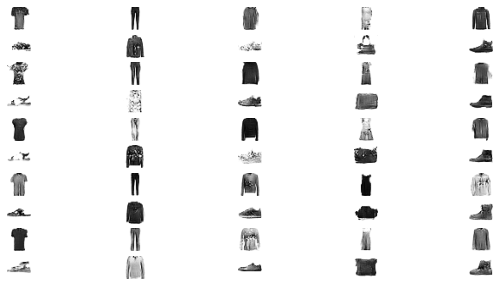

Epoch: 31 Batch 0 Loss fake: 0.246 Real: 0.230 GAN: 2.092 	 Accuracy fake: 0.875 Real: 0.922 GAN: 0.150
Epoch: 31 Batch 1 Loss fake: 0.411 Real: 0.368 GAN: 2.415 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.120
Epoch: 31 Batch 2 Loss fake: 0.322 Real: 0.430 GAN: 2.019 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.150
Epoch: 31 Batch 3 Loss fake: 0.318 Real: 0.274 GAN: 2.175 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.120
Epoch: 31 Batch 4 Loss fake: 0.346 Real: 0.324 GAN: 2.403 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.090
Epoch: 31 Batch 5 Loss fake: 0.237 Real: 0.426 GAN: 1.892 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.180
Epoch: 31 Batch 6 Loss fake: 0.409 Real: 0.240 GAN: 2.442 	 Accuracy fake: 0.797 Real: 0.906 GAN: 0.100
Epoch: 31 Batch 7 Loss fake: 0.224 Real: 0.317 GAN: 2.359 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.070
Epoch: 31 Batch 8 Loss fake: 0.215 Real: 0.336 GAN: 2.326 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.170
Epoch: 31 Batch 9 Loss fake: 0.273 Real: 0.375 GAN: 2.360 	 Accu

Epoch: 31 Batch 79 Loss fake: 0.328 Real: 0.495 GAN: 2.396 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.070
Epoch: 31 Batch 80 Loss fake: 0.258 Real: 0.645 GAN: 1.960 	 Accuracy fake: 0.938 Real: 0.703 GAN: 0.140
Epoch: 31 Batch 81 Loss fake: 0.486 Real: 0.275 GAN: 1.991 	 Accuracy fake: 0.750 Real: 0.875 GAN: 0.160
Epoch: 31 Batch 82 Loss fake: 0.429 Real: 0.308 GAN: 2.368 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.090
Epoch: 31 Batch 83 Loss fake: 0.339 Real: 0.402 GAN: 2.401 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.050
Epoch: 31 Batch 84 Loss fake: 0.166 Real: 0.532 GAN: 2.010 	 Accuracy fake: 0.938 Real: 0.703 GAN: 0.070
Epoch: 31 Batch 85 Loss fake: 0.310 Real: 0.364 GAN: 2.101 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.100
Epoch: 31 Batch 86 Loss fake: 0.460 Real: 0.289 GAN: 2.226 	 Accuracy fake: 0.766 Real: 0.875 GAN: 0.070
Epoch: 31 Batch 87 Loss fake: 0.298 Real: 0.436 GAN: 2.243 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.110
Epoch: 31 Batch 88 Loss fake: 0.305 Real: 0.293 GAN: 2.

Epoch: 31 Batch 157 Loss fake: 0.344 Real: 0.298 GAN: 2.381 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.110
Epoch: 31 Batch 158 Loss fake: 0.261 Real: 0.333 GAN: 2.377 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.070
Epoch: 31 Batch 159 Loss fake: 0.324 Real: 0.347 GAN: 2.421 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.070
Epoch: 31 Batch 160 Loss fake: 0.286 Real: 0.268 GAN: 2.517 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.090
Epoch: 31 Batch 161 Loss fake: 0.236 Real: 0.482 GAN: 2.434 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.060
Epoch: 31 Batch 162 Loss fake: 0.281 Real: 0.365 GAN: 2.408 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.130
Epoch: 31 Batch 163 Loss fake: 0.276 Real: 0.444 GAN: 2.139 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.100
Epoch: 31 Batch 164 Loss fake: 0.413 Real: 0.455 GAN: 2.121 	 Accuracy fake: 0.797 Real: 0.750 GAN: 0.100
Epoch: 31 Batch 165 Loss fake: 0.332 Real: 0.373 GAN: 2.086 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.110
Epoch: 31 Batch 166 Loss fake: 0.290 Real: 0.2

Epoch: 31 Batch 235 Loss fake: 0.279 Real: 0.245 GAN: 2.155 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.070
Epoch: 31 Batch 236 Loss fake: 0.263 Real: 0.440 GAN: 2.130 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.130
Epoch: 31 Batch 237 Loss fake: 0.255 Real: 0.414 GAN: 2.106 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.080
Epoch: 31 Batch 238 Loss fake: 0.305 Real: 0.289 GAN: 2.377 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.080
Epoch: 31 Batch 239 Loss fake: 0.321 Real: 0.393 GAN: 2.189 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.090
Epoch: 31 Batch 240 Loss fake: 0.237 Real: 0.394 GAN: 1.967 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.120
Epoch: 31 Batch 241 Loss fake: 0.328 Real: 0.338 GAN: 1.985 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.140
Epoch: 31 Batch 242 Loss fake: 0.415 Real: 0.348 GAN: 2.245 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.110
Epoch: 31 Batch 243 Loss fake: 0.304 Real: 0.336 GAN: 2.353 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.100
Epoch: 31 Batch 244 Loss fake: 0.329 Real: 0.5

Epoch: 31 Batch 313 Loss fake: 0.235 Real: 0.337 GAN: 2.016 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.150
Epoch: 31 Batch 314 Loss fake: 0.286 Real: 0.304 GAN: 1.961 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.140
Epoch: 31 Batch 315 Loss fake: 0.383 Real: 0.407 GAN: 2.301 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.120
Epoch: 31 Batch 316 Loss fake: 0.321 Real: 0.358 GAN: 2.085 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.130
Epoch: 31 Batch 317 Loss fake: 0.246 Real: 0.398 GAN: 2.151 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.130
Epoch: 31 Batch 318 Loss fake: 0.258 Real: 0.333 GAN: 2.315 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.140
Epoch: 31 Batch 319 Loss fake: 0.309 Real: 0.283 GAN: 2.314 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.080
Epoch: 31 Batch 320 Loss fake: 0.381 Real: 0.383 GAN: 2.356 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.110
Epoch: 31 Batch 321 Loss fake: 0.267 Real: 0.323 GAN: 1.924 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.190
Epoch: 31 Batch 322 Loss fake: 0.312 Real: 0.4

Epoch: 31 Batch 391 Loss fake: 0.191 Real: 0.350 GAN: 2.058 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.200
Epoch: 31 Batch 392 Loss fake: 0.464 Real: 0.298 GAN: 2.372 	 Accuracy fake: 0.703 Real: 0.875 GAN: 0.090
Epoch: 31 Batch 393 Loss fake: 0.252 Real: 0.560 GAN: 2.087 	 Accuracy fake: 0.891 Real: 0.672 GAN: 0.120
Epoch: 31 Batch 394 Loss fake: 0.479 Real: 0.288 GAN: 1.892 	 Accuracy fake: 0.781 Real: 0.875 GAN: 0.150
Epoch: 31 Batch 395 Loss fake: 0.237 Real: 0.356 GAN: 2.106 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.120
Epoch: 31 Batch 396 Loss fake: 0.269 Real: 0.383 GAN: 2.143 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.080
Epoch: 31 Batch 397 Loss fake: 0.326 Real: 0.383 GAN: 2.068 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.100
Epoch: 31 Batch 398 Loss fake: 0.393 Real: 0.308 GAN: 2.007 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.100
Epoch: 31 Batch 399 Loss fake: 0.304 Real: 0.291 GAN: 2.516 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.090
Epoch: 31 Batch 400 Loss fake: 0.284 Real: 0.4

Epoch: 32 Batch 1 Loss fake: 0.335 Real: 0.315 GAN: 1.834 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.120
Epoch: 32 Batch 2 Loss fake: 0.377 Real: 0.238 GAN: 2.165 	 Accuracy fake: 0.828 Real: 0.922 GAN: 0.080
Epoch: 32 Batch 3 Loss fake: 0.288 Real: 0.330 GAN: 2.149 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.080
Epoch: 32 Batch 4 Loss fake: 0.264 Real: 0.223 GAN: 2.243 	 Accuracy fake: 0.953 Real: 0.922 GAN: 0.130
Epoch: 32 Batch 5 Loss fake: 0.229 Real: 0.531 GAN: 2.579 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.040
Epoch: 32 Batch 6 Loss fake: 0.258 Real: 0.396 GAN: 2.246 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.140
Epoch: 32 Batch 7 Loss fake: 0.589 Real: 0.376 GAN: 2.381 	 Accuracy fake: 0.688 Real: 0.734 GAN: 0.090
Epoch: 32 Batch 8 Loss fake: 0.435 Real: 0.450 GAN: 2.652 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.040
Epoch: 32 Batch 9 Loss fake: 0.236 Real: 0.451 GAN: 2.045 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.180
Epoch: 32 Batch 10 Loss fake: 0.319 Real: 0.325 GAN: 1.995 	 Acc

Epoch: 32 Batch 80 Loss fake: 0.261 Real: 0.507 GAN: 1.900 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.130
Epoch: 32 Batch 81 Loss fake: 0.367 Real: 0.330 GAN: 2.308 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.130
Epoch: 32 Batch 82 Loss fake: 0.314 Real: 0.322 GAN: 2.257 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.160
Epoch: 32 Batch 83 Loss fake: 0.389 Real: 0.413 GAN: 2.240 	 Accuracy fake: 0.828 Real: 0.750 GAN: 0.090
Epoch: 32 Batch 84 Loss fake: 0.403 Real: 0.259 GAN: 2.508 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.080
Epoch: 32 Batch 85 Loss fake: 0.226 Real: 0.349 GAN: 2.477 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.040
Epoch: 32 Batch 86 Loss fake: 0.194 Real: 0.388 GAN: 2.099 	 Accuracy fake: 0.969 Real: 0.828 GAN: 0.030
Epoch: 32 Batch 87 Loss fake: 0.253 Real: 0.311 GAN: 2.116 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.080
Epoch: 32 Batch 88 Loss fake: 0.503 Real: 0.383 GAN: 2.238 	 Accuracy fake: 0.781 Real: 0.781 GAN: 0.060
Epoch: 32 Batch 89 Loss fake: 0.293 Real: 0.307 GAN: 1.

Epoch: 32 Batch 158 Loss fake: 0.230 Real: 0.497 GAN: 2.270 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.080
Epoch: 32 Batch 159 Loss fake: 0.351 Real: 0.296 GAN: 2.255 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.100
Epoch: 32 Batch 160 Loss fake: 0.301 Real: 0.282 GAN: 2.209 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.100
Epoch: 32 Batch 161 Loss fake: 0.355 Real: 0.376 GAN: 2.326 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.060
Epoch: 32 Batch 162 Loss fake: 0.321 Real: 0.553 GAN: 2.478 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.060
Epoch: 32 Batch 163 Loss fake: 0.325 Real: 0.437 GAN: 2.037 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.070
Epoch: 32 Batch 164 Loss fake: 0.278 Real: 0.311 GAN: 2.382 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.070
Epoch: 32 Batch 165 Loss fake: 0.350 Real: 0.427 GAN: 2.208 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.120
Epoch: 32 Batch 166 Loss fake: 0.372 Real: 0.442 GAN: 2.069 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.140
Epoch: 32 Batch 167 Loss fake: 0.305 Real: 0.2

Epoch: 32 Batch 236 Loss fake: 0.375 Real: 0.439 GAN: 1.963 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.160
Epoch: 32 Batch 237 Loss fake: 0.550 Real: 0.377 GAN: 2.260 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.070
Epoch: 32 Batch 238 Loss fake: 0.255 Real: 0.413 GAN: 2.208 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.140
Epoch: 32 Batch 239 Loss fake: 0.365 Real: 0.447 GAN: 1.942 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.170
Epoch: 32 Batch 240 Loss fake: 0.457 Real: 0.494 GAN: 2.094 	 Accuracy fake: 0.828 Real: 0.750 GAN: 0.090
Epoch: 32 Batch 241 Loss fake: 0.301 Real: 0.393 GAN: 1.950 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.110
Epoch: 32 Batch 242 Loss fake: 0.261 Real: 0.364 GAN: 2.117 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.090
Epoch: 32 Batch 243 Loss fake: 0.346 Real: 0.274 GAN: 2.144 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.090
Epoch: 32 Batch 244 Loss fake: 0.293 Real: 0.501 GAN: 2.063 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.170
Epoch: 32 Batch 245 Loss fake: 0.309 Real: 0.3

Epoch: 32 Batch 314 Loss fake: 0.276 Real: 0.405 GAN: 2.401 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.100
Epoch: 32 Batch 315 Loss fake: 0.235 Real: 0.438 GAN: 1.938 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.150
Epoch: 32 Batch 316 Loss fake: 0.304 Real: 0.266 GAN: 2.319 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.140
Epoch: 32 Batch 317 Loss fake: 0.284 Real: 0.308 GAN: 2.018 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.090
Epoch: 32 Batch 318 Loss fake: 0.471 Real: 0.410 GAN: 2.291 	 Accuracy fake: 0.781 Real: 0.812 GAN: 0.070
Epoch: 32 Batch 319 Loss fake: 0.308 Real: 0.407 GAN: 2.292 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.060
Epoch: 32 Batch 320 Loss fake: 0.271 Real: 0.538 GAN: 1.938 	 Accuracy fake: 0.875 Real: 0.719 GAN: 0.150
Epoch: 32 Batch 321 Loss fake: 0.395 Real: 0.317 GAN: 2.265 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.050
Epoch: 32 Batch 322 Loss fake: 0.293 Real: 0.460 GAN: 1.967 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.150
Epoch: 32 Batch 323 Loss fake: 0.394 Real: 0.2

Epoch: 32 Batch 392 Loss fake: 0.279 Real: 0.402 GAN: 2.049 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.130
Epoch: 32 Batch 393 Loss fake: 0.336 Real: 0.320 GAN: 2.155 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.050
Epoch: 32 Batch 394 Loss fake: 0.284 Real: 0.443 GAN: 2.314 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.060
Epoch: 32 Batch 395 Loss fake: 0.260 Real: 0.348 GAN: 1.956 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.150
Epoch: 32 Batch 396 Loss fake: 0.331 Real: 0.333 GAN: 1.946 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.160
Epoch: 32 Batch 397 Loss fake: 0.324 Real: 0.376 GAN: 2.214 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.110
Epoch: 32 Batch 398 Loss fake: 0.290 Real: 0.444 GAN: 2.113 	 Accuracy fake: 0.891 Real: 0.703 GAN: 0.080
Epoch: 32 Batch 399 Loss fake: 0.276 Real: 0.246 GAN: 2.040 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.100
Epoch: 32 Batch 400 Loss fake: 0.384 Real: 0.305 GAN: 2.250 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.090
Epoch: 32 Batch 401 Loss fake: 0.270 Real: 0.3

Epoch: 33 Batch 2 Loss fake: 0.268 Real: 0.331 GAN: 1.647 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.230
Epoch: 33 Batch 3 Loss fake: 0.408 Real: 0.240 GAN: 2.297 	 Accuracy fake: 0.781 Real: 0.875 GAN: 0.090
Epoch: 33 Batch 4 Loss fake: 0.347 Real: 0.508 GAN: 2.267 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.050
Epoch: 33 Batch 5 Loss fake: 0.314 Real: 0.472 GAN: 2.349 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.070
Epoch: 33 Batch 6 Loss fake: 0.312 Real: 0.326 GAN: 1.884 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.150
Epoch: 33 Batch 7 Loss fake: 0.273 Real: 0.349 GAN: 2.094 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.110
Epoch: 33 Batch 8 Loss fake: 0.439 Real: 0.403 GAN: 2.085 	 Accuracy fake: 0.766 Real: 0.781 GAN: 0.080
Epoch: 33 Batch 9 Loss fake: 0.347 Real: 0.346 GAN: 2.208 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.130
Epoch: 33 Batch 10 Loss fake: 0.371 Real: 0.301 GAN: 2.420 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.050
Epoch: 33 Batch 11 Loss fake: 0.187 Real: 0.392 GAN: 2.178 	 Ac

Epoch: 33 Batch 81 Loss fake: 0.292 Real: 0.174 GAN: 2.097 	 Accuracy fake: 0.906 Real: 0.938 GAN: 0.110
Epoch: 33 Batch 82 Loss fake: 0.280 Real: 0.365 GAN: 2.268 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.100
Epoch: 33 Batch 83 Loss fake: 0.326 Real: 0.483 GAN: 2.409 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.100
Epoch: 33 Batch 84 Loss fake: 0.283 Real: 0.318 GAN: 2.122 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.140
Epoch: 33 Batch 85 Loss fake: 0.277 Real: 0.306 GAN: 2.218 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.120
Epoch: 33 Batch 86 Loss fake: 0.285 Real: 0.302 GAN: 2.147 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.100
Epoch: 33 Batch 87 Loss fake: 0.233 Real: 0.352 GAN: 2.153 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.180
Epoch: 33 Batch 88 Loss fake: 0.277 Real: 0.256 GAN: 2.207 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.110
Epoch: 33 Batch 89 Loss fake: 0.263 Real: 0.419 GAN: 2.170 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.130
Epoch: 33 Batch 90 Loss fake: 0.423 Real: 0.352 GAN: 1.

Epoch: 33 Batch 159 Loss fake: 0.286 Real: 0.329 GAN: 2.243 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.140
Epoch: 33 Batch 160 Loss fake: 0.352 Real: 0.422 GAN: 1.816 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.170
Epoch: 33 Batch 161 Loss fake: 0.393 Real: 0.253 GAN: 1.870 	 Accuracy fake: 0.812 Real: 0.875 GAN: 0.180
Epoch: 33 Batch 162 Loss fake: 0.307 Real: 0.278 GAN: 2.369 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.110
Epoch: 33 Batch 163 Loss fake: 0.263 Real: 0.438 GAN: 2.376 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.160
Epoch: 33 Batch 164 Loss fake: 0.238 Real: 0.419 GAN: 1.865 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.170
Epoch: 33 Batch 165 Loss fake: 0.317 Real: 0.320 GAN: 1.994 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.160
Epoch: 33 Batch 166 Loss fake: 0.399 Real: 0.234 GAN: 2.228 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.100
Epoch: 33 Batch 167 Loss fake: 0.413 Real: 0.337 GAN: 2.503 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.050
Epoch: 33 Batch 168 Loss fake: 0.248 Real: 0.3

Epoch: 33 Batch 237 Loss fake: 0.308 Real: 0.270 GAN: 2.183 	 Accuracy fake: 0.797 Real: 0.922 GAN: 0.080
Epoch: 33 Batch 238 Loss fake: 0.225 Real: 0.444 GAN: 1.889 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.150
Epoch: 33 Batch 239 Loss fake: 0.321 Real: 0.409 GAN: 1.985 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.170
Epoch: 33 Batch 240 Loss fake: 0.411 Real: 0.289 GAN: 2.311 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.120
Epoch: 33 Batch 241 Loss fake: 0.532 Real: 0.420 GAN: 2.410 	 Accuracy fake: 0.750 Real: 0.734 GAN: 0.080
Epoch: 33 Batch 242 Loss fake: 0.203 Real: 0.326 GAN: 2.147 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.090
Epoch: 33 Batch 243 Loss fake: 0.333 Real: 0.481 GAN: 2.013 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.140
Epoch: 33 Batch 244 Loss fake: 0.230 Real: 0.307 GAN: 2.245 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.060
Epoch: 33 Batch 245 Loss fake: 0.444 Real: 0.409 GAN: 2.463 	 Accuracy fake: 0.797 Real: 0.766 GAN: 0.080
Epoch: 33 Batch 246 Loss fake: 0.313 Real: 0.4

Epoch: 33 Batch 315 Loss fake: 0.383 Real: 0.437 GAN: 1.978 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.180
Epoch: 33 Batch 316 Loss fake: 0.226 Real: 0.240 GAN: 2.045 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.140
Epoch: 33 Batch 317 Loss fake: 0.341 Real: 0.304 GAN: 2.473 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.070
Epoch: 33 Batch 318 Loss fake: 0.231 Real: 0.306 GAN: 2.167 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.080
Epoch: 33 Batch 319 Loss fake: 0.249 Real: 0.299 GAN: 2.336 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.050
Epoch: 33 Batch 320 Loss fake: 0.253 Real: 0.288 GAN: 2.349 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.080
Epoch: 33 Batch 321 Loss fake: 0.320 Real: 0.419 GAN: 2.446 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.080
Epoch: 33 Batch 322 Loss fake: 0.285 Real: 0.490 GAN: 2.133 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.110
Epoch: 33 Batch 323 Loss fake: 0.414 Real: 0.318 GAN: 2.062 	 Accuracy fake: 0.812 Real: 0.906 GAN: 0.150
Epoch: 33 Batch 324 Loss fake: 0.342 Real: 0.3

Epoch: 33 Batch 393 Loss fake: 0.281 Real: 0.249 GAN: 1.964 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.100
Epoch: 33 Batch 394 Loss fake: 0.358 Real: 0.412 GAN: 2.314 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.040
Epoch: 33 Batch 395 Loss fake: 0.419 Real: 0.723 GAN: 2.006 	 Accuracy fake: 0.844 Real: 0.609 GAN: 0.110
Epoch: 33 Batch 396 Loss fake: 0.404 Real: 0.228 GAN: 2.020 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.090
Epoch: 33 Batch 397 Loss fake: 0.582 Real: 0.280 GAN: 2.436 	 Accuracy fake: 0.797 Real: 0.922 GAN: 0.090
Epoch: 33 Batch 398 Loss fake: 0.278 Real: 0.469 GAN: 2.233 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.090
Epoch: 33 Batch 399 Loss fake: 0.280 Real: 0.425 GAN: 1.974 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.160
Epoch: 33 Batch 400 Loss fake: 0.367 Real: 0.215 GAN: 2.075 	 Accuracy fake: 0.844 Real: 0.938 GAN: 0.130
Epoch: 33 Batch 401 Loss fake: 0.234 Real: 0.311 GAN: 2.243 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.100
Epoch: 33 Batch 402 Loss fake: 0.305 Real: 0.2

Epoch: 34 Batch 3 Loss fake: 0.310 Real: 0.282 GAN: 2.422 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.050
Epoch: 34 Batch 4 Loss fake: 0.168 Real: 0.440 GAN: 2.364 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.150
Epoch: 34 Batch 5 Loss fake: 0.234 Real: 0.236 GAN: 2.043 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.130
Epoch: 34 Batch 6 Loss fake: 0.358 Real: 0.268 GAN: 2.213 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.090
Epoch: 34 Batch 7 Loss fake: 0.345 Real: 0.395 GAN: 2.254 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.140
Epoch: 34 Batch 8 Loss fake: 0.225 Real: 0.320 GAN: 2.214 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.130
Epoch: 34 Batch 9 Loss fake: 0.386 Real: 0.570 GAN: 2.023 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.130
Epoch: 34 Batch 10 Loss fake: 0.247 Real: 0.404 GAN: 2.004 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.100
Epoch: 34 Batch 11 Loss fake: 0.301 Real: 0.217 GAN: 2.202 	 Accuracy fake: 0.875 Real: 0.938 GAN: 0.120
Epoch: 34 Batch 12 Loss fake: 0.295 Real: 0.264 GAN: 2.075 	 A

Epoch: 34 Batch 82 Loss fake: 0.257 Real: 0.280 GAN: 1.935 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.190
Epoch: 34 Batch 83 Loss fake: 0.274 Real: 0.336 GAN: 2.118 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.090
Epoch: 34 Batch 84 Loss fake: 0.295 Real: 0.354 GAN: 2.046 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.150
Epoch: 34 Batch 85 Loss fake: 0.261 Real: 0.165 GAN: 2.202 	 Accuracy fake: 0.938 Real: 0.953 GAN: 0.090
Epoch: 34 Batch 86 Loss fake: 0.394 Real: 0.386 GAN: 1.992 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.160
Epoch: 34 Batch 87 Loss fake: 0.314 Real: 0.389 GAN: 2.197 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.140
Epoch: 34 Batch 88 Loss fake: 0.425 Real: 0.366 GAN: 2.278 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.130
Epoch: 34 Batch 89 Loss fake: 0.271 Real: 0.420 GAN: 2.279 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.070
Epoch: 34 Batch 90 Loss fake: 0.317 Real: 0.269 GAN: 2.500 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.050
Epoch: 34 Batch 91 Loss fake: 0.260 Real: 0.389 GAN: 2.

Epoch: 34 Batch 160 Loss fake: 0.309 Real: 0.226 GAN: 2.051 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.120
Epoch: 34 Batch 161 Loss fake: 0.425 Real: 0.197 GAN: 2.458 	 Accuracy fake: 0.844 Real: 0.906 GAN: 0.150
Epoch: 34 Batch 162 Loss fake: 0.234 Real: 0.647 GAN: 2.096 	 Accuracy fake: 0.938 Real: 0.688 GAN: 0.100
Epoch: 34 Batch 163 Loss fake: 0.250 Real: 0.296 GAN: 1.985 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.140
Epoch: 34 Batch 164 Loss fake: 0.356 Real: 0.433 GAN: 1.998 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.140
Epoch: 34 Batch 165 Loss fake: 0.371 Real: 0.256 GAN: 2.313 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.100
Epoch: 34 Batch 166 Loss fake: 0.248 Real: 0.480 GAN: 2.264 	 Accuracy fake: 0.938 Real: 0.719 GAN: 0.110
Epoch: 34 Batch 167 Loss fake: 0.300 Real: 0.356 GAN: 2.051 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.110
Epoch: 34 Batch 168 Loss fake: 0.364 Real: 0.379 GAN: 2.259 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.100
Epoch: 34 Batch 169 Loss fake: 0.321 Real: 0.4

Epoch: 34 Batch 238 Loss fake: 0.337 Real: 0.303 GAN: 2.158 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.080
Epoch: 34 Batch 239 Loss fake: 0.329 Real: 0.393 GAN: 2.348 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.060
Epoch: 34 Batch 240 Loss fake: 0.305 Real: 0.420 GAN: 2.246 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.100
Epoch: 34 Batch 241 Loss fake: 0.263 Real: 0.335 GAN: 2.042 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.120
Epoch: 34 Batch 242 Loss fake: 0.332 Real: 0.439 GAN: 2.007 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.150
Epoch: 34 Batch 243 Loss fake: 0.242 Real: 0.304 GAN: 1.993 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.160
Epoch: 34 Batch 244 Loss fake: 0.378 Real: 0.248 GAN: 2.238 	 Accuracy fake: 0.828 Real: 0.906 GAN: 0.100
Epoch: 34 Batch 245 Loss fake: 0.294 Real: 0.396 GAN: 2.340 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.060
Epoch: 34 Batch 246 Loss fake: 0.300 Real: 0.289 GAN: 2.367 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.030
Epoch: 34 Batch 247 Loss fake: 0.218 Real: 0.4

Epoch: 34 Batch 316 Loss fake: 0.363 Real: 0.793 GAN: 2.164 	 Accuracy fake: 0.812 Real: 0.625 GAN: 0.080
Epoch: 34 Batch 317 Loss fake: 0.346 Real: 0.265 GAN: 2.188 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.130
Epoch: 34 Batch 318 Loss fake: 0.325 Real: 0.340 GAN: 2.413 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.040
Epoch: 34 Batch 319 Loss fake: 0.269 Real: 0.462 GAN: 2.168 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.090
Epoch: 34 Batch 320 Loss fake: 0.194 Real: 0.373 GAN: 1.961 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.140
Epoch: 34 Batch 321 Loss fake: 0.367 Real: 0.382 GAN: 1.774 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.160
Epoch: 34 Batch 322 Loss fake: 0.502 Real: 0.251 GAN: 2.447 	 Accuracy fake: 0.766 Real: 0.875 GAN: 0.090
Epoch: 34 Batch 323 Loss fake: 0.260 Real: 0.395 GAN: 2.382 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.100
Epoch: 34 Batch 324 Loss fake: 0.283 Real: 0.444 GAN: 2.012 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.130
Epoch: 34 Batch 325 Loss fake: 0.239 Real: 0.2

Epoch: 34 Batch 394 Loss fake: 0.258 Real: 0.267 GAN: 2.118 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.120
Epoch: 34 Batch 395 Loss fake: 0.253 Real: 0.314 GAN: 2.013 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.060
Epoch: 34 Batch 396 Loss fake: 0.284 Real: 0.325 GAN: 2.266 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.120
Epoch: 34 Batch 397 Loss fake: 0.363 Real: 0.285 GAN: 2.406 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.090
Epoch: 34 Batch 398 Loss fake: 0.324 Real: 0.521 GAN: 2.279 	 Accuracy fake: 0.875 Real: 0.703 GAN: 0.090
Epoch: 34 Batch 399 Loss fake: 0.173 Real: 0.305 GAN: 2.288 	 Accuracy fake: 0.953 Real: 0.875 GAN: 0.030
Epoch: 34 Batch 400 Loss fake: 0.265 Real: 0.454 GAN: 1.915 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.250
Epoch: 34 Batch 401 Loss fake: 0.382 Real: 0.190 GAN: 2.163 	 Accuracy fake: 0.828 Real: 0.906 GAN: 0.060
Epoch: 34 Batch 402 Loss fake: 0.309 Real: 0.520 GAN: 2.063 	 Accuracy fake: 0.875 Real: 0.734 GAN: 0.100
Epoch: 34 Batch 403 Loss fake: 0.309 Real: 0.2

Epoch: 35 Batch 4 Loss fake: 0.290 Real: 0.227 GAN: 2.383 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.080
Epoch: 35 Batch 5 Loss fake: 0.221 Real: 0.383 GAN: 2.322 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.110
Epoch: 35 Batch 6 Loss fake: 0.284 Real: 0.330 GAN: 2.315 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.100
Epoch: 35 Batch 7 Loss fake: 0.297 Real: 0.503 GAN: 1.927 	 Accuracy fake: 0.859 Real: 0.688 GAN: 0.160
Epoch: 35 Batch 8 Loss fake: 0.398 Real: 0.515 GAN: 2.299 	 Accuracy fake: 0.844 Real: 0.719 GAN: 0.140
Epoch: 35 Batch 9 Loss fake: 0.241 Real: 0.405 GAN: 1.839 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.150
Epoch: 35 Batch 10 Loss fake: 0.379 Real: 0.232 GAN: 1.986 	 Accuracy fake: 0.812 Real: 0.906 GAN: 0.170
Epoch: 35 Batch 11 Loss fake: 0.355 Real: 0.300 GAN: 2.291 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.170
Epoch: 35 Batch 12 Loss fake: 0.398 Real: 0.543 GAN: 2.100 	 Accuracy fake: 0.781 Real: 0.750 GAN: 0.130
Epoch: 35 Batch 13 Loss fake: 0.338 Real: 0.370 GAN: 2.047 	 

Epoch: 35 Batch 83 Loss fake: 0.390 Real: 0.609 GAN: 1.903 	 Accuracy fake: 0.781 Real: 0.672 GAN: 0.140
Epoch: 35 Batch 84 Loss fake: 0.439 Real: 0.299 GAN: 2.248 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.120
Epoch: 35 Batch 85 Loss fake: 0.263 Real: 0.385 GAN: 2.060 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.160
Epoch: 35 Batch 86 Loss fake: 0.400 Real: 0.320 GAN: 2.137 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.120
Epoch: 35 Batch 87 Loss fake: 0.226 Real: 0.388 GAN: 2.254 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.120
Epoch: 35 Batch 88 Loss fake: 0.278 Real: 0.317 GAN: 2.247 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.150
Epoch: 35 Batch 89 Loss fake: 0.349 Real: 0.383 GAN: 2.179 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.140
Epoch: 35 Batch 90 Loss fake: 0.296 Real: 0.344 GAN: 2.269 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.100
Epoch: 35 Batch 91 Loss fake: 0.423 Real: 0.240 GAN: 2.157 	 Accuracy fake: 0.812 Real: 0.891 GAN: 0.050
Epoch: 35 Batch 92 Loss fake: 0.273 Real: 0.482 GAN: 2.

Epoch: 35 Batch 161 Loss fake: 0.363 Real: 0.383 GAN: 2.211 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.120
Epoch: 35 Batch 162 Loss fake: 0.442 Real: 0.316 GAN: 2.255 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.140
Epoch: 35 Batch 163 Loss fake: 0.396 Real: 0.490 GAN: 2.380 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.100
Epoch: 35 Batch 164 Loss fake: 0.404 Real: 0.540 GAN: 2.268 	 Accuracy fake: 0.781 Real: 0.734 GAN: 0.130
Epoch: 35 Batch 165 Loss fake: 0.311 Real: 0.392 GAN: 1.998 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.190
Epoch: 35 Batch 166 Loss fake: 0.402 Real: 0.330 GAN: 2.216 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.080
Epoch: 35 Batch 167 Loss fake: 0.260 Real: 0.268 GAN: 2.396 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.110
Epoch: 35 Batch 168 Loss fake: 0.259 Real: 0.391 GAN: 2.488 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.060
Epoch: 35 Batch 169 Loss fake: 0.233 Real: 0.427 GAN: 2.025 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.150
Epoch: 35 Batch 170 Loss fake: 0.402 Real: 0.4

Epoch: 35 Batch 239 Loss fake: 0.205 Real: 0.372 GAN: 2.188 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.110
Epoch: 35 Batch 240 Loss fake: 0.316 Real: 0.431 GAN: 2.276 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.100
Epoch: 35 Batch 241 Loss fake: 0.331 Real: 0.289 GAN: 2.404 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.100
Epoch: 35 Batch 242 Loss fake: 0.264 Real: 0.609 GAN: 2.153 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.100
Epoch: 35 Batch 243 Loss fake: 0.235 Real: 0.371 GAN: 2.016 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.120
Epoch: 35 Batch 244 Loss fake: 0.575 Real: 0.332 GAN: 2.070 	 Accuracy fake: 0.734 Real: 0.844 GAN: 0.120
Epoch: 35 Batch 245 Loss fake: 0.319 Real: 0.434 GAN: 1.877 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.140
Epoch: 35 Batch 246 Loss fake: 0.268 Real: 0.533 GAN: 1.974 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.200
Epoch: 35 Batch 247 Loss fake: 0.381 Real: 0.282 GAN: 1.923 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.120
Epoch: 35 Batch 248 Loss fake: 0.380 Real: 0.3

Epoch: 35 Batch 317 Loss fake: 0.410 Real: 0.423 GAN: 2.293 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.050
Epoch: 35 Batch 318 Loss fake: 0.329 Real: 0.436 GAN: 2.041 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.150
Epoch: 35 Batch 319 Loss fake: 0.247 Real: 0.393 GAN: 1.788 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.160
Epoch: 35 Batch 320 Loss fake: 0.332 Real: 0.294 GAN: 2.093 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.090
Epoch: 35 Batch 321 Loss fake: 0.274 Real: 0.475 GAN: 1.964 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.130
Epoch: 35 Batch 322 Loss fake: 0.307 Real: 0.333 GAN: 1.752 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.240
Epoch: 35 Batch 323 Loss fake: 0.440 Real: 0.353 GAN: 2.461 	 Accuracy fake: 0.734 Real: 0.781 GAN: 0.100
Epoch: 35 Batch 324 Loss fake: 0.281 Real: 0.446 GAN: 1.953 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.140
Epoch: 35 Batch 325 Loss fake: 0.380 Real: 0.358 GAN: 2.129 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.150
Epoch: 35 Batch 326 Loss fake: 0.350 Real: 0.4

Epoch: 35 Batch 395 Loss fake: 0.398 Real: 0.397 GAN: 2.124 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.130
Epoch: 35 Batch 396 Loss fake: 0.285 Real: 0.256 GAN: 2.119 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.100
Epoch: 35 Batch 397 Loss fake: 0.226 Real: 0.308 GAN: 1.894 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.140
Epoch: 35 Batch 398 Loss fake: 0.309 Real: 0.193 GAN: 2.065 	 Accuracy fake: 0.875 Real: 0.938 GAN: 0.100
Epoch: 35 Batch 399 Loss fake: 0.296 Real: 0.448 GAN: 2.216 	 Accuracy fake: 0.828 Real: 0.766 GAN: 0.090
Epoch: 35 Batch 400 Loss fake: 0.235 Real: 0.348 GAN: 2.277 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.080
Epoch: 35 Batch 401 Loss fake: 0.256 Real: 0.301 GAN: 2.070 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.130
Epoch: 35 Batch 402 Loss fake: 0.316 Real: 0.369 GAN: 2.372 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.120
Epoch: 35 Batch 403 Loss fake: 0.352 Real: 0.331 GAN: 2.317 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.090
Epoch: 35 Batch 404 Loss fake: 0.239 Real: 0.3

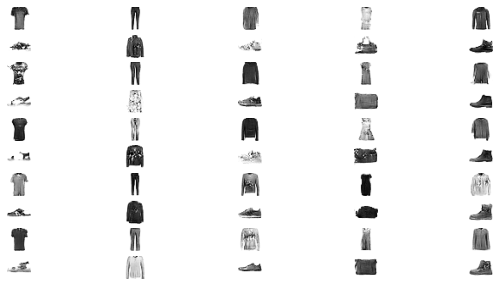

Epoch: 36 Batch 0 Loss fake: 0.437 Real: 0.246 GAN: 2.343 	 Accuracy fake: 0.812 Real: 0.891 GAN: 0.040
Epoch: 36 Batch 1 Loss fake: 0.294 Real: 0.344 GAN: 2.528 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.040
Epoch: 36 Batch 2 Loss fake: 0.260 Real: 0.508 GAN: 2.265 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.130
Epoch: 36 Batch 3 Loss fake: 0.243 Real: 0.359 GAN: 1.830 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.180
Epoch: 36 Batch 4 Loss fake: 0.346 Real: 0.349 GAN: 2.080 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.120
Epoch: 36 Batch 5 Loss fake: 0.344 Real: 0.296 GAN: 1.967 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.180
Epoch: 36 Batch 6 Loss fake: 0.348 Real: 0.456 GAN: 2.340 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.100
Epoch: 36 Batch 7 Loss fake: 0.325 Real: 0.255 GAN: 2.386 	 Accuracy fake: 0.891 Real: 0.922 GAN: 0.130
Epoch: 36 Batch 8 Loss fake: 0.298 Real: 0.421 GAN: 1.974 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.130
Epoch: 36 Batch 9 Loss fake: 0.289 Real: 0.335 GAN: 1.893 	 Accu

Epoch: 36 Batch 79 Loss fake: 0.354 Real: 0.392 GAN: 2.506 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.080
Epoch: 36 Batch 80 Loss fake: 0.228 Real: 0.351 GAN: 2.268 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.150
Epoch: 36 Batch 81 Loss fake: 0.324 Real: 0.389 GAN: 1.980 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.190
Epoch: 36 Batch 82 Loss fake: 0.349 Real: 0.327 GAN: 1.909 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.140
Epoch: 36 Batch 83 Loss fake: 0.423 Real: 0.373 GAN: 2.096 	 Accuracy fake: 0.750 Real: 0.812 GAN: 0.120
Epoch: 36 Batch 84 Loss fake: 0.438 Real: 0.247 GAN: 2.258 	 Accuracy fake: 0.781 Real: 0.906 GAN: 0.120
Epoch: 36 Batch 85 Loss fake: 0.306 Real: 0.444 GAN: 2.383 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.090
Epoch: 36 Batch 86 Loss fake: 0.265 Real: 0.401 GAN: 2.148 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.110
Epoch: 36 Batch 87 Loss fake: 0.332 Real: 0.374 GAN: 2.174 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.040
Epoch: 36 Batch 88 Loss fake: 0.270 Real: 0.575 GAN: 1.

Epoch: 36 Batch 157 Loss fake: 0.345 Real: 0.305 GAN: 2.525 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.090
Epoch: 36 Batch 158 Loss fake: 0.189 Real: 0.341 GAN: 2.078 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.190
Epoch: 36 Batch 159 Loss fake: 0.324 Real: 0.265 GAN: 2.140 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.130
Epoch: 36 Batch 160 Loss fake: 0.391 Real: 0.323 GAN: 2.258 	 Accuracy fake: 0.781 Real: 0.828 GAN: 0.090
Epoch: 36 Batch 161 Loss fake: 0.258 Real: 0.402 GAN: 2.183 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.090
Epoch: 36 Batch 162 Loss fake: 0.252 Real: 0.310 GAN: 2.347 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.170
Epoch: 36 Batch 163 Loss fake: 0.332 Real: 0.340 GAN: 2.307 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.150
Epoch: 36 Batch 164 Loss fake: 0.295 Real: 0.472 GAN: 2.308 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.110
Epoch: 36 Batch 165 Loss fake: 0.541 Real: 0.338 GAN: 2.116 	 Accuracy fake: 0.781 Real: 0.781 GAN: 0.090
Epoch: 36 Batch 166 Loss fake: 0.290 Real: 0.4

Epoch: 36 Batch 235 Loss fake: 0.240 Real: 0.452 GAN: 2.091 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.130
Epoch: 36 Batch 236 Loss fake: 0.355 Real: 0.307 GAN: 2.029 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.130
Epoch: 36 Batch 237 Loss fake: 0.345 Real: 0.323 GAN: 2.277 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.110
Epoch: 36 Batch 238 Loss fake: 0.243 Real: 0.405 GAN: 2.120 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.110
Epoch: 36 Batch 239 Loss fake: 0.270 Real: 0.352 GAN: 1.774 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.160
Epoch: 36 Batch 240 Loss fake: 0.465 Real: 0.280 GAN: 2.150 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.090
Epoch: 36 Batch 241 Loss fake: 0.216 Real: 0.299 GAN: 2.158 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.100
Epoch: 36 Batch 242 Loss fake: 0.236 Real: 0.366 GAN: 2.127 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.130
Epoch: 36 Batch 243 Loss fake: 0.349 Real: 0.171 GAN: 2.273 	 Accuracy fake: 0.812 Real: 0.938 GAN: 0.110
Epoch: 36 Batch 244 Loss fake: 0.336 Real: 0.3

Epoch: 36 Batch 313 Loss fake: 0.260 Real: 0.475 GAN: 2.078 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.150
Epoch: 36 Batch 314 Loss fake: 0.322 Real: 0.439 GAN: 1.940 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.120
Epoch: 36 Batch 315 Loss fake: 0.235 Real: 0.299 GAN: 2.043 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.150
Epoch: 36 Batch 316 Loss fake: 0.445 Real: 0.309 GAN: 2.350 	 Accuracy fake: 0.766 Real: 0.844 GAN: 0.100
Epoch: 36 Batch 317 Loss fake: 0.305 Real: 0.340 GAN: 2.277 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.110
Epoch: 36 Batch 318 Loss fake: 0.179 Real: 0.393 GAN: 2.184 	 Accuracy fake: 0.984 Real: 0.750 GAN: 0.120
Epoch: 36 Batch 319 Loss fake: 0.337 Real: 0.292 GAN: 2.114 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.120
Epoch: 36 Batch 320 Loss fake: 0.290 Real: 0.380 GAN: 2.060 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.170
Epoch: 36 Batch 321 Loss fake: 0.419 Real: 0.371 GAN: 2.245 	 Accuracy fake: 0.750 Real: 0.859 GAN: 0.070
Epoch: 36 Batch 322 Loss fake: 0.242 Real: 0.3

Epoch: 36 Batch 391 Loss fake: 0.280 Real: 0.340 GAN: 2.158 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.070
Epoch: 36 Batch 392 Loss fake: 0.322 Real: 0.428 GAN: 2.019 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.160
Epoch: 36 Batch 393 Loss fake: 0.273 Real: 0.298 GAN: 1.977 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.150
Epoch: 36 Batch 394 Loss fake: 0.454 Real: 0.399 GAN: 2.186 	 Accuracy fake: 0.797 Real: 0.844 GAN: 0.100
Epoch: 36 Batch 395 Loss fake: 0.241 Real: 0.459 GAN: 2.377 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.090
Epoch: 36 Batch 396 Loss fake: 0.220 Real: 0.303 GAN: 2.106 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.130
Epoch: 36 Batch 397 Loss fake: 0.392 Real: 0.495 GAN: 2.047 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.090
Epoch: 36 Batch 398 Loss fake: 0.337 Real: 0.287 GAN: 2.263 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.130
Epoch: 36 Batch 399 Loss fake: 0.376 Real: 0.460 GAN: 2.199 	 Accuracy fake: 0.828 Real: 0.719 GAN: 0.090
Epoch: 36 Batch 400 Loss fake: 0.309 Real: 0.3

Epoch: 37 Batch 1 Loss fake: 0.366 Real: 0.410 GAN: 2.039 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.160
Epoch: 37 Batch 2 Loss fake: 0.248 Real: 0.317 GAN: 2.246 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.150
Epoch: 37 Batch 3 Loss fake: 0.333 Real: 0.352 GAN: 2.355 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.070
Epoch: 37 Batch 4 Loss fake: 0.295 Real: 0.363 GAN: 2.098 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.100
Epoch: 37 Batch 5 Loss fake: 0.269 Real: 0.516 GAN: 2.144 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.050
Epoch: 37 Batch 6 Loss fake: 0.248 Real: 0.312 GAN: 2.146 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.110
Epoch: 37 Batch 7 Loss fake: 0.312 Real: 0.343 GAN: 2.031 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.140
Epoch: 37 Batch 8 Loss fake: 0.353 Real: 0.298 GAN: 2.284 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.130
Epoch: 37 Batch 9 Loss fake: 0.291 Real: 0.377 GAN: 2.644 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.070
Epoch: 37 Batch 10 Loss fake: 0.317 Real: 0.376 GAN: 2.161 	 Acc

Epoch: 37 Batch 80 Loss fake: 0.405 Real: 0.392 GAN: 2.114 	 Accuracy fake: 0.797 Real: 0.797 GAN: 0.060
Epoch: 37 Batch 81 Loss fake: 0.283 Real: 0.451 GAN: 2.172 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.090
Epoch: 37 Batch 82 Loss fake: 0.419 Real: 0.664 GAN: 1.636 	 Accuracy fake: 0.859 Real: 0.641 GAN: 0.170
Epoch: 37 Batch 83 Loss fake: 0.399 Real: 0.300 GAN: 1.997 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.130
Epoch: 37 Batch 84 Loss fake: 0.391 Real: 0.371 GAN: 2.106 	 Accuracy fake: 0.766 Real: 0.828 GAN: 0.090
Epoch: 37 Batch 85 Loss fake: 0.345 Real: 0.418 GAN: 2.173 	 Accuracy fake: 0.828 Real: 0.734 GAN: 0.070
Epoch: 37 Batch 86 Loss fake: 0.237 Real: 0.445 GAN: 1.787 	 Accuracy fake: 0.938 Real: 0.734 GAN: 0.140
Epoch: 37 Batch 87 Loss fake: 0.365 Real: 0.450 GAN: 2.123 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.140
Epoch: 37 Batch 88 Loss fake: 0.337 Real: 0.398 GAN: 2.213 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.080
Epoch: 37 Batch 89 Loss fake: 0.284 Real: 0.286 GAN: 2.

Epoch: 37 Batch 158 Loss fake: 0.331 Real: 0.361 GAN: 2.243 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.090
Epoch: 37 Batch 159 Loss fake: 0.298 Real: 0.303 GAN: 2.393 	 Accuracy fake: 0.938 Real: 0.891 GAN: 0.080
Epoch: 37 Batch 160 Loss fake: 0.286 Real: 0.358 GAN: 2.355 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.070
Epoch: 37 Batch 161 Loss fake: 0.214 Real: 0.238 GAN: 2.426 	 Accuracy fake: 0.969 Real: 0.922 GAN: 0.110
Epoch: 37 Batch 162 Loss fake: 0.237 Real: 0.505 GAN: 1.876 	 Accuracy fake: 0.938 Real: 0.703 GAN: 0.120
Epoch: 37 Batch 163 Loss fake: 0.310 Real: 0.204 GAN: 2.298 	 Accuracy fake: 0.906 Real: 0.953 GAN: 0.060
Epoch: 37 Batch 164 Loss fake: 0.306 Real: 0.332 GAN: 2.001 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.120
Epoch: 37 Batch 165 Loss fake: 0.443 Real: 0.255 GAN: 2.233 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.100
Epoch: 37 Batch 166 Loss fake: 0.288 Real: 0.387 GAN: 2.274 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.090
Epoch: 37 Batch 167 Loss fake: 0.330 Real: 0.5

Epoch: 37 Batch 236 Loss fake: 0.250 Real: 0.268 GAN: 2.345 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.050
Epoch: 37 Batch 237 Loss fake: 0.318 Real: 0.339 GAN: 2.224 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.100
Epoch: 37 Batch 238 Loss fake: 0.294 Real: 0.296 GAN: 2.382 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.090
Epoch: 37 Batch 239 Loss fake: 0.206 Real: 0.270 GAN: 2.279 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.130
Epoch: 37 Batch 240 Loss fake: 0.193 Real: 0.268 GAN: 2.142 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.120
Epoch: 37 Batch 241 Loss fake: 0.323 Real: 0.433 GAN: 2.424 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.100
Epoch: 37 Batch 242 Loss fake: 0.334 Real: 0.415 GAN: 2.168 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.150
Epoch: 37 Batch 243 Loss fake: 0.254 Real: 0.336 GAN: 2.004 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.090
Epoch: 37 Batch 244 Loss fake: 0.331 Real: 0.420 GAN: 2.222 	 Accuracy fake: 0.812 Real: 0.750 GAN: 0.140
Epoch: 37 Batch 245 Loss fake: 0.364 Real: 0.3

Epoch: 37 Batch 314 Loss fake: 0.181 Real: 0.278 GAN: 2.225 	 Accuracy fake: 0.969 Real: 0.875 GAN: 0.110
Epoch: 37 Batch 315 Loss fake: 0.237 Real: 0.361 GAN: 2.039 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.100
Epoch: 37 Batch 316 Loss fake: 0.375 Real: 0.395 GAN: 2.218 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.070
Epoch: 37 Batch 317 Loss fake: 0.352 Real: 0.422 GAN: 2.118 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.080
Epoch: 37 Batch 318 Loss fake: 0.300 Real: 0.392 GAN: 2.150 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.110
Epoch: 37 Batch 319 Loss fake: 0.410 Real: 0.231 GAN: 2.330 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.070
Epoch: 37 Batch 320 Loss fake: 0.280 Real: 0.364 GAN: 2.146 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.140
Epoch: 37 Batch 321 Loss fake: 0.191 Real: 0.481 GAN: 1.909 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.140
Epoch: 37 Batch 322 Loss fake: 0.343 Real: 0.227 GAN: 2.275 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.150
Epoch: 37 Batch 323 Loss fake: 0.335 Real: 0.3

Epoch: 37 Batch 392 Loss fake: 0.259 Real: 0.432 GAN: 2.029 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.190
Epoch: 37 Batch 393 Loss fake: 0.366 Real: 0.513 GAN: 2.120 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.170
Epoch: 37 Batch 394 Loss fake: 0.322 Real: 0.320 GAN: 2.344 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.120
Epoch: 37 Batch 395 Loss fake: 0.444 Real: 0.411 GAN: 2.334 	 Accuracy fake: 0.781 Real: 0.781 GAN: 0.100
Epoch: 37 Batch 396 Loss fake: 0.234 Real: 0.269 GAN: 2.293 	 Accuracy fake: 0.953 Real: 0.922 GAN: 0.060
Epoch: 37 Batch 397 Loss fake: 0.413 Real: 0.425 GAN: 2.365 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.070
Epoch: 37 Batch 398 Loss fake: 0.344 Real: 0.397 GAN: 2.536 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.050
Epoch: 37 Batch 399 Loss fake: 0.186 Real: 0.384 GAN: 2.250 	 Accuracy fake: 0.969 Real: 0.828 GAN: 0.070
Epoch: 37 Batch 400 Loss fake: 0.409 Real: 0.392 GAN: 2.219 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.100
Epoch: 37 Batch 401 Loss fake: 0.291 Real: 0.3

Epoch: 38 Batch 2 Loss fake: 0.491 Real: 0.323 GAN: 1.903 	 Accuracy fake: 0.781 Real: 0.812 GAN: 0.150
Epoch: 38 Batch 3 Loss fake: 0.330 Real: 0.355 GAN: 2.389 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.040
Epoch: 38 Batch 4 Loss fake: 0.303 Real: 0.447 GAN: 2.336 	 Accuracy fake: 0.891 Real: 0.688 GAN: 0.110
Epoch: 38 Batch 5 Loss fake: 0.271 Real: 0.299 GAN: 2.186 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.180
Epoch: 38 Batch 6 Loss fake: 0.296 Real: 0.379 GAN: 2.002 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.150
Epoch: 38 Batch 7 Loss fake: 0.378 Real: 0.375 GAN: 1.861 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.150
Epoch: 38 Batch 8 Loss fake: 0.371 Real: 0.326 GAN: 2.219 	 Accuracy fake: 0.781 Real: 0.875 GAN: 0.130
Epoch: 38 Batch 9 Loss fake: 0.267 Real: 0.351 GAN: 2.530 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.080
Epoch: 38 Batch 10 Loss fake: 0.314 Real: 0.307 GAN: 2.374 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.100
Epoch: 38 Batch 11 Loss fake: 0.258 Real: 0.404 GAN: 2.410 	 Ac

Epoch: 38 Batch 81 Loss fake: 0.264 Real: 0.353 GAN: 1.927 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.180
Epoch: 38 Batch 82 Loss fake: 0.348 Real: 0.343 GAN: 2.004 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.090
Epoch: 38 Batch 83 Loss fake: 0.323 Real: 0.228 GAN: 2.263 	 Accuracy fake: 0.875 Real: 0.938 GAN: 0.130
Epoch: 38 Batch 84 Loss fake: 0.275 Real: 0.253 GAN: 2.617 	 Accuracy fake: 0.953 Real: 0.891 GAN: 0.020
Epoch: 38 Batch 85 Loss fake: 0.245 Real: 0.438 GAN: 2.317 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.040
Epoch: 38 Batch 86 Loss fake: 0.308 Real: 0.320 GAN: 2.213 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.150
Epoch: 38 Batch 87 Loss fake: 0.398 Real: 0.374 GAN: 2.337 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.100
Epoch: 38 Batch 88 Loss fake: 0.297 Real: 0.338 GAN: 2.289 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.080
Epoch: 38 Batch 89 Loss fake: 0.281 Real: 0.545 GAN: 2.233 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.140
Epoch: 38 Batch 90 Loss fake: 0.284 Real: 0.284 GAN: 2.

Epoch: 38 Batch 159 Loss fake: 0.202 Real: 0.334 GAN: 2.062 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.160
Epoch: 38 Batch 160 Loss fake: 0.567 Real: 0.330 GAN: 2.258 	 Accuracy fake: 0.750 Real: 0.828 GAN: 0.130
Epoch: 38 Batch 161 Loss fake: 0.324 Real: 0.428 GAN: 2.112 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.130
Epoch: 38 Batch 162 Loss fake: 0.242 Real: 0.335 GAN: 2.223 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.100
Epoch: 38 Batch 163 Loss fake: 0.376 Real: 0.484 GAN: 2.085 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.100
Epoch: 38 Batch 164 Loss fake: 0.408 Real: 0.360 GAN: 2.629 	 Accuracy fake: 0.797 Real: 0.781 GAN: 0.070
Epoch: 38 Batch 165 Loss fake: 0.220 Real: 0.545 GAN: 2.168 	 Accuracy fake: 0.938 Real: 0.672 GAN: 0.110
Epoch: 38 Batch 166 Loss fake: 0.441 Real: 0.296 GAN: 2.134 	 Accuracy fake: 0.781 Real: 0.844 GAN: 0.140
Epoch: 38 Batch 167 Loss fake: 0.366 Real: 0.384 GAN: 2.135 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.110
Epoch: 38 Batch 168 Loss fake: 0.253 Real: 0.2

Epoch: 38 Batch 237 Loss fake: 0.305 Real: 0.365 GAN: 2.024 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.170
Epoch: 38 Batch 238 Loss fake: 0.252 Real: 0.278 GAN: 1.897 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.140
Epoch: 38 Batch 239 Loss fake: 0.346 Real: 0.261 GAN: 2.193 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.090
Epoch: 38 Batch 240 Loss fake: 0.313 Real: 0.367 GAN: 2.335 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.080
Epoch: 38 Batch 241 Loss fake: 0.241 Real: 0.339 GAN: 2.115 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.130
Epoch: 38 Batch 242 Loss fake: 0.350 Real: 0.468 GAN: 2.126 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.150
Epoch: 38 Batch 243 Loss fake: 0.463 Real: 0.276 GAN: 2.078 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.140
Epoch: 38 Batch 244 Loss fake: 0.271 Real: 0.433 GAN: 2.579 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.040
Epoch: 38 Batch 245 Loss fake: 0.214 Real: 0.403 GAN: 2.204 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.090
Epoch: 38 Batch 246 Loss fake: 0.312 Real: 0.3

Epoch: 38 Batch 315 Loss fake: 0.285 Real: 0.218 GAN: 2.610 	 Accuracy fake: 0.875 Real: 0.906 GAN: 0.110
Epoch: 38 Batch 316 Loss fake: 0.279 Real: 0.470 GAN: 2.450 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.070
Epoch: 38 Batch 317 Loss fake: 0.324 Real: 0.423 GAN: 2.142 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.080
Epoch: 38 Batch 318 Loss fake: 0.302 Real: 0.329 GAN: 2.339 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.070
Epoch: 38 Batch 319 Loss fake: 0.497 Real: 0.376 GAN: 2.075 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.060
Epoch: 38 Batch 320 Loss fake: 0.255 Real: 0.380 GAN: 2.306 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.140
Epoch: 38 Batch 321 Loss fake: 0.414 Real: 0.486 GAN: 2.184 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.110
Epoch: 38 Batch 322 Loss fake: 0.360 Real: 0.384 GAN: 2.099 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.120
Epoch: 38 Batch 323 Loss fake: 0.291 Real: 0.365 GAN: 2.144 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.120
Epoch: 38 Batch 324 Loss fake: 0.379 Real: 0.4

Epoch: 38 Batch 393 Loss fake: 0.244 Real: 0.420 GAN: 1.893 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.240
Epoch: 38 Batch 394 Loss fake: 0.266 Real: 0.333 GAN: 1.630 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.200
Epoch: 38 Batch 395 Loss fake: 0.574 Real: 0.299 GAN: 2.164 	 Accuracy fake: 0.766 Real: 0.906 GAN: 0.130
Epoch: 38 Batch 396 Loss fake: 0.340 Real: 0.320 GAN: 2.521 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.060
Epoch: 38 Batch 397 Loss fake: 0.239 Real: 0.340 GAN: 2.069 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.150
Epoch: 38 Batch 398 Loss fake: 0.217 Real: 0.359 GAN: 2.194 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.070
Epoch: 38 Batch 399 Loss fake: 0.300 Real: 0.291 GAN: 2.148 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.150
Epoch: 38 Batch 400 Loss fake: 0.357 Real: 0.368 GAN: 2.201 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.100
Epoch: 38 Batch 401 Loss fake: 0.284 Real: 0.222 GAN: 2.488 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.070
Epoch: 38 Batch 402 Loss fake: 0.205 Real: 0.3

Epoch: 39 Batch 3 Loss fake: 0.323 Real: 0.483 GAN: 2.366 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.070
Epoch: 39 Batch 4 Loss fake: 0.306 Real: 0.364 GAN: 2.157 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.050
Epoch: 39 Batch 5 Loss fake: 0.369 Real: 0.434 GAN: 2.209 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.070
Epoch: 39 Batch 6 Loss fake: 0.293 Real: 0.310 GAN: 2.276 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.100
Epoch: 39 Batch 7 Loss fake: 0.264 Real: 0.309 GAN: 2.404 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.100
Epoch: 39 Batch 8 Loss fake: 0.342 Real: 0.437 GAN: 2.216 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.070
Epoch: 39 Batch 9 Loss fake: 0.284 Real: 0.374 GAN: 2.074 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.160
Epoch: 39 Batch 10 Loss fake: 0.423 Real: 0.286 GAN: 2.168 	 Accuracy fake: 0.844 Real: 0.891 GAN: 0.050
Epoch: 39 Batch 11 Loss fake: 0.306 Real: 0.529 GAN: 2.107 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.120
Epoch: 39 Batch 12 Loss fake: 0.397 Real: 0.314 GAN: 2.141 	 A

Epoch: 39 Batch 82 Loss fake: 0.368 Real: 0.418 GAN: 2.196 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.110
Epoch: 39 Batch 83 Loss fake: 0.273 Real: 0.314 GAN: 2.326 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.090
Epoch: 39 Batch 84 Loss fake: 0.248 Real: 0.308 GAN: 2.119 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.120
Epoch: 39 Batch 85 Loss fake: 0.290 Real: 0.264 GAN: 2.357 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.100
Epoch: 39 Batch 86 Loss fake: 0.276 Real: 0.424 GAN: 2.219 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.110
Epoch: 39 Batch 87 Loss fake: 0.333 Real: 0.424 GAN: 2.084 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.150
Epoch: 39 Batch 88 Loss fake: 0.370 Real: 0.288 GAN: 2.206 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.130
Epoch: 39 Batch 89 Loss fake: 0.315 Real: 0.307 GAN: 2.703 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.060
Epoch: 39 Batch 90 Loss fake: 0.247 Real: 0.356 GAN: 2.005 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.140
Epoch: 39 Batch 91 Loss fake: 0.246 Real: 0.274 GAN: 2.

Epoch: 39 Batch 160 Loss fake: 0.350 Real: 0.389 GAN: 2.402 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.080
Epoch: 39 Batch 161 Loss fake: 0.309 Real: 0.283 GAN: 2.146 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.120
Epoch: 39 Batch 162 Loss fake: 0.204 Real: 0.346 GAN: 2.327 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.080
Epoch: 39 Batch 163 Loss fake: 0.351 Real: 0.388 GAN: 2.035 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.100
Epoch: 39 Batch 164 Loss fake: 0.247 Real: 0.215 GAN: 2.354 	 Accuracy fake: 0.938 Real: 0.938 GAN: 0.100
Epoch: 39 Batch 165 Loss fake: 0.276 Real: 0.230 GAN: 2.286 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.110
Epoch: 39 Batch 166 Loss fake: 0.327 Real: 0.313 GAN: 2.504 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.040
Epoch: 39 Batch 167 Loss fake: 0.380 Real: 0.494 GAN: 2.270 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.120
Epoch: 39 Batch 168 Loss fake: 0.275 Real: 0.375 GAN: 2.087 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.140
Epoch: 39 Batch 169 Loss fake: 0.298 Real: 0.3

Epoch: 39 Batch 238 Loss fake: 0.362 Real: 0.634 GAN: 2.175 	 Accuracy fake: 0.859 Real: 0.719 GAN: 0.140
Epoch: 39 Batch 239 Loss fake: 0.234 Real: 0.355 GAN: 2.113 	 Accuracy fake: 0.969 Real: 0.875 GAN: 0.140
Epoch: 39 Batch 240 Loss fake: 0.374 Real: 0.229 GAN: 2.140 	 Accuracy fake: 0.875 Real: 0.906 GAN: 0.120
Epoch: 39 Batch 241 Loss fake: 0.390 Real: 0.364 GAN: 2.385 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.050
Epoch: 39 Batch 242 Loss fake: 0.231 Real: 0.421 GAN: 2.100 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.120
Epoch: 39 Batch 243 Loss fake: 0.227 Real: 0.415 GAN: 1.940 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.150
Epoch: 39 Batch 244 Loss fake: 0.415 Real: 0.315 GAN: 2.101 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.130
Epoch: 39 Batch 245 Loss fake: 0.363 Real: 0.387 GAN: 2.063 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.130
Epoch: 39 Batch 246 Loss fake: 0.249 Real: 0.388 GAN: 2.016 	 Accuracy fake: 0.938 Real: 0.750 GAN: 0.140
Epoch: 39 Batch 247 Loss fake: 0.300 Real: 0.4

Epoch: 39 Batch 316 Loss fake: 0.299 Real: 0.395 GAN: 2.242 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.080
Epoch: 39 Batch 317 Loss fake: 0.267 Real: 0.368 GAN: 2.231 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.110
Epoch: 39 Batch 318 Loss fake: 0.277 Real: 0.267 GAN: 2.317 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.070
Epoch: 39 Batch 319 Loss fake: 0.247 Real: 0.187 GAN: 2.435 	 Accuracy fake: 0.922 Real: 0.938 GAN: 0.080
Epoch: 39 Batch 320 Loss fake: 0.235 Real: 0.625 GAN: 2.124 	 Accuracy fake: 0.906 Real: 0.688 GAN: 0.060
Epoch: 39 Batch 321 Loss fake: 0.380 Real: 0.433 GAN: 1.915 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.110
Epoch: 39 Batch 322 Loss fake: 0.381 Real: 0.354 GAN: 1.875 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.170
Epoch: 39 Batch 323 Loss fake: 0.248 Real: 0.467 GAN: 2.186 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.140
Epoch: 39 Batch 324 Loss fake: 0.397 Real: 0.425 GAN: 2.087 	 Accuracy fake: 0.844 Real: 0.734 GAN: 0.040
Epoch: 39 Batch 325 Loss fake: 0.298 Real: 0.2

Epoch: 39 Batch 394 Loss fake: 0.372 Real: 0.370 GAN: 2.163 	 Accuracy fake: 0.781 Real: 0.844 GAN: 0.110
Epoch: 39 Batch 395 Loss fake: 0.310 Real: 0.248 GAN: 2.385 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.060
Epoch: 39 Batch 396 Loss fake: 0.353 Real: 0.324 GAN: 2.196 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.110
Epoch: 39 Batch 397 Loss fake: 0.135 Real: 0.307 GAN: 2.096 	 Accuracy fake: 0.969 Real: 0.812 GAN: 0.150
Epoch: 39 Batch 398 Loss fake: 0.236 Real: 0.365 GAN: 1.750 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.190
Epoch: 39 Batch 399 Loss fake: 0.535 Real: 0.295 GAN: 2.065 	 Accuracy fake: 0.719 Real: 0.844 GAN: 0.140
Epoch: 39 Batch 400 Loss fake: 0.386 Real: 0.475 GAN: 2.278 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.080
Epoch: 39 Batch 401 Loss fake: 0.286 Real: 0.454 GAN: 2.208 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.140
Epoch: 39 Batch 402 Loss fake: 0.350 Real: 0.370 GAN: 2.239 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.110
Epoch: 39 Batch 403 Loss fake: 0.294 Real: 0.4

Epoch: 40 Batch 4 Loss fake: 0.203 Real: 0.351 GAN: 2.189 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.170
Epoch: 40 Batch 5 Loss fake: 0.649 Real: 0.209 GAN: 2.537 	 Accuracy fake: 0.734 Real: 0.906 GAN: 0.090
Epoch: 40 Batch 6 Loss fake: 0.324 Real: 0.511 GAN: 2.685 	 Accuracy fake: 0.891 Real: 0.703 GAN: 0.050
Epoch: 40 Batch 7 Loss fake: 0.336 Real: 0.482 GAN: 2.402 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.110
Epoch: 40 Batch 8 Loss fake: 0.226 Real: 0.320 GAN: 2.006 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.090
Epoch: 40 Batch 9 Loss fake: 0.330 Real: 0.347 GAN: 2.161 	 Accuracy fake: 0.859 Real: 0.781 GAN: 0.080
Epoch: 40 Batch 10 Loss fake: 0.281 Real: 0.333 GAN: 2.370 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.060
Epoch: 40 Batch 11 Loss fake: 0.349 Real: 0.311 GAN: 2.124 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.120
Epoch: 40 Batch 12 Loss fake: 0.289 Real: 0.297 GAN: 2.396 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.070
Epoch: 40 Batch 13 Loss fake: 0.254 Real: 0.423 GAN: 2.196 	 

Epoch: 40 Batch 83 Loss fake: 0.515 Real: 0.470 GAN: 2.361 	 Accuracy fake: 0.797 Real: 0.766 GAN: 0.070
Epoch: 40 Batch 84 Loss fake: 0.204 Real: 0.364 GAN: 2.175 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.090
Epoch: 40 Batch 85 Loss fake: 0.281 Real: 0.451 GAN: 2.103 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.120
Epoch: 40 Batch 86 Loss fake: 0.363 Real: 0.366 GAN: 2.341 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.090
Epoch: 40 Batch 87 Loss fake: 0.357 Real: 0.423 GAN: 2.364 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.150
Epoch: 40 Batch 88 Loss fake: 0.296 Real: 0.465 GAN: 2.166 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.090
Epoch: 40 Batch 89 Loss fake: 0.521 Real: 0.443 GAN: 2.434 	 Accuracy fake: 0.781 Real: 0.812 GAN: 0.060
Epoch: 40 Batch 90 Loss fake: 0.368 Real: 0.354 GAN: 2.530 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.110
Epoch: 40 Batch 91 Loss fake: 0.265 Real: 0.454 GAN: 2.295 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.090
Epoch: 40 Batch 92 Loss fake: 0.279 Real: 0.409 GAN: 2.

Epoch: 40 Batch 161 Loss fake: 0.307 Real: 0.300 GAN: 2.262 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.060
Epoch: 40 Batch 162 Loss fake: 0.338 Real: 0.343 GAN: 2.459 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.030
Epoch: 40 Batch 163 Loss fake: 0.226 Real: 0.295 GAN: 1.989 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.180
Epoch: 40 Batch 164 Loss fake: 0.260 Real: 0.275 GAN: 2.050 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.160
Epoch: 40 Batch 165 Loss fake: 0.481 Real: 0.416 GAN: 2.365 	 Accuracy fake: 0.797 Real: 0.797 GAN: 0.150
Epoch: 40 Batch 166 Loss fake: 0.233 Real: 0.461 GAN: 1.968 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.160
Epoch: 40 Batch 167 Loss fake: 0.335 Real: 0.285 GAN: 2.553 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.130
Epoch: 40 Batch 168 Loss fake: 0.442 Real: 0.473 GAN: 2.463 	 Accuracy fake: 0.828 Real: 0.688 GAN: 0.070
Epoch: 40 Batch 169 Loss fake: 0.246 Real: 0.479 GAN: 2.120 	 Accuracy fake: 0.953 Real: 0.734 GAN: 0.100
Epoch: 40 Batch 170 Loss fake: 0.351 Real: 0.2

Epoch: 40 Batch 239 Loss fake: 0.387 Real: 0.460 GAN: 2.146 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.050
Epoch: 40 Batch 240 Loss fake: 0.259 Real: 0.450 GAN: 2.185 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.150
Epoch: 40 Batch 241 Loss fake: 0.316 Real: 0.308 GAN: 2.111 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.100
Epoch: 40 Batch 242 Loss fake: 0.275 Real: 0.321 GAN: 1.927 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.160
Epoch: 40 Batch 243 Loss fake: 0.331 Real: 0.369 GAN: 2.390 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.030
Epoch: 40 Batch 244 Loss fake: 0.295 Real: 0.333 GAN: 2.076 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.100
Epoch: 40 Batch 245 Loss fake: 0.282 Real: 0.385 GAN: 1.913 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.100
Epoch: 40 Batch 246 Loss fake: 0.318 Real: 0.304 GAN: 2.147 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.130
Epoch: 40 Batch 247 Loss fake: 0.167 Real: 0.356 GAN: 1.945 	 Accuracy fake: 0.969 Real: 0.812 GAN: 0.130
Epoch: 40 Batch 248 Loss fake: 0.349 Real: 0.3

Epoch: 40 Batch 317 Loss fake: 0.312 Real: 0.496 GAN: 1.852 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.200
Epoch: 40 Batch 318 Loss fake: 0.315 Real: 0.249 GAN: 1.976 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.130
Epoch: 40 Batch 319 Loss fake: 0.335 Real: 0.273 GAN: 2.112 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.100
Epoch: 40 Batch 320 Loss fake: 0.229 Real: 0.422 GAN: 2.089 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.120
Epoch: 40 Batch 321 Loss fake: 0.383 Real: 0.226 GAN: 2.133 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.120
Epoch: 40 Batch 322 Loss fake: 0.284 Real: 0.456 GAN: 2.100 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.110
Epoch: 40 Batch 323 Loss fake: 0.371 Real: 0.326 GAN: 2.400 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.110
Epoch: 40 Batch 324 Loss fake: 0.286 Real: 0.312 GAN: 2.318 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.080
Epoch: 40 Batch 325 Loss fake: 0.268 Real: 0.442 GAN: 2.321 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.100
Epoch: 40 Batch 326 Loss fake: 0.343 Real: 0.4

Epoch: 40 Batch 395 Loss fake: 0.201 Real: 0.323 GAN: 2.112 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.120
Epoch: 40 Batch 396 Loss fake: 0.423 Real: 0.317 GAN: 2.263 	 Accuracy fake: 0.812 Real: 0.828 GAN: 0.120
Epoch: 40 Batch 397 Loss fake: 0.272 Real: 0.522 GAN: 2.516 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.070
Epoch: 40 Batch 398 Loss fake: 0.270 Real: 0.227 GAN: 2.070 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.130
Epoch: 40 Batch 399 Loss fake: 0.404 Real: 0.334 GAN: 2.075 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.100
Epoch: 40 Batch 400 Loss fake: 0.278 Real: 0.294 GAN: 2.400 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.070
Epoch: 40 Batch 401 Loss fake: 0.268 Real: 0.407 GAN: 2.136 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.100
Epoch: 40 Batch 402 Loss fake: 0.229 Real: 0.260 GAN: 2.082 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.140
Epoch: 40 Batch 403 Loss fake: 0.268 Real: 0.387 GAN: 1.983 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.100
Epoch: 40 Batch 404 Loss fake: 0.415 Real: 0.2

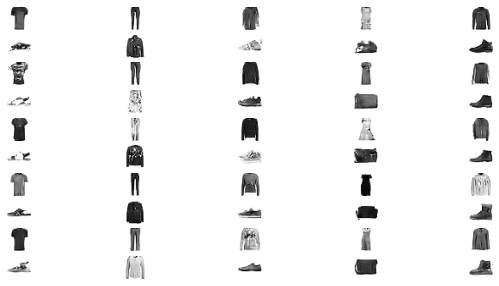

Epoch: 41 Batch 0 Loss fake: 0.400 Real: 0.419 GAN: 2.605 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.030
Epoch: 41 Batch 1 Loss fake: 0.176 Real: 0.489 GAN: 2.314 	 Accuracy fake: 0.969 Real: 0.750 GAN: 0.060
Epoch: 41 Batch 2 Loss fake: 0.301 Real: 0.215 GAN: 2.196 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.090
Epoch: 41 Batch 3 Loss fake: 0.389 Real: 0.256 GAN: 2.298 	 Accuracy fake: 0.891 Real: 0.922 GAN: 0.070
Epoch: 41 Batch 4 Loss fake: 0.256 Real: 0.332 GAN: 1.845 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.160
Epoch: 41 Batch 5 Loss fake: 0.252 Real: 0.186 GAN: 2.403 	 Accuracy fake: 0.938 Real: 0.906 GAN: 0.070
Epoch: 41 Batch 6 Loss fake: 0.296 Real: 0.533 GAN: 2.401 	 Accuracy fake: 0.891 Real: 0.719 GAN: 0.090
Epoch: 41 Batch 7 Loss fake: 0.272 Real: 0.329 GAN: 2.098 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.120
Epoch: 41 Batch 8 Loss fake: 0.295 Real: 0.224 GAN: 2.246 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.130
Epoch: 41 Batch 9 Loss fake: 0.335 Real: 0.269 GAN: 2.288 	 Accu

Epoch: 41 Batch 79 Loss fake: 0.293 Real: 0.282 GAN: 2.197 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.150
Epoch: 41 Batch 80 Loss fake: 0.260 Real: 0.215 GAN: 2.361 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.110
Epoch: 41 Batch 81 Loss fake: 0.310 Real: 0.327 GAN: 2.104 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.130
Epoch: 41 Batch 82 Loss fake: 0.288 Real: 0.289 GAN: 2.219 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.090
Epoch: 41 Batch 83 Loss fake: 0.328 Real: 0.397 GAN: 2.515 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.070
Epoch: 41 Batch 84 Loss fake: 0.217 Real: 0.425 GAN: 2.099 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.150
Epoch: 41 Batch 85 Loss fake: 0.204 Real: 0.218 GAN: 2.139 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.100
Epoch: 41 Batch 86 Loss fake: 0.353 Real: 0.260 GAN: 2.467 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.080
Epoch: 41 Batch 87 Loss fake: 0.375 Real: 0.376 GAN: 2.427 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.050
Epoch: 41 Batch 88 Loss fake: 0.299 Real: 0.396 GAN: 2.

Epoch: 41 Batch 157 Loss fake: 0.354 Real: 0.366 GAN: 2.387 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.080
Epoch: 41 Batch 158 Loss fake: 0.197 Real: 0.362 GAN: 2.149 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.120
Epoch: 41 Batch 159 Loss fake: 0.300 Real: 0.380 GAN: 2.047 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.110
Epoch: 41 Batch 160 Loss fake: 0.367 Real: 0.270 GAN: 2.558 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.060
Epoch: 41 Batch 161 Loss fake: 0.321 Real: 0.397 GAN: 2.419 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.090
Epoch: 41 Batch 162 Loss fake: 0.269 Real: 0.465 GAN: 2.209 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.110
Epoch: 41 Batch 163 Loss fake: 0.341 Real: 0.328 GAN: 2.451 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.100
Epoch: 41 Batch 164 Loss fake: 0.334 Real: 0.393 GAN: 2.123 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.160
Epoch: 41 Batch 165 Loss fake: 0.368 Real: 0.260 GAN: 2.543 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.090
Epoch: 41 Batch 166 Loss fake: 0.180 Real: 0.3

Epoch: 41 Batch 235 Loss fake: 0.294 Real: 0.362 GAN: 2.581 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.120
Epoch: 41 Batch 236 Loss fake: 0.290 Real: 0.299 GAN: 2.144 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.120
Epoch: 41 Batch 237 Loss fake: 0.340 Real: 0.279 GAN: 2.432 	 Accuracy fake: 0.875 Real: 0.891 GAN: 0.120
Epoch: 41 Batch 238 Loss fake: 0.294 Real: 0.390 GAN: 2.536 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.090
Epoch: 41 Batch 239 Loss fake: 0.253 Real: 0.445 GAN: 2.509 	 Accuracy fake: 0.875 Real: 0.750 GAN: 0.080
Epoch: 41 Batch 240 Loss fake: 0.269 Real: 0.325 GAN: 2.076 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.140
Epoch: 41 Batch 241 Loss fake: 0.332 Real: 0.207 GAN: 2.404 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.050
Epoch: 41 Batch 242 Loss fake: 0.260 Real: 0.578 GAN: 2.144 	 Accuracy fake: 0.922 Real: 0.750 GAN: 0.160
Epoch: 41 Batch 243 Loss fake: 0.311 Real: 0.381 GAN: 1.848 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.180
Epoch: 41 Batch 244 Loss fake: 0.252 Real: 0.2

Epoch: 41 Batch 313 Loss fake: 0.251 Real: 0.545 GAN: 2.249 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.110
Epoch: 41 Batch 314 Loss fake: 0.339 Real: 0.407 GAN: 2.075 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.110
Epoch: 41 Batch 315 Loss fake: 0.293 Real: 0.329 GAN: 1.876 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.200
Epoch: 41 Batch 316 Loss fake: 0.349 Real: 0.236 GAN: 2.576 	 Accuracy fake: 0.844 Real: 0.906 GAN: 0.070
Epoch: 41 Batch 317 Loss fake: 0.287 Real: 0.447 GAN: 2.236 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.120
Epoch: 41 Batch 318 Loss fake: 0.320 Real: 0.429 GAN: 2.256 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.140
Epoch: 41 Batch 319 Loss fake: 0.252 Real: 0.342 GAN: 1.912 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.170
Epoch: 41 Batch 320 Loss fake: 0.276 Real: 0.283 GAN: 2.059 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.100
Epoch: 41 Batch 321 Loss fake: 0.355 Real: 0.328 GAN: 2.010 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.120
Epoch: 41 Batch 322 Loss fake: 0.327 Real: 0.4

Epoch: 41 Batch 391 Loss fake: 0.336 Real: 0.401 GAN: 2.248 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.150
Epoch: 41 Batch 392 Loss fake: 0.233 Real: 0.294 GAN: 2.037 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.130
Epoch: 41 Batch 393 Loss fake: 0.264 Real: 0.233 GAN: 2.176 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.120
Epoch: 41 Batch 394 Loss fake: 0.198 Real: 0.411 GAN: 2.256 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.150
Epoch: 41 Batch 395 Loss fake: 0.171 Real: 0.467 GAN: 1.763 	 Accuracy fake: 0.984 Real: 0.781 GAN: 0.190
Epoch: 41 Batch 396 Loss fake: 0.512 Real: 0.210 GAN: 2.011 	 Accuracy fake: 0.734 Real: 0.891 GAN: 0.130
Epoch: 41 Batch 397 Loss fake: 0.333 Real: 0.258 GAN: 2.739 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.010
Epoch: 41 Batch 398 Loss fake: 0.234 Real: 0.431 GAN: 2.437 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.090
Epoch: 41 Batch 399 Loss fake: 0.291 Real: 0.398 GAN: 2.166 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.150
Epoch: 41 Batch 400 Loss fake: 0.413 Real: 0.3

Epoch: 42 Batch 1 Loss fake: 0.376 Real: 0.360 GAN: 2.200 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.100
Epoch: 42 Batch 2 Loss fake: 0.318 Real: 0.450 GAN: 2.033 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.110
Epoch: 42 Batch 3 Loss fake: 0.272 Real: 0.380 GAN: 2.203 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.130
Epoch: 42 Batch 4 Loss fake: 0.271 Real: 0.377 GAN: 2.234 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.090
Epoch: 42 Batch 5 Loss fake: 0.425 Real: 0.371 GAN: 2.481 	 Accuracy fake: 0.781 Real: 0.797 GAN: 0.060
Epoch: 42 Batch 6 Loss fake: 0.247 Real: 0.459 GAN: 2.130 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.140
Epoch: 42 Batch 7 Loss fake: 0.376 Real: 0.225 GAN: 2.036 	 Accuracy fake: 0.828 Real: 0.891 GAN: 0.140
Epoch: 42 Batch 8 Loss fake: 0.303 Real: 0.254 GAN: 2.430 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.120
Epoch: 42 Batch 9 Loss fake: 0.315 Real: 0.333 GAN: 2.273 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.110
Epoch: 42 Batch 10 Loss fake: 0.233 Real: 0.422 GAN: 2.104 	 Acc

Epoch: 42 Batch 80 Loss fake: 0.367 Real: 0.406 GAN: 2.396 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.120
Epoch: 42 Batch 81 Loss fake: 0.277 Real: 0.224 GAN: 2.391 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.120
Epoch: 42 Batch 82 Loss fake: 0.384 Real: 0.287 GAN: 2.291 	 Accuracy fake: 0.781 Real: 0.844 GAN: 0.070
Epoch: 42 Batch 83 Loss fake: 0.263 Real: 0.397 GAN: 2.305 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.080
Epoch: 42 Batch 84 Loss fake: 0.249 Real: 0.289 GAN: 2.431 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.040
Epoch: 42 Batch 85 Loss fake: 0.234 Real: 0.432 GAN: 2.157 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.110
Epoch: 42 Batch 86 Loss fake: 0.401 Real: 0.369 GAN: 1.856 	 Accuracy fake: 0.797 Real: 0.828 GAN: 0.200
Epoch: 42 Batch 87 Loss fake: 0.356 Real: 0.296 GAN: 2.101 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.100
Epoch: 42 Batch 88 Loss fake: 0.313 Real: 0.389 GAN: 2.282 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.060
Epoch: 42 Batch 89 Loss fake: 0.359 Real: 0.377 GAN: 2.

Epoch: 42 Batch 158 Loss fake: 0.295 Real: 0.386 GAN: 2.225 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.080
Epoch: 42 Batch 159 Loss fake: 0.308 Real: 0.306 GAN: 2.304 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.080
Epoch: 42 Batch 160 Loss fake: 0.250 Real: 0.254 GAN: 2.516 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.110
Epoch: 42 Batch 161 Loss fake: 0.349 Real: 0.418 GAN: 2.243 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.140
Epoch: 42 Batch 162 Loss fake: 0.301 Real: 0.450 GAN: 2.083 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.100
Epoch: 42 Batch 163 Loss fake: 0.333 Real: 0.364 GAN: 2.192 	 Accuracy fake: 0.844 Real: 0.766 GAN: 0.090
Epoch: 42 Batch 164 Loss fake: 0.403 Real: 0.354 GAN: 2.281 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.120
Epoch: 42 Batch 165 Loss fake: 0.367 Real: 0.394 GAN: 2.228 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.090
Epoch: 42 Batch 166 Loss fake: 0.226 Real: 0.224 GAN: 2.274 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.090
Epoch: 42 Batch 167 Loss fake: 0.386 Real: 0.3

Epoch: 42 Batch 236 Loss fake: 0.338 Real: 0.304 GAN: 2.274 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.090
Epoch: 42 Batch 237 Loss fake: 0.229 Real: 0.294 GAN: 2.434 	 Accuracy fake: 0.922 Real: 0.875 GAN: 0.070
Epoch: 42 Batch 238 Loss fake: 0.265 Real: 0.434 GAN: 2.523 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.070
Epoch: 42 Batch 239 Loss fake: 0.266 Real: 0.353 GAN: 2.344 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.080
Epoch: 42 Batch 240 Loss fake: 0.334 Real: 0.296 GAN: 2.000 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.100
Epoch: 42 Batch 241 Loss fake: 0.286 Real: 0.489 GAN: 2.087 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.120
Epoch: 42 Batch 242 Loss fake: 0.384 Real: 0.372 GAN: 2.069 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.100
Epoch: 42 Batch 243 Loss fake: 0.343 Real: 0.423 GAN: 2.582 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.070
Epoch: 42 Batch 244 Loss fake: 0.274 Real: 0.350 GAN: 2.036 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.190
Epoch: 42 Batch 245 Loss fake: 0.287 Real: 0.1

Epoch: 42 Batch 314 Loss fake: 0.416 Real: 0.229 GAN: 2.428 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.070
Epoch: 42 Batch 315 Loss fake: 0.314 Real: 0.393 GAN: 2.331 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.080
Epoch: 42 Batch 316 Loss fake: 0.346 Real: 0.359 GAN: 2.466 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.090
Epoch: 42 Batch 317 Loss fake: 0.281 Real: 0.340 GAN: 2.269 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.090
Epoch: 42 Batch 318 Loss fake: 0.313 Real: 0.340 GAN: 2.248 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.100
Epoch: 42 Batch 319 Loss fake: 0.246 Real: 0.418 GAN: 2.180 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.110
Epoch: 42 Batch 320 Loss fake: 0.378 Real: 0.328 GAN: 2.033 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.150
Epoch: 42 Batch 321 Loss fake: 0.258 Real: 0.422 GAN: 2.307 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.080
Epoch: 42 Batch 322 Loss fake: 0.311 Real: 0.321 GAN: 1.816 	 Accuracy fake: 0.875 Real: 0.781 GAN: 0.130
Epoch: 42 Batch 323 Loss fake: 0.300 Real: 0.2

Epoch: 42 Batch 392 Loss fake: 0.372 Real: 0.334 GAN: 2.013 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.120
Epoch: 42 Batch 393 Loss fake: 0.452 Real: 0.365 GAN: 2.474 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.160
Epoch: 42 Batch 394 Loss fake: 0.360 Real: 0.375 GAN: 2.377 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.080
Epoch: 42 Batch 395 Loss fake: 0.265 Real: 0.357 GAN: 2.285 	 Accuracy fake: 0.922 Real: 0.781 GAN: 0.070
Epoch: 42 Batch 396 Loss fake: 0.323 Real: 0.307 GAN: 2.431 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.090
Epoch: 42 Batch 397 Loss fake: 0.271 Real: 0.310 GAN: 2.216 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.110
Epoch: 42 Batch 398 Loss fake: 0.264 Real: 0.370 GAN: 2.090 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.130
Epoch: 42 Batch 399 Loss fake: 0.295 Real: 0.324 GAN: 2.226 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.150
Epoch: 42 Batch 400 Loss fake: 0.263 Real: 0.236 GAN: 2.098 	 Accuracy fake: 0.938 Real: 0.891 GAN: 0.110
Epoch: 42 Batch 401 Loss fake: 0.382 Real: 0.4

Epoch: 43 Batch 2 Loss fake: 0.217 Real: 0.576 GAN: 1.879 	 Accuracy fake: 0.938 Real: 0.719 GAN: 0.180
Epoch: 43 Batch 3 Loss fake: 0.356 Real: 0.224 GAN: 2.048 	 Accuracy fake: 0.875 Real: 0.891 GAN: 0.120
Epoch: 43 Batch 4 Loss fake: 0.423 Real: 0.522 GAN: 2.039 	 Accuracy fake: 0.844 Real: 0.750 GAN: 0.140
Epoch: 43 Batch 5 Loss fake: 0.209 Real: 0.308 GAN: 1.922 	 Accuracy fake: 0.969 Real: 0.859 GAN: 0.110
Epoch: 43 Batch 6 Loss fake: 0.409 Real: 0.272 GAN: 2.200 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.080
Epoch: 43 Batch 7 Loss fake: 0.278 Real: 0.402 GAN: 2.051 	 Accuracy fake: 0.859 Real: 0.734 GAN: 0.090
Epoch: 43 Batch 8 Loss fake: 0.295 Real: 0.394 GAN: 1.922 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.210
Epoch: 43 Batch 9 Loss fake: 0.470 Real: 0.637 GAN: 2.421 	 Accuracy fake: 0.859 Real: 0.703 GAN: 0.080
Epoch: 43 Batch 10 Loss fake: 0.371 Real: 0.554 GAN: 2.106 	 Accuracy fake: 0.797 Real: 0.719 GAN: 0.130
Epoch: 43 Batch 11 Loss fake: 0.311 Real: 0.264 GAN: 1.957 	 Ac

Epoch: 43 Batch 81 Loss fake: 0.301 Real: 0.350 GAN: 2.047 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.140
Epoch: 43 Batch 82 Loss fake: 0.313 Real: 0.468 GAN: 2.183 	 Accuracy fake: 0.859 Real: 0.703 GAN: 0.160
Epoch: 43 Batch 83 Loss fake: 0.347 Real: 0.298 GAN: 2.459 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.100
Epoch: 43 Batch 84 Loss fake: 0.353 Real: 0.208 GAN: 2.625 	 Accuracy fake: 0.875 Real: 0.906 GAN: 0.100
Epoch: 43 Batch 85 Loss fake: 0.268 Real: 0.411 GAN: 2.277 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.080
Epoch: 43 Batch 86 Loss fake: 0.271 Real: 0.355 GAN: 2.203 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.100
Epoch: 43 Batch 87 Loss fake: 0.273 Real: 0.330 GAN: 1.963 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.110
Epoch: 43 Batch 88 Loss fake: 0.290 Real: 0.276 GAN: 2.095 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.090
Epoch: 43 Batch 89 Loss fake: 0.229 Real: 0.285 GAN: 1.943 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.170
Epoch: 43 Batch 90 Loss fake: 0.464 Real: 0.500 GAN: 2.

Epoch: 43 Batch 159 Loss fake: 0.234 Real: 0.521 GAN: 2.493 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.110
Epoch: 43 Batch 160 Loss fake: 0.276 Real: 0.428 GAN: 1.806 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.240
Epoch: 43 Batch 161 Loss fake: 0.304 Real: 0.424 GAN: 2.013 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.180
Epoch: 43 Batch 162 Loss fake: 0.292 Real: 0.322 GAN: 2.145 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.140
Epoch: 43 Batch 163 Loss fake: 0.377 Real: 0.373 GAN: 2.501 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.100
Epoch: 43 Batch 164 Loss fake: 0.228 Real: 0.315 GAN: 2.224 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.130
Epoch: 43 Batch 165 Loss fake: 0.351 Real: 0.427 GAN: 2.198 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.090
Epoch: 43 Batch 166 Loss fake: 0.201 Real: 0.227 GAN: 2.275 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.030
Epoch: 43 Batch 167 Loss fake: 0.383 Real: 0.313 GAN: 2.300 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.110
Epoch: 43 Batch 168 Loss fake: 0.253 Real: 0.4

Epoch: 43 Batch 237 Loss fake: 0.426 Real: 0.139 GAN: 2.851 	 Accuracy fake: 0.828 Real: 0.953 GAN: 0.080
Epoch: 43 Batch 238 Loss fake: 0.251 Real: 0.590 GAN: 2.558 	 Accuracy fake: 0.906 Real: 0.703 GAN: 0.070
Epoch: 43 Batch 239 Loss fake: 0.245 Real: 0.290 GAN: 2.080 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.120
Epoch: 43 Batch 240 Loss fake: 0.266 Real: 0.373 GAN: 2.042 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.160
Epoch: 43 Batch 241 Loss fake: 0.310 Real: 0.309 GAN: 2.345 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.120
Epoch: 43 Batch 242 Loss fake: 0.276 Real: 0.360 GAN: 1.943 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.170
Epoch: 43 Batch 243 Loss fake: 0.373 Real: 0.320 GAN: 2.086 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.140
Epoch: 43 Batch 244 Loss fake: 0.278 Real: 0.257 GAN: 2.473 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.110
Epoch: 43 Batch 245 Loss fake: 0.310 Real: 0.389 GAN: 2.457 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.090
Epoch: 43 Batch 246 Loss fake: 0.220 Real: 0.3

Epoch: 43 Batch 315 Loss fake: 0.300 Real: 0.423 GAN: 2.081 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.130
Epoch: 43 Batch 316 Loss fake: 0.192 Real: 0.275 GAN: 1.942 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.180
Epoch: 43 Batch 317 Loss fake: 0.316 Real: 0.314 GAN: 2.216 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.120
Epoch: 43 Batch 318 Loss fake: 0.293 Real: 0.264 GAN: 2.527 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.060
Epoch: 43 Batch 319 Loss fake: 0.215 Real: 0.286 GAN: 2.170 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.050
Epoch: 43 Batch 320 Loss fake: 0.258 Real: 0.287 GAN: 2.176 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.120
Epoch: 43 Batch 321 Loss fake: 0.264 Real: 0.477 GAN: 2.593 	 Accuracy fake: 0.922 Real: 0.719 GAN: 0.070
Epoch: 43 Batch 322 Loss fake: 0.349 Real: 0.212 GAN: 2.393 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.060
Epoch: 43 Batch 323 Loss fake: 0.231 Real: 0.591 GAN: 2.021 	 Accuracy fake: 0.938 Real: 0.703 GAN: 0.120
Epoch: 43 Batch 324 Loss fake: 0.279 Real: 0.2

Epoch: 43 Batch 393 Loss fake: 0.237 Real: 0.277 GAN: 2.422 	 Accuracy fake: 0.938 Real: 0.891 GAN: 0.070
Epoch: 43 Batch 394 Loss fake: 0.160 Real: 0.298 GAN: 2.292 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.080
Epoch: 43 Batch 395 Loss fake: 0.226 Real: 0.230 GAN: 2.312 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.080
Epoch: 43 Batch 396 Loss fake: 0.220 Real: 0.282 GAN: 1.992 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.150
Epoch: 43 Batch 397 Loss fake: 0.296 Real: 0.352 GAN: 2.348 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.110
Epoch: 43 Batch 398 Loss fake: 0.345 Real: 0.394 GAN: 2.187 	 Accuracy fake: 0.844 Real: 0.797 GAN: 0.110
Epoch: 43 Batch 399 Loss fake: 0.237 Real: 0.428 GAN: 2.025 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.080
Epoch: 43 Batch 400 Loss fake: 0.410 Real: 0.289 GAN: 2.232 	 Accuracy fake: 0.797 Real: 0.859 GAN: 0.060
Epoch: 43 Batch 401 Loss fake: 0.375 Real: 0.303 GAN: 2.598 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.090
Epoch: 43 Batch 402 Loss fake: 0.249 Real: 0.4

Epoch: 44 Batch 3 Loss fake: 0.268 Real: 0.352 GAN: 2.043 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.120
Epoch: 44 Batch 4 Loss fake: 0.467 Real: 0.255 GAN: 2.365 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.080
Epoch: 44 Batch 5 Loss fake: 0.391 Real: 0.454 GAN: 2.424 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.090
Epoch: 44 Batch 6 Loss fake: 0.234 Real: 0.313 GAN: 2.298 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.110
Epoch: 44 Batch 7 Loss fake: 0.219 Real: 0.399 GAN: 2.216 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.090
Epoch: 44 Batch 8 Loss fake: 0.230 Real: 0.409 GAN: 1.977 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.180
Epoch: 44 Batch 9 Loss fake: 0.316 Real: 0.243 GAN: 1.983 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.140
Epoch: 44 Batch 10 Loss fake: 0.295 Real: 0.406 GAN: 2.279 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.060
Epoch: 44 Batch 11 Loss fake: 0.386 Real: 0.455 GAN: 2.320 	 Accuracy fake: 0.812 Real: 0.703 GAN: 0.130
Epoch: 44 Batch 12 Loss fake: 0.363 Real: 0.391 GAN: 2.025 	 A

Epoch: 44 Batch 82 Loss fake: 0.334 Real: 0.295 GAN: 2.595 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.050
Epoch: 44 Batch 83 Loss fake: 0.274 Real: 0.336 GAN: 2.477 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.070
Epoch: 44 Batch 84 Loss fake: 0.290 Real: 0.426 GAN: 2.275 	 Accuracy fake: 0.891 Real: 0.766 GAN: 0.120
Epoch: 44 Batch 85 Loss fake: 0.239 Real: 0.560 GAN: 2.006 	 Accuracy fake: 0.922 Real: 0.734 GAN: 0.150
Epoch: 44 Batch 86 Loss fake: 0.403 Real: 0.296 GAN: 2.317 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.100
Epoch: 44 Batch 87 Loss fake: 0.274 Real: 0.434 GAN: 1.822 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.160
Epoch: 44 Batch 88 Loss fake: 0.360 Real: 0.298 GAN: 1.996 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.140
Epoch: 44 Batch 89 Loss fake: 0.406 Real: 0.197 GAN: 2.205 	 Accuracy fake: 0.781 Real: 0.922 GAN: 0.130
Epoch: 44 Batch 90 Loss fake: 0.378 Real: 0.429 GAN: 2.797 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.100
Epoch: 44 Batch 91 Loss fake: 0.195 Real: 0.437 GAN: 2.

Epoch: 44 Batch 160 Loss fake: 0.232 Real: 0.426 GAN: 2.302 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.130
Epoch: 44 Batch 161 Loss fake: 0.308 Real: 0.348 GAN: 2.102 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.140
Epoch: 44 Batch 162 Loss fake: 0.314 Real: 0.508 GAN: 2.020 	 Accuracy fake: 0.828 Real: 0.781 GAN: 0.100
Epoch: 44 Batch 163 Loss fake: 0.454 Real: 0.313 GAN: 2.347 	 Accuracy fake: 0.766 Real: 0.844 GAN: 0.080
Epoch: 44 Batch 164 Loss fake: 0.229 Real: 0.343 GAN: 2.238 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.090
Epoch: 44 Batch 165 Loss fake: 0.258 Real: 0.343 GAN: 2.150 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.120
Epoch: 44 Batch 166 Loss fake: 0.328 Real: 0.383 GAN: 2.149 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.090
Epoch: 44 Batch 167 Loss fake: 0.254 Real: 0.333 GAN: 2.379 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.100
Epoch: 44 Batch 168 Loss fake: 0.201 Real: 0.394 GAN: 2.192 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.150
Epoch: 44 Batch 169 Loss fake: 0.291 Real: 0.3

Epoch: 44 Batch 238 Loss fake: 0.192 Real: 0.384 GAN: 2.211 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.080
Epoch: 44 Batch 239 Loss fake: 0.288 Real: 0.307 GAN: 2.190 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.100
Epoch: 44 Batch 240 Loss fake: 0.280 Real: 0.267 GAN: 2.421 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.110
Epoch: 44 Batch 241 Loss fake: 0.325 Real: 0.376 GAN: 2.704 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.050
Epoch: 44 Batch 242 Loss fake: 0.263 Real: 0.369 GAN: 2.170 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.080
Epoch: 44 Batch 243 Loss fake: 0.184 Real: 0.338 GAN: 1.897 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.180
Epoch: 44 Batch 244 Loss fake: 0.401 Real: 0.275 GAN: 2.333 	 Accuracy fake: 0.828 Real: 0.875 GAN: 0.090
Epoch: 44 Batch 245 Loss fake: 0.220 Real: 0.319 GAN: 2.053 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.070
Epoch: 44 Batch 246 Loss fake: 0.321 Real: 0.387 GAN: 2.027 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.150
Epoch: 44 Batch 247 Loss fake: 0.301 Real: 0.3

Epoch: 44 Batch 316 Loss fake: 0.347 Real: 0.366 GAN: 2.088 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.100
Epoch: 44 Batch 317 Loss fake: 0.437 Real: 0.228 GAN: 2.327 	 Accuracy fake: 0.828 Real: 0.906 GAN: 0.070
Epoch: 44 Batch 318 Loss fake: 0.315 Real: 0.362 GAN: 2.115 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.160
Epoch: 44 Batch 319 Loss fake: 0.213 Real: 0.356 GAN: 2.358 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.110
Epoch: 44 Batch 320 Loss fake: 0.379 Real: 0.291 GAN: 2.278 	 Accuracy fake: 0.812 Real: 0.812 GAN: 0.120
Epoch: 44 Batch 321 Loss fake: 0.278 Real: 0.341 GAN: 2.123 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.140
Epoch: 44 Batch 322 Loss fake: 0.311 Real: 0.354 GAN: 2.036 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.170
Epoch: 44 Batch 323 Loss fake: 0.235 Real: 0.327 GAN: 2.083 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.180
Epoch: 44 Batch 324 Loss fake: 0.251 Real: 0.228 GAN: 2.369 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.100
Epoch: 44 Batch 325 Loss fake: 0.204 Real: 0.2

Epoch: 44 Batch 394 Loss fake: 0.305 Real: 0.434 GAN: 1.906 	 Accuracy fake: 0.891 Real: 0.750 GAN: 0.220
Epoch: 44 Batch 395 Loss fake: 0.447 Real: 0.342 GAN: 2.281 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.120
Epoch: 44 Batch 396 Loss fake: 0.227 Real: 0.428 GAN: 1.991 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.150
Epoch: 44 Batch 397 Loss fake: 0.334 Real: 0.507 GAN: 1.641 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.190
Epoch: 44 Batch 398 Loss fake: 0.657 Real: 0.196 GAN: 2.088 	 Accuracy fake: 0.688 Real: 0.938 GAN: 0.150
Epoch: 44 Batch 399 Loss fake: 0.305 Real: 0.417 GAN: 2.371 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 44 Batch 400 Loss fake: 0.253 Real: 0.444 GAN: 2.260 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.120
Epoch: 44 Batch 401 Loss fake: 0.385 Real: 0.244 GAN: 2.543 	 Accuracy fake: 0.812 Real: 0.906 GAN: 0.120
Epoch: 44 Batch 402 Loss fake: 0.228 Real: 0.473 GAN: 2.528 	 Accuracy fake: 0.922 Real: 0.703 GAN: 0.080
Epoch: 44 Batch 403 Loss fake: 0.386 Real: 0.5

Epoch: 45 Batch 4 Loss fake: 0.384 Real: 0.299 GAN: 2.224 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.090
Epoch: 45 Batch 5 Loss fake: 0.296 Real: 0.251 GAN: 2.296 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.070
Epoch: 45 Batch 6 Loss fake: 0.260 Real: 0.366 GAN: 2.352 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.050
Epoch: 45 Batch 7 Loss fake: 0.324 Real: 0.371 GAN: 2.409 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.090
Epoch: 45 Batch 8 Loss fake: 0.234 Real: 0.297 GAN: 2.095 	 Accuracy fake: 0.922 Real: 0.906 GAN: 0.200
Epoch: 45 Batch 9 Loss fake: 0.379 Real: 0.349 GAN: 2.368 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.030
Epoch: 45 Batch 10 Loss fake: 0.261 Real: 0.223 GAN: 2.342 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.040
Epoch: 45 Batch 11 Loss fake: 0.305 Real: 0.504 GAN: 2.038 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.120
Epoch: 45 Batch 12 Loss fake: 0.294 Real: 0.344 GAN: 2.176 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.120
Epoch: 45 Batch 13 Loss fake: 0.381 Real: 0.281 GAN: 1.951 	 

Epoch: 45 Batch 83 Loss fake: 0.320 Real: 0.498 GAN: 2.169 	 Accuracy fake: 0.875 Real: 0.672 GAN: 0.120
Epoch: 45 Batch 84 Loss fake: 0.264 Real: 0.164 GAN: 1.736 	 Accuracy fake: 0.938 Real: 0.938 GAN: 0.230
Epoch: 45 Batch 85 Loss fake: 0.435 Real: 0.331 GAN: 2.174 	 Accuracy fake: 0.781 Real: 0.844 GAN: 0.120
Epoch: 45 Batch 86 Loss fake: 0.341 Real: 0.357 GAN: 2.516 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.080
Epoch: 45 Batch 87 Loss fake: 0.306 Real: 0.332 GAN: 2.203 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.160
Epoch: 45 Batch 88 Loss fake: 0.217 Real: 0.338 GAN: 2.184 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.090
Epoch: 45 Batch 89 Loss fake: 0.234 Real: 0.276 GAN: 2.074 	 Accuracy fake: 0.984 Real: 0.906 GAN: 0.130
Epoch: 45 Batch 90 Loss fake: 0.310 Real: 0.368 GAN: 2.116 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.100
Epoch: 45 Batch 91 Loss fake: 0.364 Real: 0.389 GAN: 2.200 	 Accuracy fake: 0.859 Real: 0.812 GAN: 0.150
Epoch: 45 Batch 92 Loss fake: 0.243 Real: 0.312 GAN: 2.

Epoch: 45 Batch 161 Loss fake: 0.385 Real: 0.361 GAN: 2.402 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.090
Epoch: 45 Batch 162 Loss fake: 0.271 Real: 0.387 GAN: 2.074 	 Accuracy fake: 0.953 Real: 0.828 GAN: 0.050
Epoch: 45 Batch 163 Loss fake: 0.227 Real: 0.346 GAN: 1.907 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.120
Epoch: 45 Batch 164 Loss fake: 0.329 Real: 0.322 GAN: 2.230 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.100
Epoch: 45 Batch 165 Loss fake: 0.275 Real: 0.326 GAN: 2.246 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.140
Epoch: 45 Batch 166 Loss fake: 0.222 Real: 0.425 GAN: 1.918 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.120
Epoch: 45 Batch 167 Loss fake: 0.339 Real: 0.266 GAN: 2.056 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.120
Epoch: 45 Batch 168 Loss fake: 0.265 Real: 0.264 GAN: 2.354 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.090
Epoch: 45 Batch 169 Loss fake: 0.338 Real: 0.221 GAN: 2.397 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.090
Epoch: 45 Batch 170 Loss fake: 0.224 Real: 0.5

Epoch: 45 Batch 239 Loss fake: 0.250 Real: 0.318 GAN: 1.923 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.160
Epoch: 45 Batch 240 Loss fake: 0.312 Real: 0.291 GAN: 2.462 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.110
Epoch: 45 Batch 241 Loss fake: 0.220 Real: 0.381 GAN: 2.097 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.160
Epoch: 45 Batch 242 Loss fake: 0.220 Real: 0.325 GAN: 2.367 	 Accuracy fake: 0.953 Real: 0.844 GAN: 0.070
Epoch: 45 Batch 243 Loss fake: 0.230 Real: 0.378 GAN: 2.178 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.180
Epoch: 45 Batch 244 Loss fake: 0.290 Real: 0.287 GAN: 2.013 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.130
Epoch: 45 Batch 245 Loss fake: 0.306 Real: 0.325 GAN: 2.106 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.170
Epoch: 45 Batch 246 Loss fake: 0.314 Real: 0.223 GAN: 2.639 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.070
Epoch: 45 Batch 247 Loss fake: 0.328 Real: 0.418 GAN: 2.269 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.110
Epoch: 45 Batch 248 Loss fake: 0.243 Real: 0.2

Epoch: 45 Batch 317 Loss fake: 0.282 Real: 0.438 GAN: 2.167 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.150
Epoch: 45 Batch 318 Loss fake: 0.253 Real: 0.348 GAN: 2.070 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.140
Epoch: 45 Batch 319 Loss fake: 0.393 Real: 0.333 GAN: 2.187 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.150
Epoch: 45 Batch 320 Loss fake: 0.246 Real: 0.245 GAN: 2.227 	 Accuracy fake: 0.953 Real: 0.891 GAN: 0.120
Epoch: 45 Batch 321 Loss fake: 0.311 Real: 0.347 GAN: 2.227 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.090
Epoch: 45 Batch 322 Loss fake: 0.363 Real: 0.260 GAN: 2.316 	 Accuracy fake: 0.828 Real: 0.906 GAN: 0.110
Epoch: 45 Batch 323 Loss fake: 0.260 Real: 0.346 GAN: 2.561 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.090
Epoch: 45 Batch 324 Loss fake: 0.285 Real: 0.308 GAN: 2.463 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.050
Epoch: 45 Batch 325 Loss fake: 0.230 Real: 0.415 GAN: 2.200 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.130
Epoch: 45 Batch 326 Loss fake: 0.300 Real: 0.2

Epoch: 45 Batch 395 Loss fake: 0.246 Real: 0.259 GAN: 2.312 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.090
Epoch: 45 Batch 396 Loss fake: 0.359 Real: 0.231 GAN: 2.537 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.100
Epoch: 45 Batch 397 Loss fake: 0.275 Real: 0.282 GAN: 2.616 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.020
Epoch: 45 Batch 398 Loss fake: 0.216 Real: 0.428 GAN: 2.290 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.110
Epoch: 45 Batch 399 Loss fake: 0.310 Real: 0.255 GAN: 2.168 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.100
Epoch: 45 Batch 400 Loss fake: 0.379 Real: 0.383 GAN: 2.733 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.080
Epoch: 45 Batch 401 Loss fake: 0.286 Real: 0.371 GAN: 2.161 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.170
Epoch: 45 Batch 402 Loss fake: 0.224 Real: 0.329 GAN: 2.158 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.120
Epoch: 45 Batch 403 Loss fake: 0.342 Real: 0.360 GAN: 2.151 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.160
Epoch: 45 Batch 404 Loss fake: 0.311 Real: 0.3

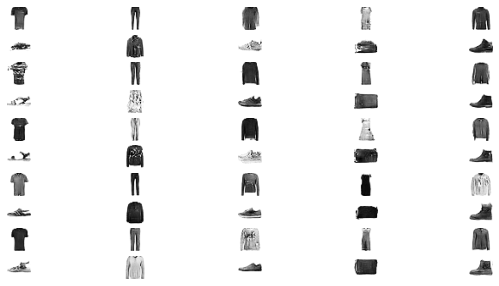

Epoch: 46 Batch 0 Loss fake: 0.284 Real: 0.373 GAN: 2.067 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.150
Epoch: 46 Batch 1 Loss fake: 0.249 Real: 0.342 GAN: 2.441 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.080
Epoch: 46 Batch 2 Loss fake: 0.301 Real: 0.484 GAN: 2.139 	 Accuracy fake: 0.891 Real: 0.688 GAN: 0.090
Epoch: 46 Batch 3 Loss fake: 0.291 Real: 0.248 GAN: 2.199 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.120
Epoch: 46 Batch 4 Loss fake: 0.366 Real: 0.253 GAN: 2.177 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.130
Epoch: 46 Batch 5 Loss fake: 0.222 Real: 0.315 GAN: 2.350 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.070
Epoch: 46 Batch 6 Loss fake: 0.290 Real: 0.558 GAN: 2.372 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.120
Epoch: 46 Batch 7 Loss fake: 0.285 Real: 0.312 GAN: 2.104 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.160
Epoch: 46 Batch 8 Loss fake: 0.265 Real: 0.306 GAN: 2.104 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.140
Epoch: 46 Batch 9 Loss fake: 0.346 Real: 0.260 GAN: 2.342 	 Accu

Epoch: 46 Batch 79 Loss fake: 0.357 Real: 0.380 GAN: 2.523 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.110
Epoch: 46 Batch 80 Loss fake: 0.322 Real: 0.300 GAN: 2.408 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.060
Epoch: 46 Batch 81 Loss fake: 0.234 Real: 0.347 GAN: 2.244 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.100
Epoch: 46 Batch 82 Loss fake: 0.315 Real: 0.396 GAN: 2.424 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.110
Epoch: 46 Batch 83 Loss fake: 0.194 Real: 0.340 GAN: 2.044 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.140
Epoch: 46 Batch 84 Loss fake: 0.218 Real: 0.158 GAN: 2.103 	 Accuracy fake: 0.969 Real: 0.938 GAN: 0.120
Epoch: 46 Batch 85 Loss fake: 0.416 Real: 0.499 GAN: 2.303 	 Accuracy fake: 0.797 Real: 0.719 GAN: 0.100
Epoch: 46 Batch 86 Loss fake: 0.270 Real: 0.295 GAN: 2.154 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.130
Epoch: 46 Batch 87 Loss fake: 0.284 Real: 0.293 GAN: 2.041 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.100
Epoch: 46 Batch 88 Loss fake: 0.359 Real: 0.236 GAN: 2.

Epoch: 46 Batch 157 Loss fake: 0.252 Real: 0.223 GAN: 2.043 	 Accuracy fake: 0.938 Real: 0.906 GAN: 0.190
Epoch: 46 Batch 158 Loss fake: 0.371 Real: 0.304 GAN: 2.393 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.100
Epoch: 46 Batch 159 Loss fake: 0.273 Real: 0.454 GAN: 2.326 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.060
Epoch: 46 Batch 160 Loss fake: 0.231 Real: 0.271 GAN: 2.446 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.120
Epoch: 46 Batch 161 Loss fake: 0.342 Real: 0.302 GAN: 2.043 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.120
Epoch: 46 Batch 162 Loss fake: 0.357 Real: 0.322 GAN: 2.320 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.080
Epoch: 46 Batch 163 Loss fake: 0.314 Real: 0.496 GAN: 2.276 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.120
Epoch: 46 Batch 164 Loss fake: 0.268 Real: 0.291 GAN: 2.312 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.070
Epoch: 46 Batch 165 Loss fake: 0.295 Real: 0.289 GAN: 2.230 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.110
Epoch: 46 Batch 166 Loss fake: 0.249 Real: 0.3

Epoch: 46 Batch 235 Loss fake: 0.185 Real: 0.391 GAN: 2.492 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.070
Epoch: 46 Batch 236 Loss fake: 0.250 Real: 0.332 GAN: 2.280 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.110
Epoch: 46 Batch 237 Loss fake: 0.367 Real: 0.201 GAN: 2.600 	 Accuracy fake: 0.844 Real: 0.938 GAN: 0.070
Epoch: 46 Batch 238 Loss fake: 0.238 Real: 0.357 GAN: 2.361 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.100
Epoch: 46 Batch 239 Loss fake: 0.290 Real: 0.308 GAN: 2.285 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.110
Epoch: 46 Batch 240 Loss fake: 0.267 Real: 0.472 GAN: 2.274 	 Accuracy fake: 0.891 Real: 0.734 GAN: 0.090
Epoch: 46 Batch 241 Loss fake: 0.309 Real: 0.332 GAN: 2.177 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.110
Epoch: 46 Batch 242 Loss fake: 0.386 Real: 0.353 GAN: 2.447 	 Accuracy fake: 0.844 Real: 0.828 GAN: 0.060
Epoch: 46 Batch 243 Loss fake: 0.178 Real: 0.335 GAN: 2.337 	 Accuracy fake: 0.969 Real: 0.859 GAN: 0.130
Epoch: 46 Batch 244 Loss fake: 0.323 Real: 0.3

Epoch: 46 Batch 313 Loss fake: 0.303 Real: 0.466 GAN: 2.220 	 Accuracy fake: 0.859 Real: 0.766 GAN: 0.060
Epoch: 46 Batch 314 Loss fake: 0.286 Real: 0.325 GAN: 2.188 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.100
Epoch: 46 Batch 315 Loss fake: 0.482 Real: 0.467 GAN: 2.157 	 Accuracy fake: 0.812 Real: 0.734 GAN: 0.070
Epoch: 46 Batch 316 Loss fake: 0.295 Real: 0.272 GAN: 2.045 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.130
Epoch: 46 Batch 317 Loss fake: 0.191 Real: 0.317 GAN: 1.936 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.140
Epoch: 46 Batch 318 Loss fake: 0.350 Real: 0.310 GAN: 1.903 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.130
Epoch: 46 Batch 319 Loss fake: 0.323 Real: 0.323 GAN: 2.161 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.090
Epoch: 46 Batch 320 Loss fake: 0.240 Real: 0.302 GAN: 2.047 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.130
Epoch: 46 Batch 321 Loss fake: 0.302 Real: 0.325 GAN: 2.203 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.100
Epoch: 46 Batch 322 Loss fake: 0.351 Real: 0.3

Epoch: 46 Batch 391 Loss fake: 0.371 Real: 0.327 GAN: 2.166 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.130
Epoch: 46 Batch 392 Loss fake: 0.304 Real: 0.305 GAN: 2.227 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.060
Epoch: 46 Batch 393 Loss fake: 0.241 Real: 0.398 GAN: 2.105 	 Accuracy fake: 0.922 Real: 0.766 GAN: 0.090
Epoch: 46 Batch 394 Loss fake: 0.209 Real: 0.444 GAN: 1.853 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.180
Epoch: 46 Batch 395 Loss fake: 0.556 Real: 0.335 GAN: 2.170 	 Accuracy fake: 0.719 Real: 0.797 GAN: 0.080
Epoch: 46 Batch 396 Loss fake: 0.307 Real: 0.369 GAN: 2.561 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.080
Epoch: 46 Batch 397 Loss fake: 0.253 Real: 0.328 GAN: 2.268 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.160
Epoch: 46 Batch 398 Loss fake: 0.350 Real: 0.421 GAN: 2.040 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.130
Epoch: 46 Batch 399 Loss fake: 0.240 Real: 0.286 GAN: 2.360 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.120
Epoch: 46 Batch 400 Loss fake: 0.314 Real: 0.3

Epoch: 47 Batch 1 Loss fake: 0.221 Real: 0.327 GAN: 2.230 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.090
Epoch: 47 Batch 2 Loss fake: 0.274 Real: 0.355 GAN: 2.303 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.090
Epoch: 47 Batch 3 Loss fake: 0.263 Real: 0.324 GAN: 2.176 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.080
Epoch: 47 Batch 4 Loss fake: 0.256 Real: 0.271 GAN: 2.377 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.080
Epoch: 47 Batch 5 Loss fake: 0.381 Real: 0.386 GAN: 2.515 	 Accuracy fake: 0.812 Real: 0.797 GAN: 0.040
Epoch: 47 Batch 6 Loss fake: 0.254 Real: 0.436 GAN: 2.198 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.090
Epoch: 47 Batch 7 Loss fake: 0.303 Real: 0.297 GAN: 2.337 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.080
Epoch: 47 Batch 8 Loss fake: 0.303 Real: 0.383 GAN: 2.460 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.080
Epoch: 47 Batch 9 Loss fake: 0.322 Real: 0.387 GAN: 2.177 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.180
Epoch: 47 Batch 10 Loss fake: 0.221 Real: 0.426 GAN: 1.936 	 Acc

Epoch: 47 Batch 80 Loss fake: 0.390 Real: 0.719 GAN: 2.008 	 Accuracy fake: 0.859 Real: 0.641 GAN: 0.130
Epoch: 47 Batch 81 Loss fake: 0.294 Real: 0.329 GAN: 2.116 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.070
Epoch: 47 Batch 82 Loss fake: 0.374 Real: 0.362 GAN: 2.036 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.190
Epoch: 47 Batch 83 Loss fake: 0.281 Real: 0.313 GAN: 2.213 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.120
Epoch: 47 Batch 84 Loss fake: 0.239 Real: 0.395 GAN: 2.062 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.130
Epoch: 47 Batch 85 Loss fake: 0.272 Real: 0.212 GAN: 1.863 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.240
Epoch: 47 Batch 86 Loss fake: 0.450 Real: 0.287 GAN: 2.702 	 Accuracy fake: 0.797 Real: 0.891 GAN: 0.070
Epoch: 47 Batch 87 Loss fake: 0.234 Real: 0.378 GAN: 2.571 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.080
Epoch: 47 Batch 88 Loss fake: 0.277 Real: 0.270 GAN: 2.404 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.130
Epoch: 47 Batch 89 Loss fake: 0.320 Real: 0.427 GAN: 2.

Epoch: 47 Batch 158 Loss fake: 0.261 Real: 0.400 GAN: 2.479 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.090
Epoch: 47 Batch 159 Loss fake: 0.250 Real: 0.376 GAN: 2.443 	 Accuracy fake: 0.906 Real: 0.719 GAN: 0.080
Epoch: 47 Batch 160 Loss fake: 0.265 Real: 0.215 GAN: 2.411 	 Accuracy fake: 0.891 Real: 0.891 GAN: 0.170
Epoch: 47 Batch 161 Loss fake: 0.311 Real: 0.320 GAN: 2.351 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.120
Epoch: 47 Batch 162 Loss fake: 0.263 Real: 0.348 GAN: 1.848 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.140
Epoch: 47 Batch 163 Loss fake: 0.300 Real: 0.246 GAN: 2.189 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.070
Epoch: 47 Batch 164 Loss fake: 0.299 Real: 0.373 GAN: 2.310 	 Accuracy fake: 0.906 Real: 0.781 GAN: 0.070
Epoch: 47 Batch 165 Loss fake: 0.314 Real: 0.354 GAN: 2.376 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.100
Epoch: 47 Batch 166 Loss fake: 0.224 Real: 0.181 GAN: 2.454 	 Accuracy fake: 0.969 Real: 0.891 GAN: 0.100
Epoch: 47 Batch 167 Loss fake: 0.193 Real: 0.2

Epoch: 47 Batch 236 Loss fake: 0.258 Real: 0.336 GAN: 2.265 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.070
Epoch: 47 Batch 237 Loss fake: 0.381 Real: 0.275 GAN: 2.270 	 Accuracy fake: 0.844 Real: 0.812 GAN: 0.150
Epoch: 47 Batch 238 Loss fake: 0.179 Real: 0.425 GAN: 2.189 	 Accuracy fake: 0.953 Real: 0.766 GAN: 0.160
Epoch: 47 Batch 239 Loss fake: 0.365 Real: 0.282 GAN: 2.298 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.140
Epoch: 47 Batch 240 Loss fake: 0.308 Real: 0.351 GAN: 2.327 	 Accuracy fake: 0.922 Real: 0.828 GAN: 0.090
Epoch: 47 Batch 241 Loss fake: 0.346 Real: 0.269 GAN: 2.092 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.100
Epoch: 47 Batch 242 Loss fake: 0.315 Real: 0.197 GAN: 2.676 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.100
Epoch: 47 Batch 243 Loss fake: 0.255 Real: 0.355 GAN: 2.586 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.060
Epoch: 47 Batch 244 Loss fake: 0.174 Real: 0.452 GAN: 2.372 	 Accuracy fake: 0.938 Real: 0.719 GAN: 0.070
Epoch: 47 Batch 245 Loss fake: 0.230 Real: 0.2

Epoch: 47 Batch 314 Loss fake: 0.418 Real: 0.268 GAN: 2.474 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.070
Epoch: 47 Batch 315 Loss fake: 0.210 Real: 0.339 GAN: 2.501 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.110
Epoch: 47 Batch 316 Loss fake: 0.380 Real: 0.354 GAN: 2.496 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.100
Epoch: 47 Batch 317 Loss fake: 0.191 Real: 0.385 GAN: 2.161 	 Accuracy fake: 0.969 Real: 0.797 GAN: 0.130
Epoch: 47 Batch 318 Loss fake: 0.442 Real: 0.291 GAN: 2.578 	 Accuracy fake: 0.812 Real: 0.859 GAN: 0.080
Epoch: 47 Batch 319 Loss fake: 0.238 Real: 0.282 GAN: 2.254 	 Accuracy fake: 0.906 Real: 0.859 GAN: 0.100
Epoch: 47 Batch 320 Loss fake: 0.310 Real: 0.352 GAN: 2.664 	 Accuracy fake: 0.828 Real: 0.797 GAN: 0.090
Epoch: 47 Batch 321 Loss fake: 0.220 Real: 0.255 GAN: 2.497 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.070
Epoch: 47 Batch 322 Loss fake: 0.229 Real: 0.265 GAN: 2.275 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.090
Epoch: 47 Batch 323 Loss fake: 0.167 Real: 0.3

Epoch: 47 Batch 392 Loss fake: 0.271 Real: 0.322 GAN: 2.117 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.120
Epoch: 47 Batch 393 Loss fake: 0.344 Real: 0.370 GAN: 2.097 	 Accuracy fake: 0.812 Real: 0.781 GAN: 0.150
Epoch: 47 Batch 394 Loss fake: 0.238 Real: 0.299 GAN: 2.282 	 Accuracy fake: 0.922 Real: 0.844 GAN: 0.080
Epoch: 47 Batch 395 Loss fake: 0.278 Real: 0.329 GAN: 2.364 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.160
Epoch: 47 Batch 396 Loss fake: 0.314 Real: 0.354 GAN: 2.435 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.140
Epoch: 47 Batch 397 Loss fake: 0.244 Real: 0.403 GAN: 2.230 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.150
Epoch: 47 Batch 398 Loss fake: 0.297 Real: 0.269 GAN: 2.316 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.110
Epoch: 47 Batch 399 Loss fake: 0.310 Real: 0.344 GAN: 2.343 	 Accuracy fake: 0.844 Real: 0.844 GAN: 0.090
Epoch: 47 Batch 400 Loss fake: 0.269 Real: 0.306 GAN: 2.454 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.060
Epoch: 47 Batch 401 Loss fake: 0.285 Real: 0.4

Epoch: 48 Batch 2 Loss fake: 0.330 Real: 0.499 GAN: 2.222 	 Accuracy fake: 0.812 Real: 0.734 GAN: 0.100
Epoch: 48 Batch 3 Loss fake: 0.297 Real: 0.356 GAN: 2.045 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.090
Epoch: 48 Batch 4 Loss fake: 0.353 Real: 0.297 GAN: 2.105 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.130
Epoch: 48 Batch 5 Loss fake: 0.360 Real: 0.225 GAN: 2.365 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.050
Epoch: 48 Batch 6 Loss fake: 0.255 Real: 0.355 GAN: 2.432 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.090
Epoch: 48 Batch 7 Loss fake: 0.259 Real: 0.408 GAN: 2.053 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.170
Epoch: 48 Batch 8 Loss fake: 0.543 Real: 0.249 GAN: 2.317 	 Accuracy fake: 0.750 Real: 0.859 GAN: 0.110
Epoch: 48 Batch 9 Loss fake: 0.214 Real: 0.448 GAN: 2.555 	 Accuracy fake: 0.938 Real: 0.797 GAN: 0.080
Epoch: 48 Batch 10 Loss fake: 0.251 Real: 0.320 GAN: 2.347 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.110
Epoch: 48 Batch 11 Loss fake: 0.251 Real: 0.439 GAN: 2.042 	 Ac

Epoch: 48 Batch 81 Loss fake: 0.309 Real: 0.281 GAN: 2.806 	 Accuracy fake: 0.906 Real: 0.906 GAN: 0.060
Epoch: 48 Batch 82 Loss fake: 0.236 Real: 0.330 GAN: 2.542 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.090
Epoch: 48 Batch 83 Loss fake: 0.268 Real: 0.380 GAN: 2.196 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.110
Epoch: 48 Batch 84 Loss fake: 0.247 Real: 0.238 GAN: 2.244 	 Accuracy fake: 0.906 Real: 0.891 GAN: 0.130
Epoch: 48 Batch 85 Loss fake: 0.236 Real: 0.414 GAN: 2.596 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.110
Epoch: 48 Batch 86 Loss fake: 0.348 Real: 0.262 GAN: 2.453 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.180
Epoch: 48 Batch 87 Loss fake: 0.413 Real: 0.409 GAN: 2.544 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.100
Epoch: 48 Batch 88 Loss fake: 0.280 Real: 0.418 GAN: 2.370 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.100
Epoch: 48 Batch 89 Loss fake: 0.223 Real: 0.463 GAN: 2.246 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.130
Epoch: 48 Batch 90 Loss fake: 0.379 Real: 0.367 GAN: 2.

Epoch: 48 Batch 159 Loss fake: 0.230 Real: 0.529 GAN: 2.570 	 Accuracy fake: 0.938 Real: 0.766 GAN: 0.090
Epoch: 48 Batch 160 Loss fake: 0.241 Real: 0.299 GAN: 2.208 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.110
Epoch: 48 Batch 161 Loss fake: 0.270 Real: 0.419 GAN: 2.173 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.150
Epoch: 48 Batch 162 Loss fake: 0.342 Real: 0.297 GAN: 1.885 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.170
Epoch: 48 Batch 163 Loss fake: 0.294 Real: 0.218 GAN: 2.492 	 Accuracy fake: 0.891 Real: 0.859 GAN: 0.060
Epoch: 48 Batch 164 Loss fake: 0.280 Real: 0.505 GAN: 2.649 	 Accuracy fake: 0.906 Real: 0.750 GAN: 0.060
Epoch: 48 Batch 165 Loss fake: 0.188 Real: 0.247 GAN: 1.878 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.180
Epoch: 48 Batch 166 Loss fake: 0.346 Real: 0.285 GAN: 2.488 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.100
Epoch: 48 Batch 167 Loss fake: 0.331 Real: 0.362 GAN: 2.274 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.110
Epoch: 48 Batch 168 Loss fake: 0.190 Real: 0.2

Epoch: 48 Batch 237 Loss fake: 0.335 Real: 0.373 GAN: 2.142 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.110
Epoch: 48 Batch 238 Loss fake: 0.442 Real: 0.577 GAN: 2.589 	 Accuracy fake: 0.844 Real: 0.719 GAN: 0.110
Epoch: 48 Batch 239 Loss fake: 0.234 Real: 0.348 GAN: 2.168 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.180
Epoch: 48 Batch 240 Loss fake: 0.426 Real: 0.317 GAN: 2.510 	 Accuracy fake: 0.766 Real: 0.844 GAN: 0.080
Epoch: 48 Batch 241 Loss fake: 0.387 Real: 0.265 GAN: 2.450 	 Accuracy fake: 0.859 Real: 0.859 GAN: 0.090
Epoch: 48 Batch 242 Loss fake: 0.232 Real: 0.387 GAN: 2.301 	 Accuracy fake: 0.938 Real: 0.828 GAN: 0.120
Epoch: 48 Batch 243 Loss fake: 0.275 Real: 0.315 GAN: 2.166 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.140
Epoch: 48 Batch 244 Loss fake: 0.348 Real: 0.307 GAN: 2.651 	 Accuracy fake: 0.844 Real: 0.875 GAN: 0.070
Epoch: 48 Batch 245 Loss fake: 0.203 Real: 0.312 GAN: 2.236 	 Accuracy fake: 0.906 Real: 0.828 GAN: 0.140
Epoch: 48 Batch 246 Loss fake: 0.394 Real: 0.3

Epoch: 48 Batch 315 Loss fake: 0.246 Real: 0.288 GAN: 2.217 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.130
Epoch: 48 Batch 316 Loss fake: 0.390 Real: 0.198 GAN: 2.152 	 Accuracy fake: 0.859 Real: 0.922 GAN: 0.130
Epoch: 48 Batch 317 Loss fake: 0.308 Real: 0.275 GAN: 2.360 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.120
Epoch: 48 Batch 318 Loss fake: 0.396 Real: 0.344 GAN: 2.654 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.070
Epoch: 48 Batch 319 Loss fake: 0.177 Real: 0.375 GAN: 2.488 	 Accuracy fake: 0.953 Real: 0.781 GAN: 0.100
Epoch: 48 Batch 320 Loss fake: 0.272 Real: 0.228 GAN: 2.420 	 Accuracy fake: 0.891 Real: 0.922 GAN: 0.140
Epoch: 48 Batch 321 Loss fake: 0.305 Real: 0.258 GAN: 2.774 	 Accuracy fake: 0.922 Real: 0.891 GAN: 0.030
Epoch: 48 Batch 322 Loss fake: 0.160 Real: 0.425 GAN: 2.187 	 Accuracy fake: 0.938 Real: 0.781 GAN: 0.080
Epoch: 48 Batch 323 Loss fake: 0.236 Real: 0.422 GAN: 2.055 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.170
Epoch: 48 Batch 324 Loss fake: 0.385 Real: 0.2

Epoch: 48 Batch 393 Loss fake: 0.213 Real: 0.405 GAN: 1.943 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.160
Epoch: 48 Batch 394 Loss fake: 0.311 Real: 0.303 GAN: 2.242 	 Accuracy fake: 0.875 Real: 0.828 GAN: 0.050
Epoch: 48 Batch 395 Loss fake: 0.323 Real: 0.343 GAN: 2.174 	 Accuracy fake: 0.922 Real: 0.797 GAN: 0.080
Epoch: 48 Batch 396 Loss fake: 0.301 Real: 0.385 GAN: 2.353 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.080
Epoch: 48 Batch 397 Loss fake: 0.250 Real: 0.433 GAN: 1.954 	 Accuracy fake: 0.906 Real: 0.734 GAN: 0.130
Epoch: 48 Batch 398 Loss fake: 0.333 Real: 0.308 GAN: 2.193 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.100
Epoch: 48 Batch 399 Loss fake: 0.238 Real: 0.348 GAN: 2.040 	 Accuracy fake: 0.891 Real: 0.781 GAN: 0.120
Epoch: 48 Batch 400 Loss fake: 0.388 Real: 0.200 GAN: 2.625 	 Accuracy fake: 0.844 Real: 0.906 GAN: 0.070
Epoch: 48 Batch 401 Loss fake: 0.292 Real: 0.406 GAN: 2.647 	 Accuracy fake: 0.875 Real: 0.766 GAN: 0.050
Epoch: 48 Batch 402 Loss fake: 0.332 Real: 0.4

Epoch: 49 Batch 3 Loss fake: 0.244 Real: 0.331 GAN: 2.207 	 Accuracy fake: 0.938 Real: 0.844 GAN: 0.060
Epoch: 49 Batch 4 Loss fake: 0.299 Real: 0.362 GAN: 1.992 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.140
Epoch: 49 Batch 5 Loss fake: 0.210 Real: 0.357 GAN: 1.947 	 Accuracy fake: 0.938 Real: 0.812 GAN: 0.160
Epoch: 49 Batch 6 Loss fake: 0.340 Real: 0.204 GAN: 2.224 	 Accuracy fake: 0.859 Real: 0.906 GAN: 0.120
Epoch: 49 Batch 7 Loss fake: 0.363 Real: 0.333 GAN: 2.283 	 Accuracy fake: 0.828 Real: 0.812 GAN: 0.130
Epoch: 49 Batch 8 Loss fake: 0.341 Real: 0.328 GAN: 2.410 	 Accuracy fake: 0.891 Real: 0.844 GAN: 0.110
Epoch: 49 Batch 9 Loss fake: 0.254 Real: 0.406 GAN: 2.481 	 Accuracy fake: 0.891 Real: 0.828 GAN: 0.090
Epoch: 49 Batch 10 Loss fake: 0.276 Real: 0.294 GAN: 2.278 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.100
Epoch: 49 Batch 11 Loss fake: 0.240 Real: 0.281 GAN: 2.350 	 Accuracy fake: 0.953 Real: 0.859 GAN: 0.090
Epoch: 49 Batch 12 Loss fake: 0.211 Real: 0.231 GAN: 2.418 	 A

Epoch: 49 Batch 82 Loss fake: 0.289 Real: 0.271 GAN: 2.299 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.110
Epoch: 49 Batch 83 Loss fake: 0.288 Real: 0.355 GAN: 2.341 	 Accuracy fake: 0.906 Real: 0.844 GAN: 0.140
Epoch: 49 Batch 84 Loss fake: 0.331 Real: 0.323 GAN: 2.403 	 Accuracy fake: 0.875 Real: 0.859 GAN: 0.120
Epoch: 49 Batch 85 Loss fake: 0.349 Real: 0.354 GAN: 2.824 	 Accuracy fake: 0.828 Real: 0.844 GAN: 0.070
Epoch: 49 Batch 86 Loss fake: 0.219 Real: 0.503 GAN: 2.222 	 Accuracy fake: 0.906 Real: 0.766 GAN: 0.100
Epoch: 49 Batch 87 Loss fake: 0.308 Real: 0.300 GAN: 1.860 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.190
Epoch: 49 Batch 88 Loss fake: 0.329 Real: 0.276 GAN: 2.278 	 Accuracy fake: 0.891 Real: 0.875 GAN: 0.120
Epoch: 49 Batch 89 Loss fake: 0.354 Real: 0.394 GAN: 2.256 	 Accuracy fake: 0.859 Real: 0.797 GAN: 0.170
Epoch: 49 Batch 90 Loss fake: 0.358 Real: 0.273 GAN: 2.559 	 Accuracy fake: 0.812 Real: 0.844 GAN: 0.080
Epoch: 49 Batch 91 Loss fake: 0.254 Real: 0.370 GAN: 2.

Epoch: 49 Batch 160 Loss fake: 0.396 Real: 0.304 GAN: 2.347 	 Accuracy fake: 0.828 Real: 0.828 GAN: 0.140
Epoch: 49 Batch 161 Loss fake: 0.235 Real: 0.208 GAN: 2.677 	 Accuracy fake: 0.938 Real: 0.859 GAN: 0.080
Epoch: 49 Batch 162 Loss fake: 0.270 Real: 0.300 GAN: 2.968 	 Accuracy fake: 0.859 Real: 0.844 GAN: 0.070
Epoch: 49 Batch 163 Loss fake: 0.271 Real: 0.381 GAN: 2.507 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.080
Epoch: 49 Batch 164 Loss fake: 0.165 Real: 0.382 GAN: 2.397 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.080
Epoch: 49 Batch 165 Loss fake: 0.361 Real: 0.374 GAN: 2.200 	 Accuracy fake: 0.844 Real: 0.781 GAN: 0.080
Epoch: 49 Batch 166 Loss fake: 0.289 Real: 0.343 GAN: 2.394 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.120
Epoch: 49 Batch 167 Loss fake: 0.243 Real: 0.265 GAN: 2.370 	 Accuracy fake: 0.922 Real: 0.859 GAN: 0.070
Epoch: 49 Batch 168 Loss fake: 0.336 Real: 0.290 GAN: 2.264 	 Accuracy fake: 0.844 Real: 0.859 GAN: 0.150
Epoch: 49 Batch 169 Loss fake: 0.316 Real: 0.4

Epoch: 49 Batch 238 Loss fake: 0.293 Real: 0.283 GAN: 2.017 	 Accuracy fake: 0.891 Real: 0.906 GAN: 0.130
Epoch: 49 Batch 239 Loss fake: 0.172 Real: 0.321 GAN: 1.951 	 Accuracy fake: 0.969 Real: 0.844 GAN: 0.180
Epoch: 49 Batch 240 Loss fake: 0.325 Real: 0.268 GAN: 2.295 	 Accuracy fake: 0.875 Real: 0.844 GAN: 0.100
Epoch: 49 Batch 241 Loss fake: 0.279 Real: 0.297 GAN: 2.289 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.100
Epoch: 49 Batch 242 Loss fake: 0.198 Real: 0.208 GAN: 2.186 	 Accuracy fake: 1.000 Real: 0.922 GAN: 0.190
Epoch: 49 Batch 243 Loss fake: 0.321 Real: 0.441 GAN: 2.428 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.070
Epoch: 49 Batch 244 Loss fake: 0.297 Real: 0.289 GAN: 2.204 	 Accuracy fake: 0.859 Real: 0.875 GAN: 0.160
Epoch: 49 Batch 245 Loss fake: 0.584 Real: 0.423 GAN: 2.729 	 Accuracy fake: 0.812 Real: 0.766 GAN: 0.070
Epoch: 49 Batch 246 Loss fake: 0.137 Real: 0.415 GAN: 2.154 	 Accuracy fake: 0.953 Real: 0.797 GAN: 0.130
Epoch: 49 Batch 247 Loss fake: 0.393 Real: 0.2

Epoch: 49 Batch 316 Loss fake: 0.210 Real: 0.356 GAN: 2.321 	 Accuracy fake: 0.938 Real: 0.875 GAN: 0.080
Epoch: 49 Batch 317 Loss fake: 0.296 Real: 0.448 GAN: 2.241 	 Accuracy fake: 0.859 Real: 0.750 GAN: 0.100
Epoch: 49 Batch 318 Loss fake: 0.299 Real: 0.312 GAN: 2.483 	 Accuracy fake: 0.859 Real: 0.828 GAN: 0.090
Epoch: 49 Batch 319 Loss fake: 0.304 Real: 0.410 GAN: 2.536 	 Accuracy fake: 0.891 Real: 0.797 GAN: 0.080
Epoch: 49 Batch 320 Loss fake: 0.300 Real: 0.356 GAN: 2.364 	 Accuracy fake: 0.906 Real: 0.812 GAN: 0.050
Epoch: 49 Batch 321 Loss fake: 0.177 Real: 0.257 GAN: 2.310 	 Accuracy fake: 0.969 Real: 0.891 GAN: 0.120
Epoch: 49 Batch 322 Loss fake: 0.349 Real: 0.349 GAN: 2.239 	 Accuracy fake: 0.875 Real: 0.797 GAN: 0.090
Epoch: 49 Batch 323 Loss fake: 0.337 Real: 0.270 GAN: 2.416 	 Accuracy fake: 0.859 Real: 0.891 GAN: 0.090
Epoch: 49 Batch 324 Loss fake: 0.209 Real: 0.266 GAN: 2.487 	 Accuracy fake: 0.906 Real: 0.875 GAN: 0.080
Epoch: 49 Batch 325 Loss fake: 0.258 Real: 0.3

Epoch: 49 Batch 394 Loss fake: 0.275 Real: 0.401 GAN: 2.129 	 Accuracy fake: 0.875 Real: 0.812 GAN: 0.140
Epoch: 49 Batch 395 Loss fake: 0.291 Real: 0.241 GAN: 2.225 	 Accuracy fake: 0.875 Real: 0.875 GAN: 0.090
Epoch: 49 Batch 396 Loss fake: 0.280 Real: 0.294 GAN: 2.435 	 Accuracy fake: 0.891 Real: 0.812 GAN: 0.090
Epoch: 49 Batch 397 Loss fake: 0.360 Real: 0.288 GAN: 2.399 	 Accuracy fake: 0.828 Real: 0.859 GAN: 0.080
Epoch: 49 Batch 398 Loss fake: 0.229 Real: 0.310 GAN: 2.687 	 Accuracy fake: 0.906 Real: 0.797 GAN: 0.080
Epoch: 49 Batch 399 Loss fake: 0.198 Real: 0.387 GAN: 2.071 	 Accuracy fake: 0.922 Real: 0.812 GAN: 0.180
Epoch: 49 Batch 400 Loss fake: 0.245 Real: 0.186 GAN: 1.987 	 Accuracy fake: 0.891 Real: 0.922 GAN: 0.190
Epoch: 49 Batch 401 Loss fake: 0.376 Real: 0.381 GAN: 2.506 	 Accuracy fake: 0.781 Real: 0.750 GAN: 0.050
Epoch: 49 Batch 402 Loss fake: 0.213 Real: 0.363 GAN: 2.152 	 Accuracy fake: 0.953 Real: 0.812 GAN: 0.130
Epoch: 49 Batch 403 Loss fake: 0.404 Real: 0.4

In [320]:
epochs = 50 #number of epochs
n_samples = 100 #total number of samples considered for training GAN
shapeofnoise = 100 #arbitary shape of our noise
batch_size = 64
batches = int(xtrain.shape[0] / batch_size)
num_labels = 10
for epoch in range(epochs):
    for batch in range(batches):
        # generating fake images
        noise_shape = np.random.randn(batch_size  * shapeofnoise).reshape(batch_size,shapeofnoise)
        fake_label = np.random.randint(0,num_labels,batch_size)
        fake_images = generator.predict([noise_shape,fake_label])
        fake_y = np.zeros((batch_size,1))

        # getting sample from real dataset
        indices = np.random.randint(0,xtrain.shape[0],batch_size)
        real_images = xtrain[indices]
        true_label =  ytrain[indices]
        real_y = np.ones((batch_size,1))

        #Training discriminator to distinguish fake from real
        fake_loss, facc = discriminator.train_on_batch([fake_images,fake_label],fake_y)
        real_loss, racc = discriminator.train_on_batch([real_images,true_label],real_y)

        # Training generator to update
        gan_images = np.random.randn(n_samples * shapeofnoise).reshape(n_samples,shapeofnoise)
        gan_labels = np.random.randint(0,num_labels,n_samples)
        gan_y = np.ones((n_samples,1))
        cgan_loss,gan_acc = cgan.train_on_batch([gan_images,gan_labels],gan_y)
        
        print("Epoch: %d Batch %d Loss fake: %.3f Real: %.3f GAN: %.3f \t Accuracy fake: %.3f Real: %.3f GAN: %.3f"%(epoch,batch,fake_loss,real_loss,cgan_loss,facc,racc,gan_acc))
    if epoch % 5 == 0:
        noise_images = np.random.randn(50  * 100). reshape(50,100)
        labels = np.asarray([labels for _ in range(5) for label in range(10)])
        # generating images using generator
        gen_images  = generator.predict([noise_shape_1, labels])
        # normalizing from [-1,1] to [0,1]
        gen_images = (gen_images + 1) / 2.0
        plt.subplots(figsize = (10,5))
        for index in range(50):
            plt.subplot(10,5, index + 1)
            plt.axis("off")
            plt.imshow(gen_images[index,:,:,0],cmap = "gray_r")
        plt.show()       


In [321]:
generator.save("CGAN_Generator50New.h5")
discriminator.save("CGAN_Discriminator50New.h5")
cgan.save("CGANModel50New.h5")

In [6]:
generator_model = keras.models.load_model("CGAN_Generator50New.h5")

In [7]:
noise_images = np.random.randn(100 * 100).reshape(100,100)
# for labels
labels = np.asarray([label for _ in range(10) for label in range(10)])
#generating images using generator
gen_images = generator_model.predict([noise_images, labels])
# normalizing 
gen_images = (gen_images + 1) / 2.0

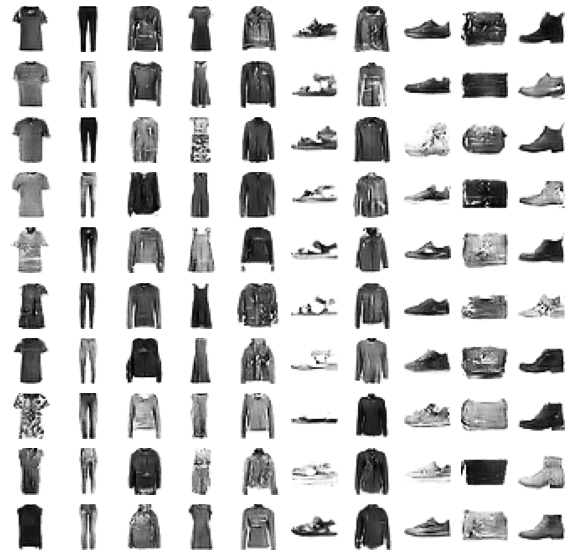

In [10]:
plt.subplots(figsize = (10,10)) # plotting subplots
for index in range(100):
    plt.subplot(10,10, index + 1) 
    plt.axis("off")  # removing axis
    plt.imshow(gen_images[index,:,:,0],cmap = "gray_r") #plotting image
plt.show()       
